# CMIP6 Regression and Driver Analysis

### Import Packages

In [1]:
# ========== Packages ==========
import xarray as xr
import pandas as pd
import numpy as np
import os
import copy
import glob
import sys
import importlib

# Processing
import dask
from dask.diagnostics import ProgressBar
import math
import multiprocessing as mp
import regionmask

# Statistics
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr, pearsonr, kendalltau, variation, gaussian_kde, skew, kurtosis, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan

# Regression models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, ParameterGrid, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor

# For plotting
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import cartopy.crs as ccrs
import seaborn as sns

import matplotlib.cm
from matplotlib import rcParams
from matplotlib.lines import Line2D
import matplotlib.colors as colors
from matplotlib.patches import Patch
import matplotlib.patches as mpatches

# For color map
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm

# Define the full path to the needed directories
data_handling_dir = '/work/ch0636/g300115/phd_project/common/src/data_handling'
data_analysis_dir = '/work/ch0636/g300115/phd_project/common/src/analysis'
data_vis_dir = '/work/ch0636/g300115/phd_project/common/src/visualization'
config_dir = '/work/ch0636/g300115/phd_project/common/src'

# Add the directories to sys.path
sys.path.append(data_handling_dir)
sys.path.append(data_analysis_dir)
sys.path.append(data_vis_dir)
sys.path.append(config_dir)

# Now import the functions from load_preprocessed_data.py and config
import load_data as load_dat
import process_data as pro_dat
import compute_statistics as comp_stats
import regression_analysis as reg_analysis
import regression_analysis_results as reg_results
import save_data_as_nc as sd
import colormaps as colmaps
from config import BASE_DIR, DEFAULT_MODEL, DEFAULT_VARIABLE, DEFAULT_TEMPORAL_RES, DEFAULT_EXPERIMENT

%matplotlib inline

rcParams["mathtext.default"] = 'regular'

ERROR 1: PROJ: proj_create_from_database: Open of /work/ch0636/g300115/.conda/envs/mypy3/share/proj failed


In [2]:
# Reload functions if changed
importlib.reload(comp_stats)
importlib.reload(pro_dat)
importlib.reload(reg_analysis)
importlib.reload(reg_results)
importlib.reload(colmaps)

<module 'colormaps' from '/work/ch0636/g300115/phd_project/common/src/visualization/colormaps.py'>

In [3]:
# Set pandas options to display the full DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

## Functions

### Driver Analysis

In [4]:
def plot_permutation_importances(permutation_importances, predictor_vars, performance_metrics, split='test', season='Year', save_fig=False):
    # Set larger font sizes
    plt.rcParams.update({'font.size': 24})
    
    # Get variable names and prepare them for display
    var_names = prepare_display_variables(predictor_vars)

    for region in permutation_importances:
        # Convert arrays to DataFrame for easy plotting, applying new variable names for display
        df = pd.DataFrame(permutation_importances[region].T, columns=predictor_vars)
        df.rename(columns=var_names, inplace=True)
        
        # Create the plot for the region
        fig, ax = plt.subplots(figsize=(12, 8))
        sns.boxplot(data=df, orient='h', ax=ax)
        ax.axvline(0, color='grey', linestyle='--')
        
        # Title with region
        ax.set_title(f'{region}')
        
        # Add Mean Squared Error and R-squared as text within the plot
        mse = round(performance_metrics[region]['MSE'], 4)
        r2 = round(performance_metrics[region]['R2'], 2)
        ax.text(0.95, 0.01, f'Mean Squared Error: {mse}\nR$^2$: {r2}',
                verticalalignment='bottom', horizontalalignment='right',
                transform=ax.transAxes,  # Position text relative to axes
                color='black', fontsize=26)
        
        ax.set_xlabel('Decrease in Accuracy Score')

        plt.tight_layout()
        plt.show()
        
        if save_fig:
            save_figure(fig, region, split, season)

In [5]:
def prepare_display_variables(variables):
    var_map = {
        'tas': ('T', '°C'),
        'vpd': ('VPD', 'hPa'),
        'gpp': ('GPP', r'\frac{\frac{gC}{m^2}}{day}'),  
        'pr': ('P', r'\frac{mm}{day}'),
        'mrro': ('R', r'\frac{mm}{day}'),
        'evspsbl': ('ET', r'\frac{mm}{day}'),
        'tran': ('Tran', r'\frac{mm}{day}'),
        'evapo': ('E', r'\frac{mm}{day}'),
        'lai': ('Lai', r'\frac{m^2}{m^2}'),
        'mrso': ('SM', '\%'),
        'rgtr': ('P/T', r'\frac{GPP}{T}'),
        'et_partitioning': ('EP', r'\frac{E-Tran}{ET}'),
        'gsl': ('GSL', 'month'),
        'RX5day': ('RX5d', 'mm'),
        'wue': ('WUE', r'\frac{GPP}{Tran}'),
        'bgws': ('BGWS', r'\frac{R-Tran}{P}')
    }
    display_variables = {}
    for var in variables:
        if var in var_map:
            abbreviation, units = var_map[var]
            # Enclose units in \left[ and \right] for automatic sizing
            display_variables[var] = f"${{\Delta\, \mathrm{{\it{{{abbreviation}}}}}}}$"
        else:
            print(f"Variable '{var}' not found in var_map.")
            display_variables[var] = var  # Or handle this case as appropriate
    return display_variables

## 1. Load and Preprocess

In [6]:
# ========= Define period, models and path ==============
data_state = 'processed'
data_product = 'CMIP6'
experiments = ['historical', 'ssp370']
models = ['BCC-CSM2-MR', 'CESM2', 'CMCC-CM2-SR5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'CanESM5', 
          'IPSL-CM6A-LR', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'NorESM2-MM', 'UKESM1-0-LL']

variables=['pr', 'tran', 'mrro', 'vpd', 'mrso', 'lai', 'wue', 'gsl', 'RX5day', 'evapo', 'gpp'] 
           
# Execute load function with Dask
with ProgressBar():
    ds_dict = dask.compute(load_dat.load_period_mean(BASE_DIR, data_state, data_product, experiments, models, variables, specific_months_or_seasons=None))[0]

Loading 'month' resolution variables ['pr', 'vpd', 'evapo', 'tran', 'mrro', 'mrso', 'lai', 'gpp', 'wue'] for experiment 'historical'...
Selecting period 1985-2014 for 'month' variables in experiment 'historical'...
Computing period mean for 'month' variables in experiment 'historical'...
Loading 'year' resolution variable 'RX5day' for experiment 'historical'...
Computing period mean for 'year' variable in experiment 'historical'...
Loading 'period_mean' resolution variable 'gsl' for experiment 'historical'...
Merging all datasets for experiment 'historical'...
Loading 'month' resolution variables ['pr', 'vpd', 'evapo', 'tran', 'mrro', 'mrso', 'lai', 'gpp', 'wue'] for experiment 'ssp370'...
Selecting period 2071-2100 for 'month' variables in experiment 'ssp370'...
Computing period mean for 'month' variables in experiment 'ssp370'...
Loading 'year' resolution variable 'RX5day' for experiment 'ssp370'...
Computing period mean for 'year' variable in experiment 'ssp370'...
Loading 'period_m

In [7]:
ds_dict['historical'][list(ds_dict['historical'].keys())[3]]

<xarray.Dataset>
Dimensions:  (lat: 149, lon: 360)
Coordinates:
  * lat      (lat) int64 -59 -58 -57 -56 -55 -54 -53 ... 83 84 85 86 87 88 89
  * lon      (lon) int64 -180 -179 -178 -177 -176 -175 ... 175 176 177 178 179
Data variables:
    pr       (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    vpd      (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    evapo    (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    tran     (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    mrro     (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    mrso     (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    lai      (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    gpp      (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    wue      (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    RX5day   (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    gsl      (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/70)
    Conventions:                      CF-1.7 CMIP-6.2
    description:                      CMIP6 historical
    title:                            CNRM-CM6-1 model output prepared for CM...
    activity_id:                      CMIP
    contact:                          contact.cmip@meteo.fr
    data_specs_version:               01.00.21
    ...                               ...
    intake_esm_attrs:time_min:        185001.0
    intake_esm_attrs:time_max:        201412.0
    intake_esm_attrs:_data_format_:   netcdf
    intake_esm_dataset_key:           CMIP.CNRM-CM6-1.historical.Amon.gr
    log:                              Dataset sliced along lat 60 to remove A...
    regrid_method:                    conservative

## 2. Compute Historical BGWS and Ensemble statsitics

In [7]:
ds_dict = pro_dat.compute_bgws(ds_dict)

In [8]:
ds_dict['historical'] = comp_stats.compute_ensemble_statistic(ds_dict['historical'], 'mean')
ds_dict['historical'] = comp_stats.compute_ensemble_statistic(ds_dict['historical'], 'median')

Computed Ensemble mean for all experiments.
Computed Ensemble median for all experiments.


In [9]:
ds_dict['ssp370'] = comp_stats.compute_ensemble_statistic(ds_dict['ssp370'], 'mean')
ds_dict['ssp370'] = comp_stats.compute_ensemble_statistic(ds_dict['ssp370'], 'median')

Computed Ensemble mean for all experiments.
Computed Ensemble median for all experiments.


## 3. Compute Changes and Ensemble statsitics

In [10]:
ds_dict_change = pro_dat.compute_change_dict(ds_dict)

Ensemble mean or median removed for keys: ['Ensemble mean', 'Ensemble median']


In [11]:
ds_dict_change['ssp370-historical'] = comp_stats.compute_ensemble_statistic(ds_dict_change['ssp370-historical'], 'mean')
ds_dict_change['ssp370-historical'] = comp_stats.compute_ensemble_statistic(ds_dict_change['ssp370-historical'], 'median')

Computed Ensemble mean for all experiments.
Computed Ensemble median for all experiments.


## 4. Divide Data into Regions and Subdregions

In [12]:
ds_dict_region = {}
ds_dict_region = pro_dat.apply_region_mask(ds_dict, with_global=True)

In [13]:
ds_dict_change_region = {}
ds_dict_change_region = pro_dat.apply_region_mask(ds_dict_change, with_global=True)

In [14]:
ds_dict_region_sub = {}
ds_dict_region_sub = pro_dat.subdivide_ds_dict_regions(ds_dict_region['historical'], 
                                                      ds_dict_region['historical'], 'historical', 'historical', 'bgws')

In [15]:
ds_dict_change_region_sub = {}
ds_dict_change_region_sub = pro_dat.subdivide_ds_dict_regions(ds_dict_region['historical'], 
                                                      ds_dict_change_region['ssp370-historical'], 'historical', 'ssp370-historical', 'bgws')

## 5. Regression Analysis

In [17]:
# Reload function if changes have been applied
importlib.reload(reg_analysis)

<module 'regression_analysis' from '/work/ch0636/g300115/phd_project/common/src/analysis/regression_analysis.py'>

#### Regional Regression Analysis

In [277]:
# Define predictors and predictant
predictor_vars = ['pr', 'vpd', 'mrso', 'lai', 'wue', 'RX5day', 'gsl']  
predictant = 'bgws'
scaling_method = 'max' # None max
test_size = 0.2 # Share of the dataset used as test dataset (default is 0.3)
regression_type='elasticnet' # Regression technique (tested are ridge, lasso and elasticnet)
param_grid=None # Specify parameter grid here if different one to default should be used
grid_cell_threshold=50 # Define threshold for minimum grid cells per region
cv_folds=5 # define k for cross-validation (default is 5)
scoring='r2' # Scoring metric for Cross-Validation, default is r2.
evaluation_method='test_and_cv' # Method of evaluation ('test', 'cv' or 'test_and_cv'), default is 'test'.
variable_importance_method='PI' # Method to assess variable importance SHAP or PI
n_permutations = 20 #  Number of permutations for permutation importance, default is 20.
selected_region =  None # Specific region to analyze, default is None (analyze all). Define like this [0, 1, 2]

# Analyze a specific region and subdivision
results_regression_analysis_regions = reg_analysis.regression_analysis_regions(ds_dict_change_region['ssp370-historical']['Ensemble mean'], 
                                                             predictor_vars, predictant, scaling_method, 
                                                             test_size, regression_type, 
                                                             param_grid, grid_cell_threshold, 
                                                             cv_folds, scoring, evaluation_method, 
                                                             variable_importance_method, n_permutations,
                                                             selected_region)

Performing regression analysis for N.W.North-America
Regression analysis based on 852 grid cells
Performing regression analysis for N.E.North-America
Regression analysis based on 690 grid cells
Performing regression analysis for W.North-America
Regression analysis based on 301 grid cells
Performing regression analysis for C.North-America
Regression analysis based on 270 grid cells
Performing regression analysis for E.North-America
Regression analysis based on 339 grid cells
Performing regression analysis for N.Central-America
Regression analysis based on 164 grid cells
Performing regression analysis for S.Central-America
Regression analysis based on 84 grid cells
Performing regression analysis for Caribbean
No regression analysis as grid cells < threshold 
Performing regression analysis for N.W.South-America
Regression analysis based on 173 grid cells
Performing regression analysis for N.South-America
Regression analysis based on 317 grid cells
Performing regression analysis for N.E.So

In [138]:
results_regression_analysis_regions

{'N.W.North-America': {'regression_model': ElasticNet(alpha=0.01, l1_ratio=0.2),
  'performance': {'R2 Train': 0.13223533122287434,
   'R2 Test': 0.12975205759281672,
   'CV Mean Score': 0.08995215219277501,
   'CV Std Dev': 0.10009895623717091},
  'variable_importance': {'Permutation Importance Testing Data': array([[ 9.55739542e-03,  7.88578441e-03,  3.55910099e-03,
            1.11482826e-02,  3.05715456e-02,  1.87443539e-02,
            1.20429003e-02, -4.07470410e-03,  4.48457597e-03,
           -2.58066564e-03,  3.60760414e-03,  1.91298060e-03,
            2.03419603e-02, -2.80443712e-03,  9.33865710e-03,
            6.85373849e-03,  1.02337559e-02,  1.89248330e-03,
           -9.14045991e-03, -8.78553405e-04],
          [-1.00159547e-02,  8.81013337e-03, -3.14911455e-03,
           -1.40594448e-03,  1.33752100e-02,  3.19309049e-03,
            1.65099494e-03, -5.64715565e-03, -4.47750528e-03,
            6.28581118e-04, -2.22558823e-02,  1.44676161e-03,
            3.76895528e-0

In [62]:
reg_results.create_results_dataframe_regions(results_regression_analysis_regions, 
                                             save_dir='/work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/model_performance/',
                                             filename='regression_model_results_regions.csv'
                                            )

Table saved under /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/model_performance/regression_model_results_regions.csv


Region  alpha  l1_ratio      n  R2 Train  R2 Test  \
0   South-American-Monsoon   0.00       0.5    235      0.90     0.90   
1          E.North-America   0.00       0.8    339      0.83     0.87   
2          N.South-America   0.00       0.8    317      0.79     0.66   
3        W.Southern-Africa   0.00       0.2    263      0.78     0.64   
4        N.Central-America   0.00       0.8    164      0.78     0.70   
5                   E.Asia   0.00       0.8    479      0.74     0.65   
6        Arabian-Peninsula   0.00       0.8    243      0.69     0.82   
7              E.Australia   0.00       0.8     85      0.76     0.83   
8          C.North-America   0.00       0.8    270      0.73     0.67   
9        N.W.South-America   0.00       0.2    173      0.71     0.72   
10       S.Central-America   0.01       0.8     84      0.73     0.60   
11       N.E.South-America   0.00       0.2    201      0.68     0.74   
12          Western-Africa   0.01       0.8    229      0.71     0.59   
13                  S.Asia   0.00       0.2    362      0.67     0.47   
14        N.Eastern-Africa   0.01       0.8    216      0.62     0.63   
15          Central-Africa   0.00       0.5    366      0.62     0.70   
16        S.Eastern-Africa   0.00       0.5    147      0.65     0.44   
17       S.W.South-America   0.01       0.8     93      0.72     0.74   
18       E.Southern-Africa   0.10       0.8    232      0.54     0.57   
19                E.Europe   0.00       0.8    356      0.55     0.52   
20                  Global   0.00       0.8  13233      0.45     0.44   
21       S.E.South-America   0.00       0.5    337      0.49     0.40   
22                  Sahara   0.00       0.8    801      0.50     0.33   
23          Russian-Arctic   0.00       0.5    888      0.45     0.40   
24         S.South-America   0.01       0.5    102      0.68     0.66   
25               E.Siberia   0.00       0.2    708      0.43     0.45   
26       N.E.North-America   0.00       0.8    690      0.41     0.49   
27             C.Australia   0.01       0.8    292      0.43     0.39   
28         W.North-America   0.00       0.2    301      0.44     0.35   
29                N.Europe   0.01       0.8    358      0.40     0.42   
30             S.Australia   0.01       0.8    150      0.48     0.13   
31                S.E.Asia   0.00       0.8    348      0.35     0.47   
32         Tibetan-Plateau   0.01       0.8    221      0.42     0.32   
33               W.Siberia   0.00       0.8    523      0.38     0.32   
34     West&Central-Europe   0.00       0.8    368      0.39     0.42   
35             N.Australia   0.01       0.2    123      0.43     0.19   
36                W.C.Asia   0.00       0.2    468      0.34     0.30   
37        Russian-Far-East   0.00       0.2    399      0.34     0.31   
38                E.C.Asia   0.01       0.2    260      0.28     0.27   
39           Mediterranean   0.00       0.2    400      0.16     0.04   
40       N.W.North-America   0.01       0.2    852      0.13     0.13   

    CV Mean Score  
0            0.89  
1            0.82  
2            0.75  
3            0.72  
4            0.71  
5            0.71  
6            0.70  
7            0.70  
8            0.70  
9            0.69  
10           0.66  
11           0.65  
12           0.64  
13           0.61  
14           0.60  
15           0.59  
16           0.56  
17           0.55  
18           0.52  
19           0.52  
20           0.45  
21           0.45  
22           0.45  
23           0.43  
24           0.43  
25           0.42  
26           0.40  
27           0.40  
28           0.38  
29           0.36  
30           0.35  
31           0.35  
32           0.35  
33           0.35  
34           0.35  
35           0.32  
36           0.30  
37           0.30  
38           0.21  
39           0.09  
40           0.09

In [44]:
# Get mean r2
reg_results.compute_mean_r2_regions(results_regression_analysis_regions)

Mean R2 for Training Data: 0.55
Mean R2 for Testing Data: 0.50
Mean CV Score: 0.50


(0.5504349496027705, 0.504906023904849, 0.5004143553018833)

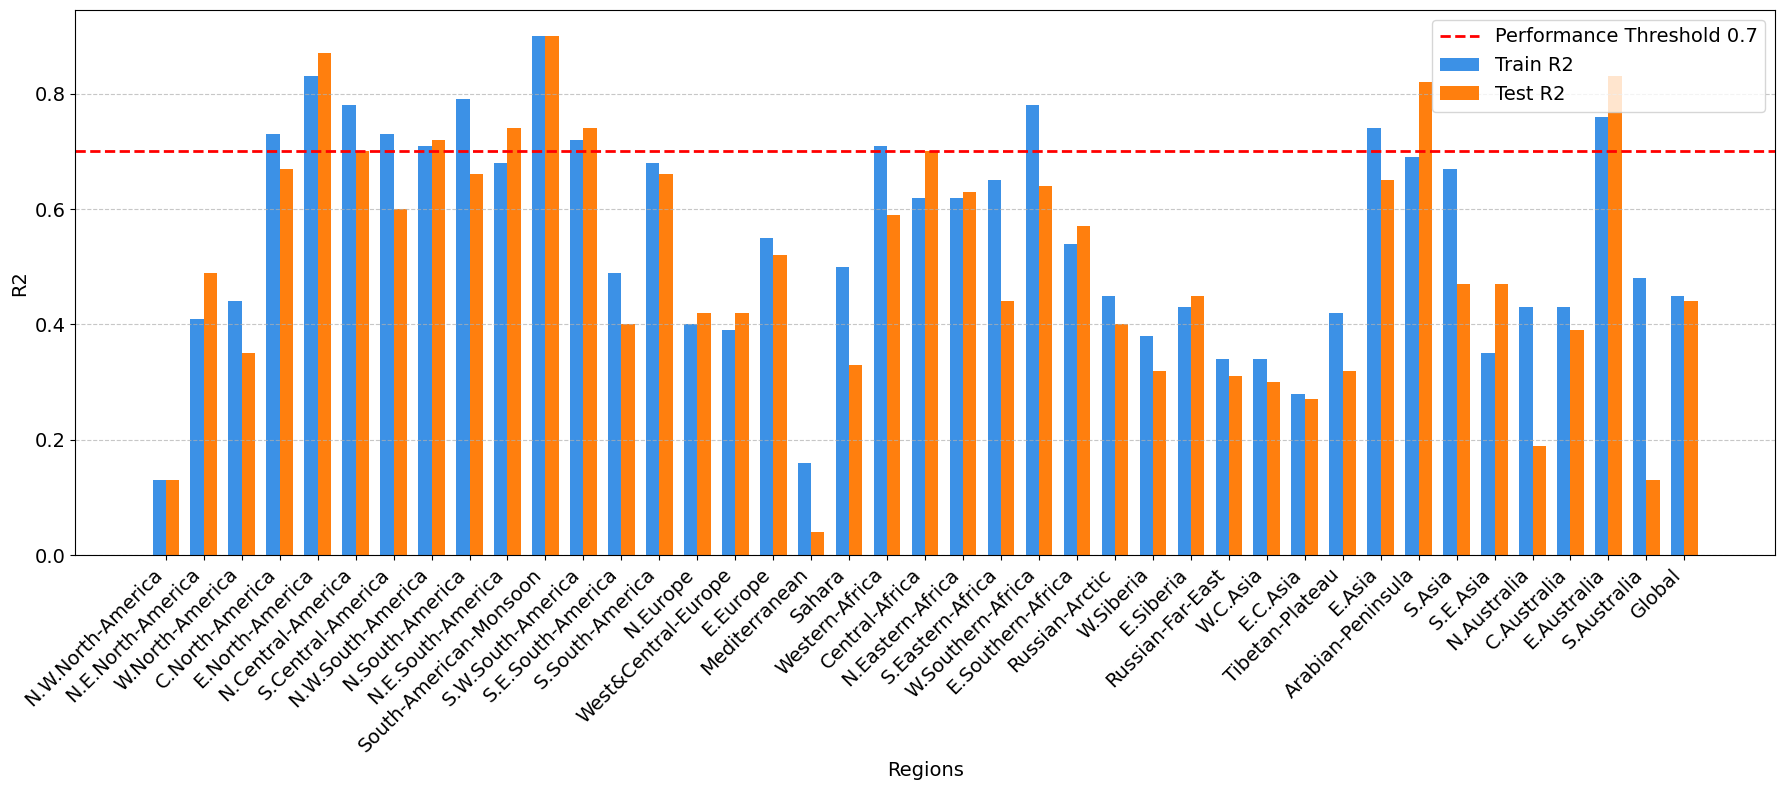

In [82]:
reg_results.plot_performance_scores_regions(results_regression_analysis_regions, scoring, plot_type='test' 
    ,save_path='/work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/model_performance/')

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


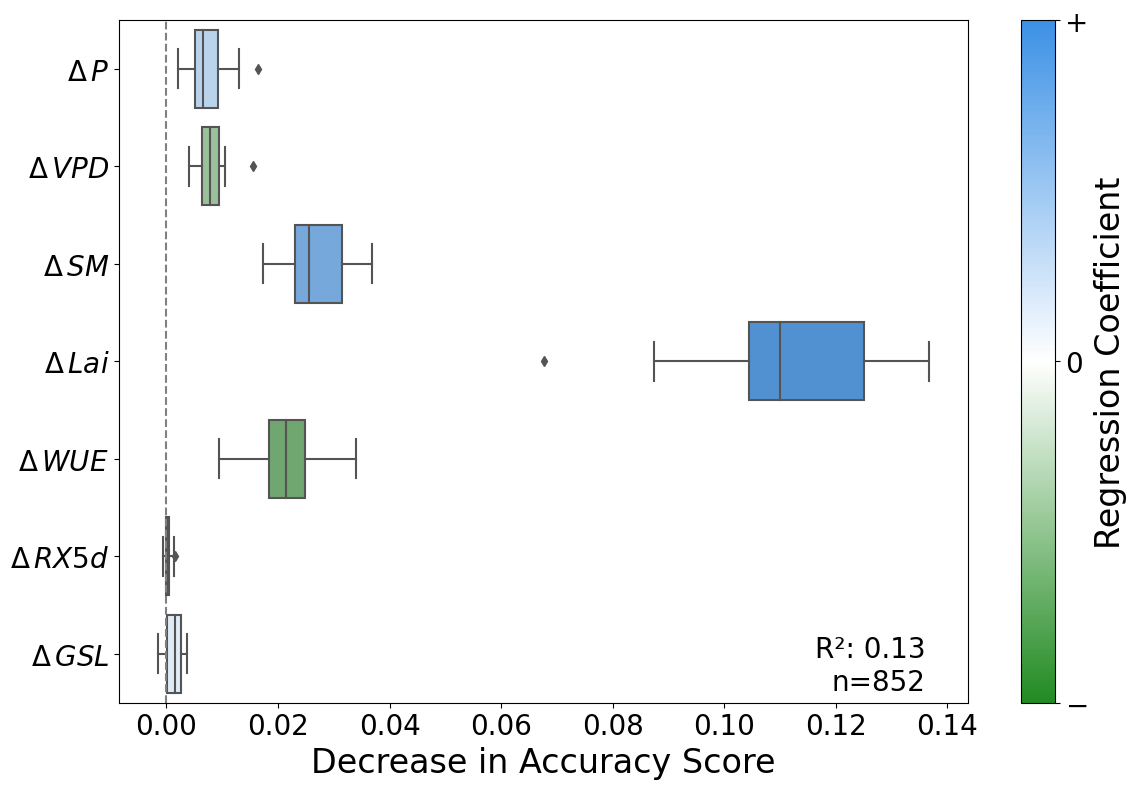

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


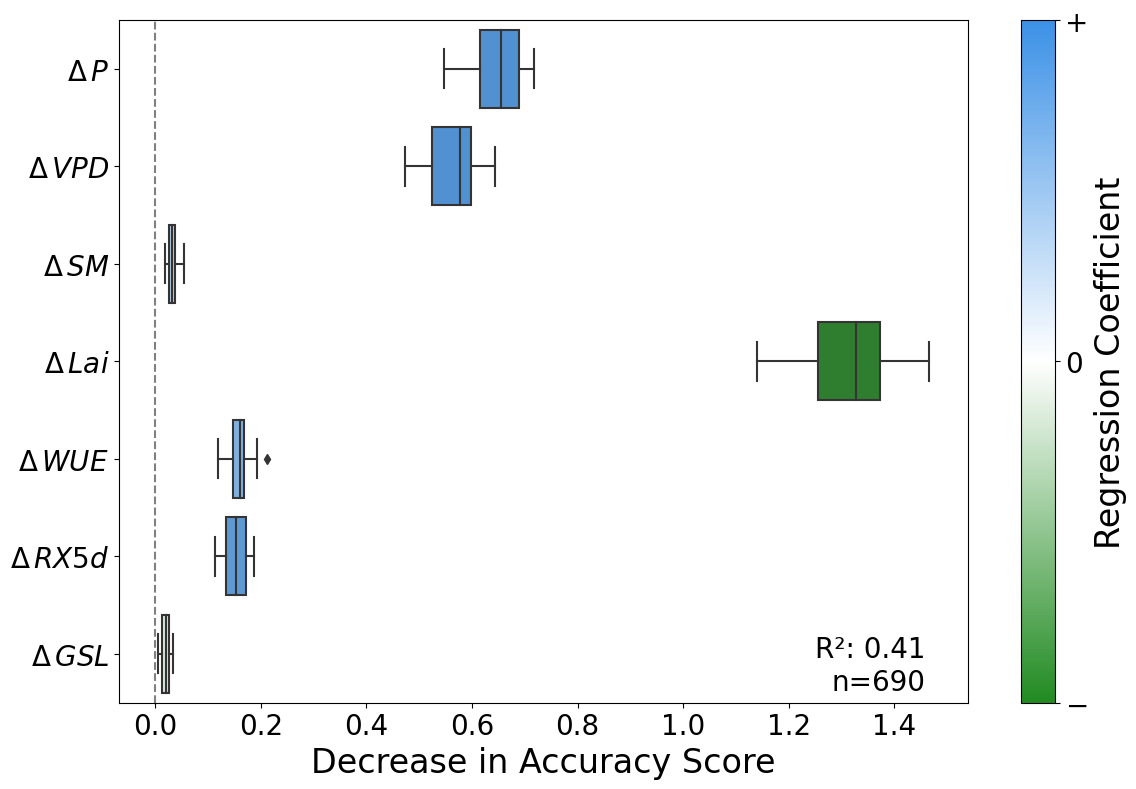

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


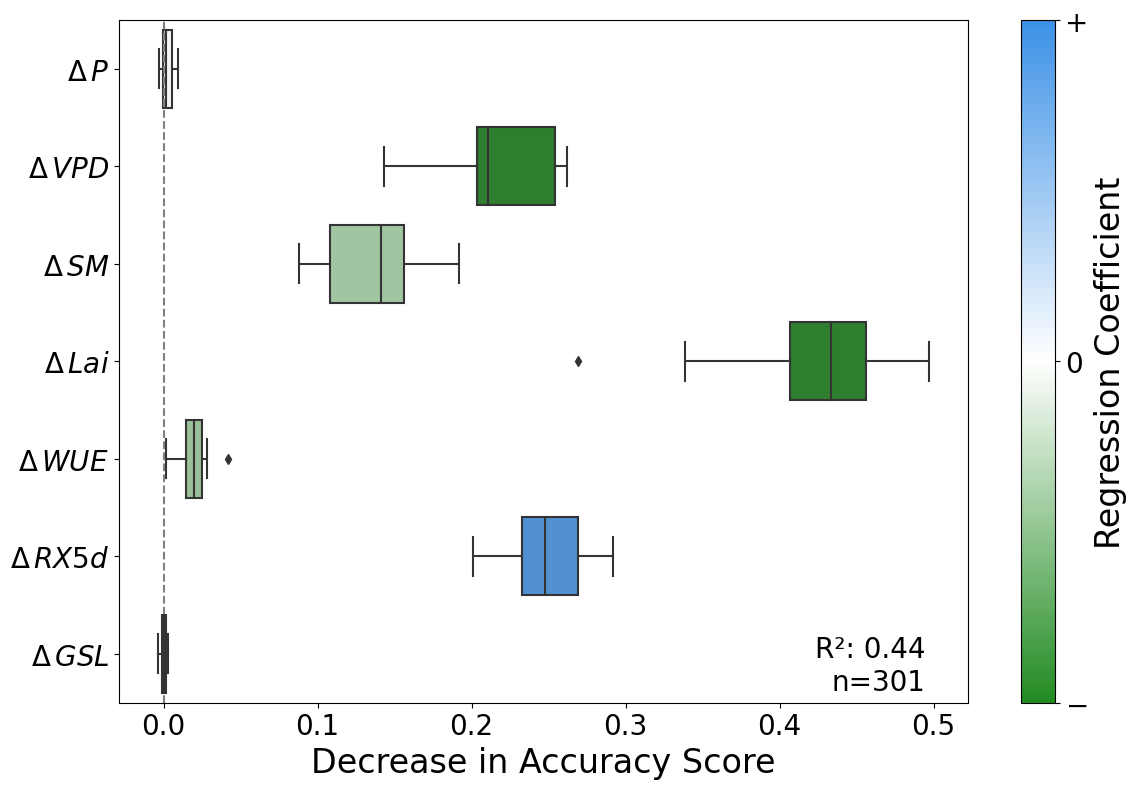

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


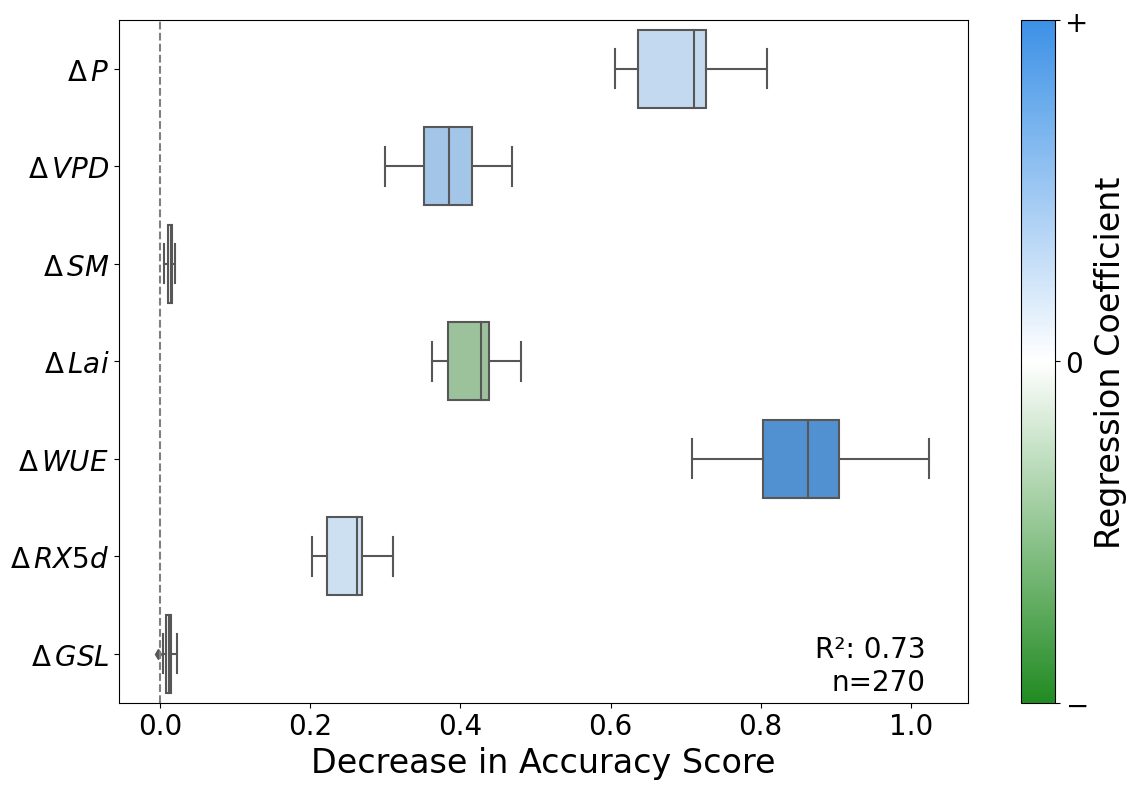

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


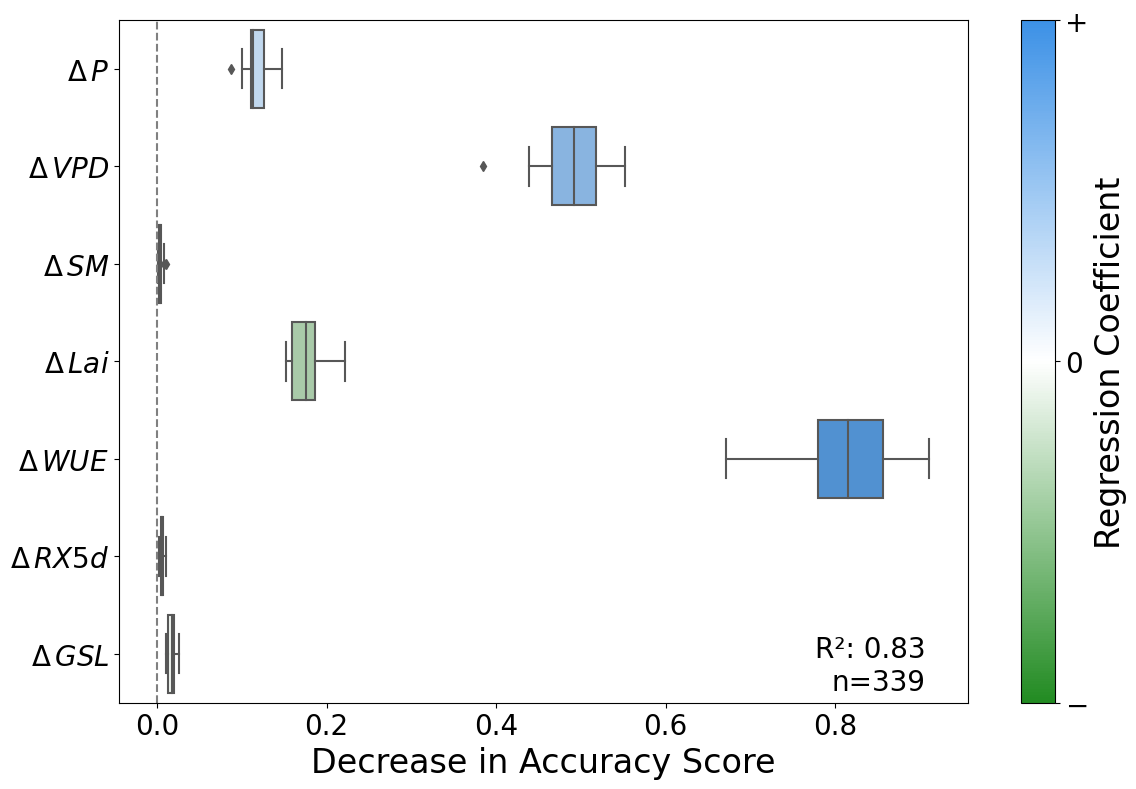

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


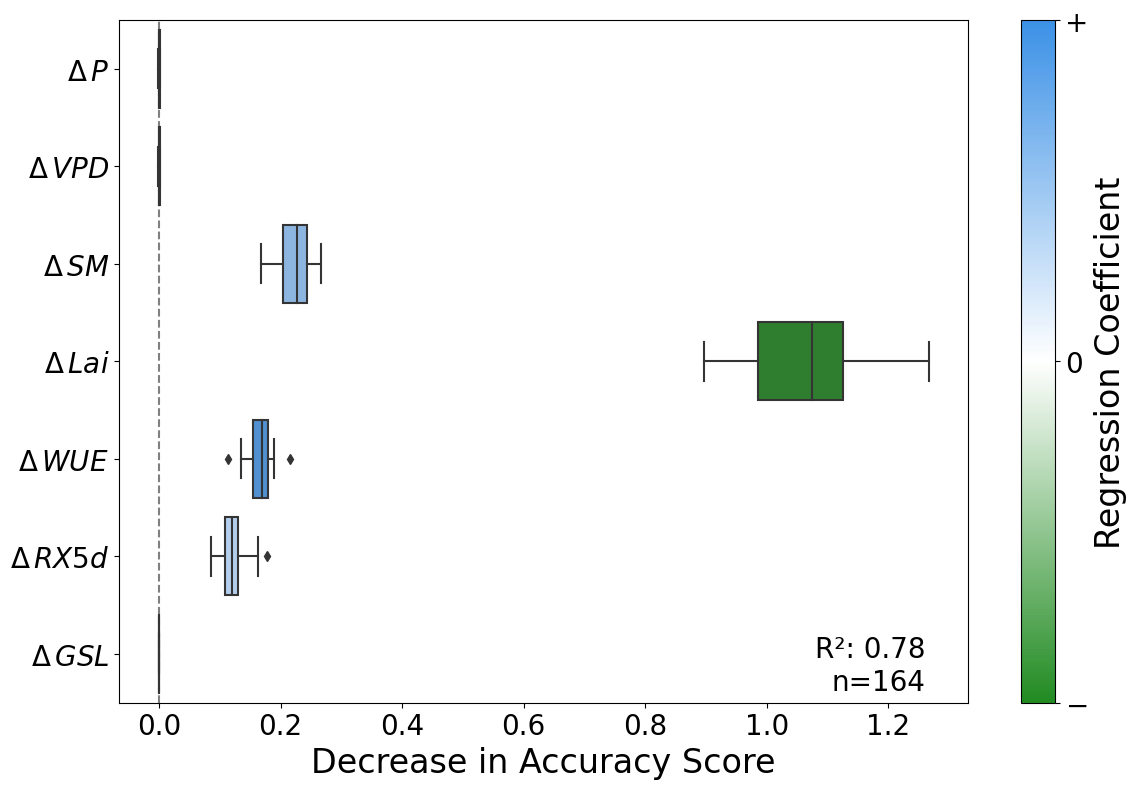

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


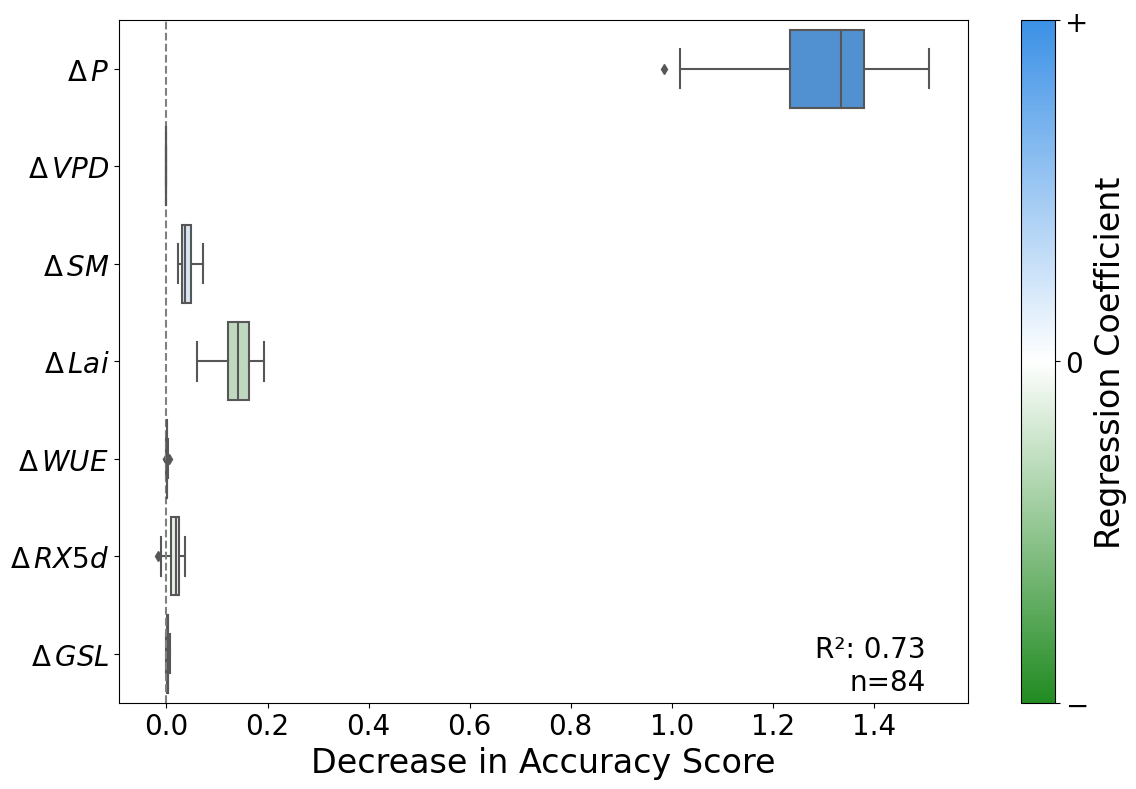

Skipping Caribbean as it does not have variable importance data.
Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


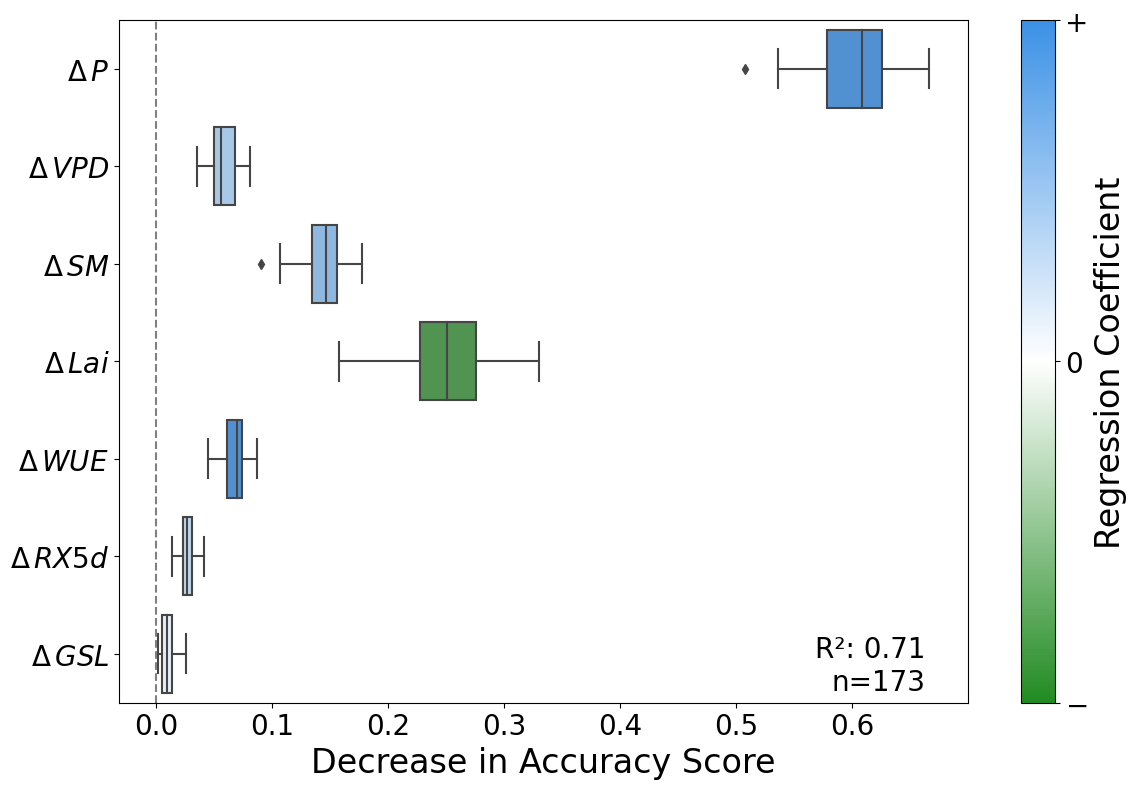

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


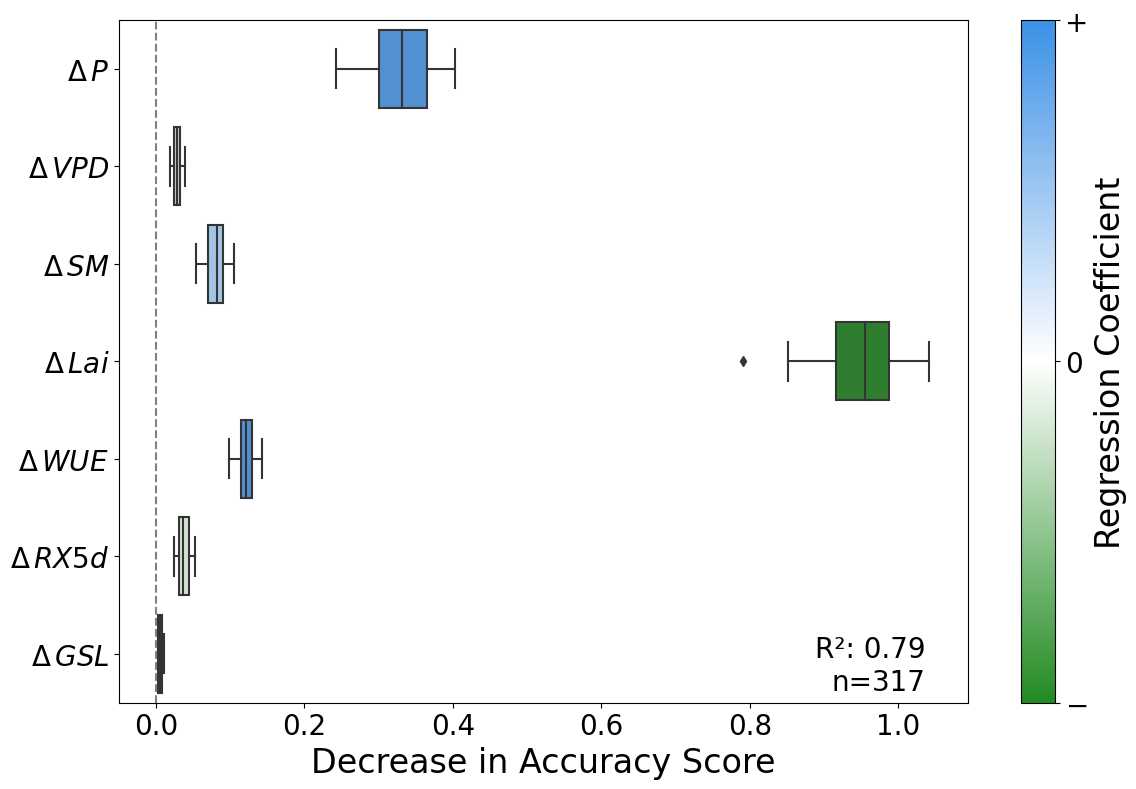

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


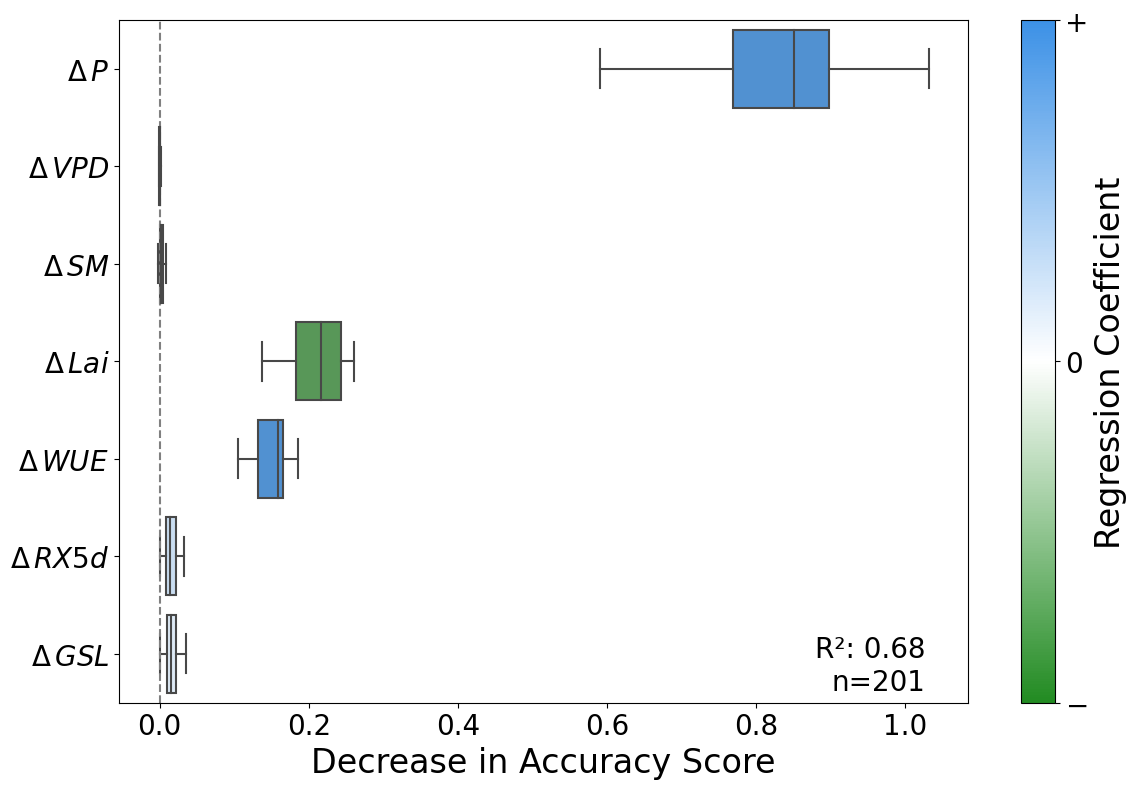

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


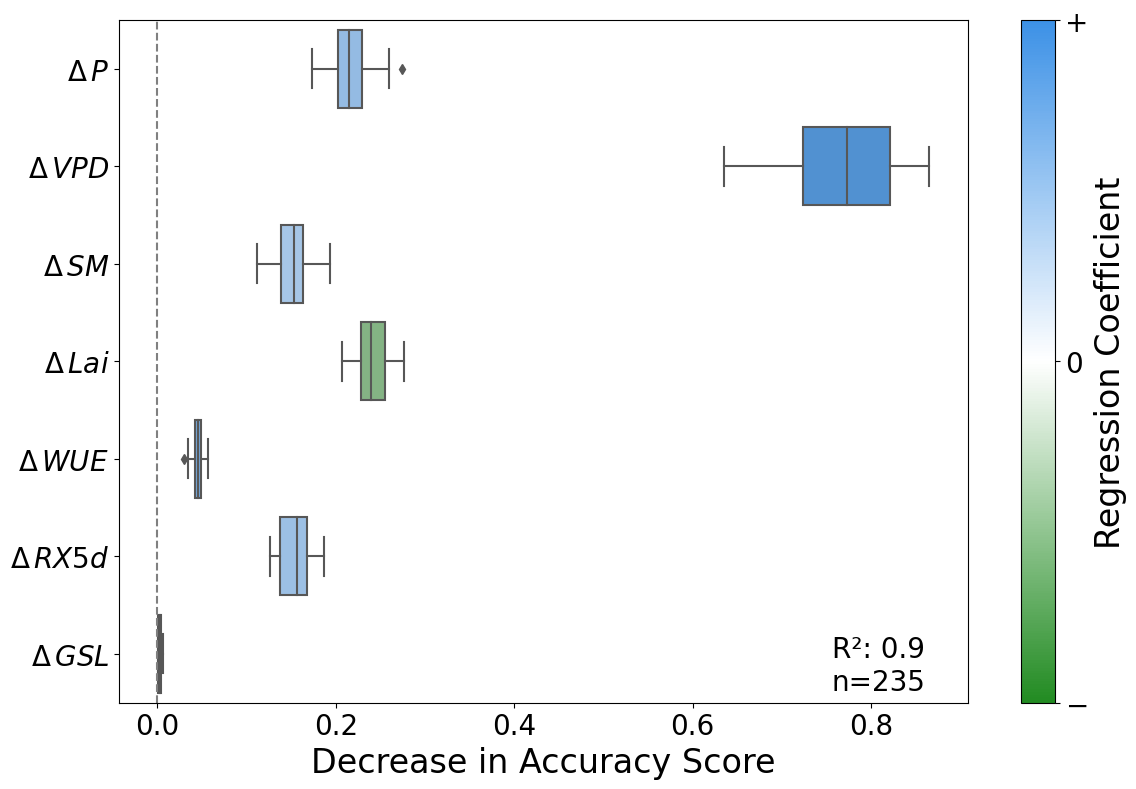

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


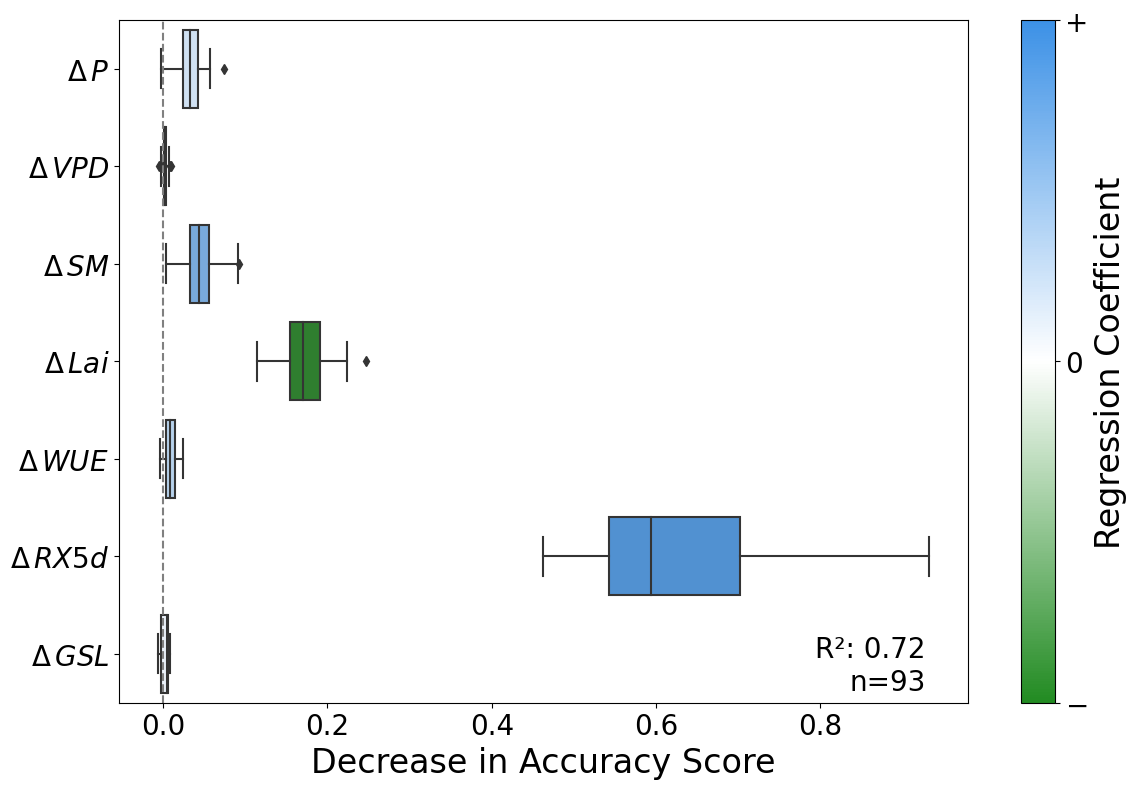

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


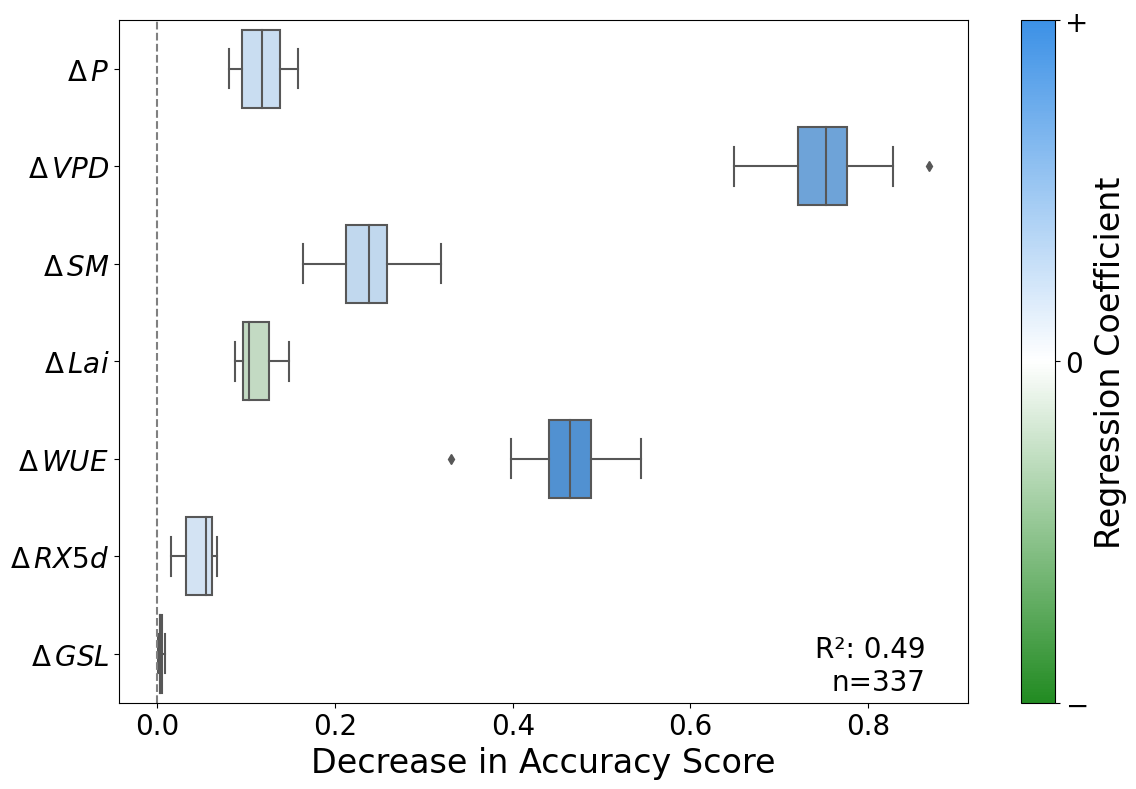

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


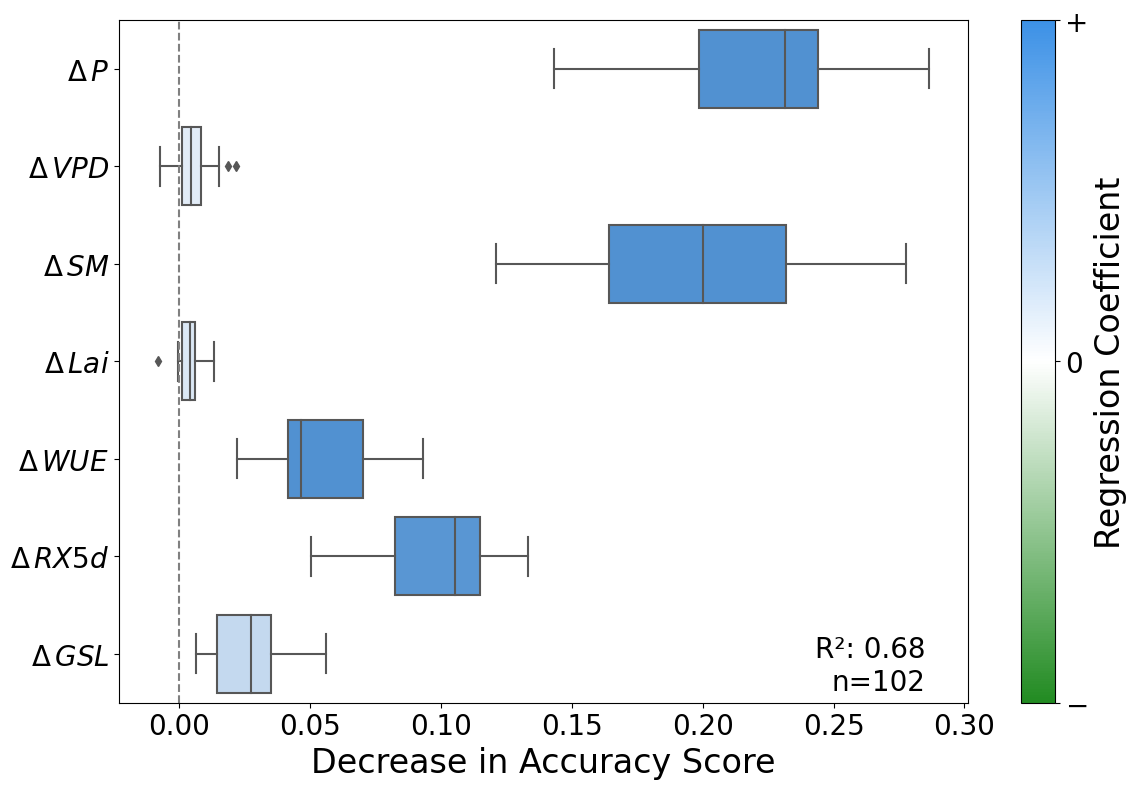

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


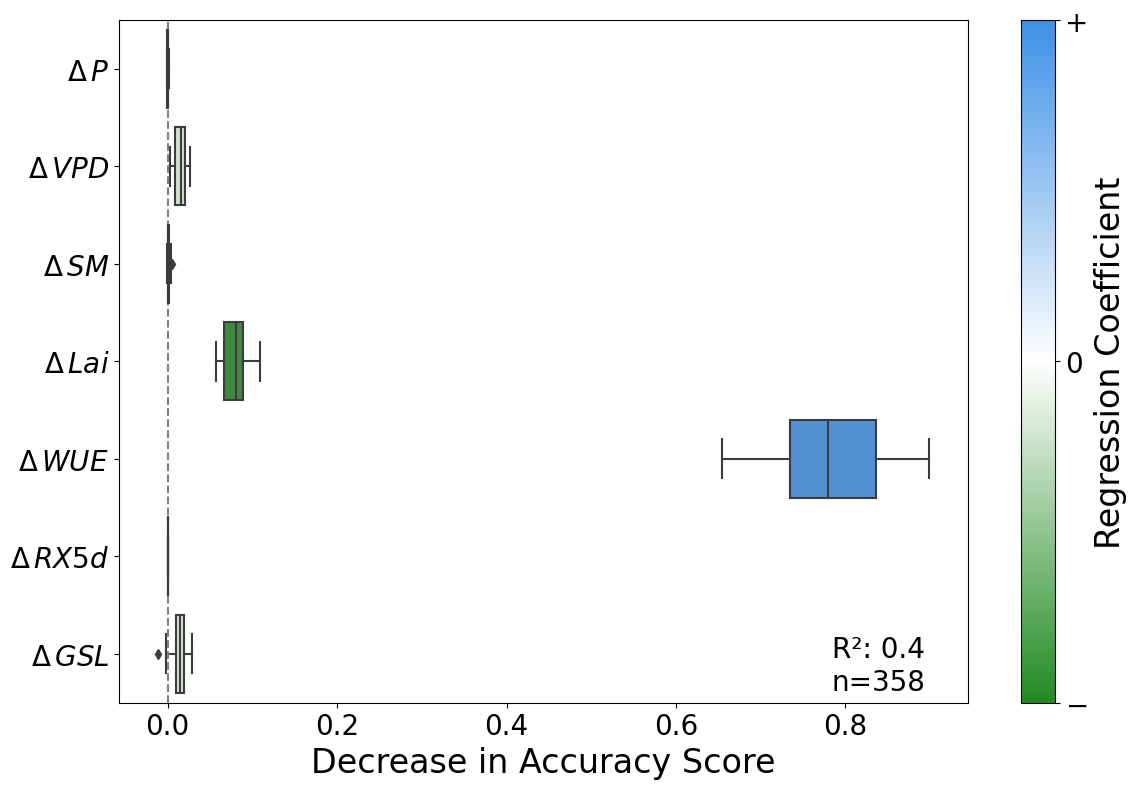

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


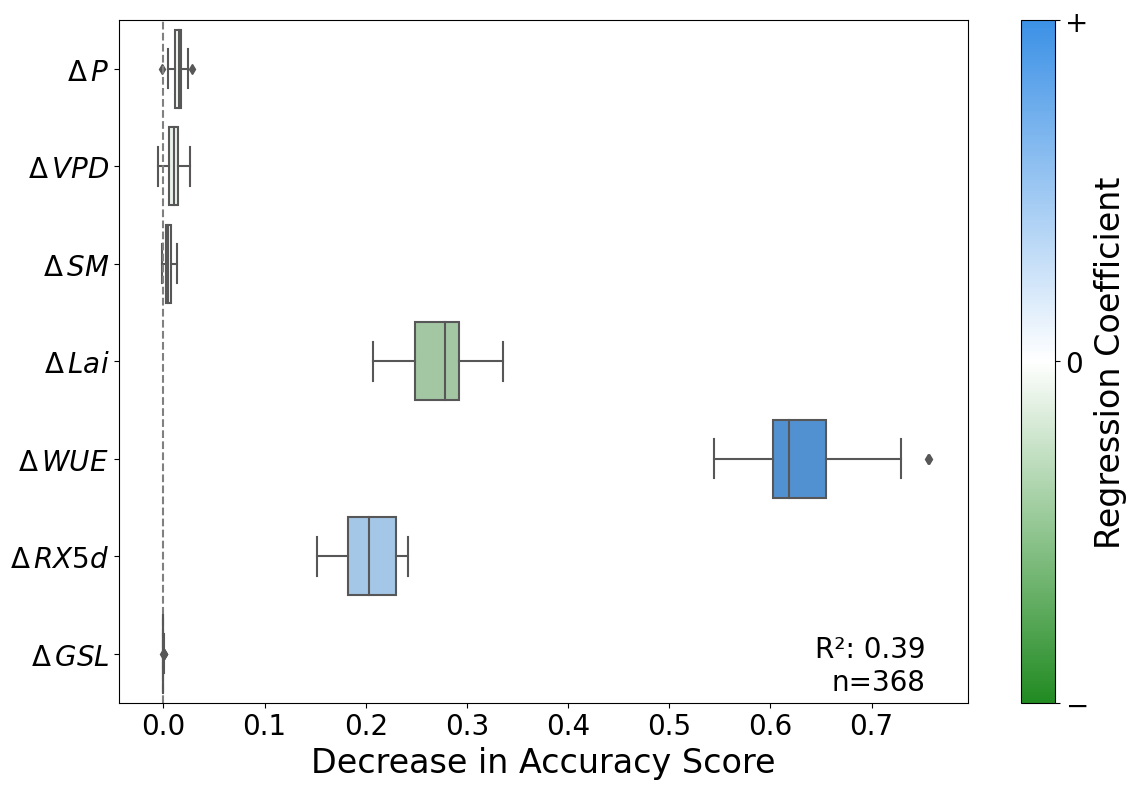

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


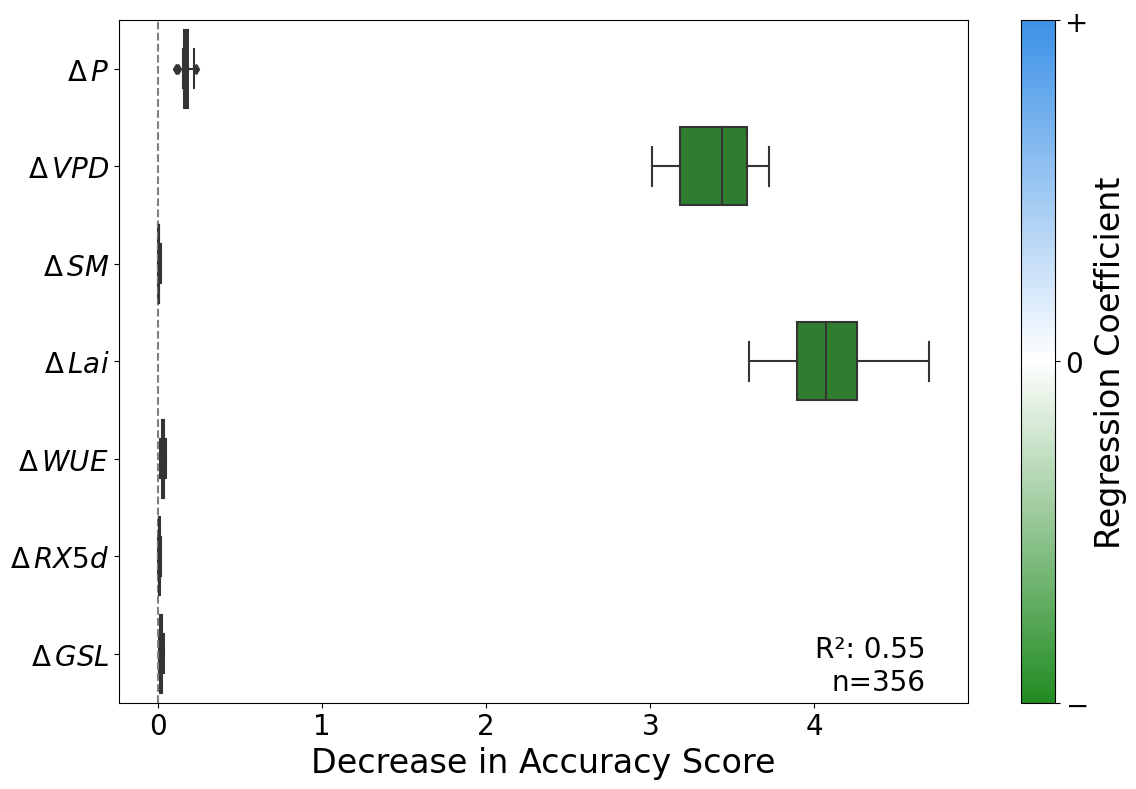

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


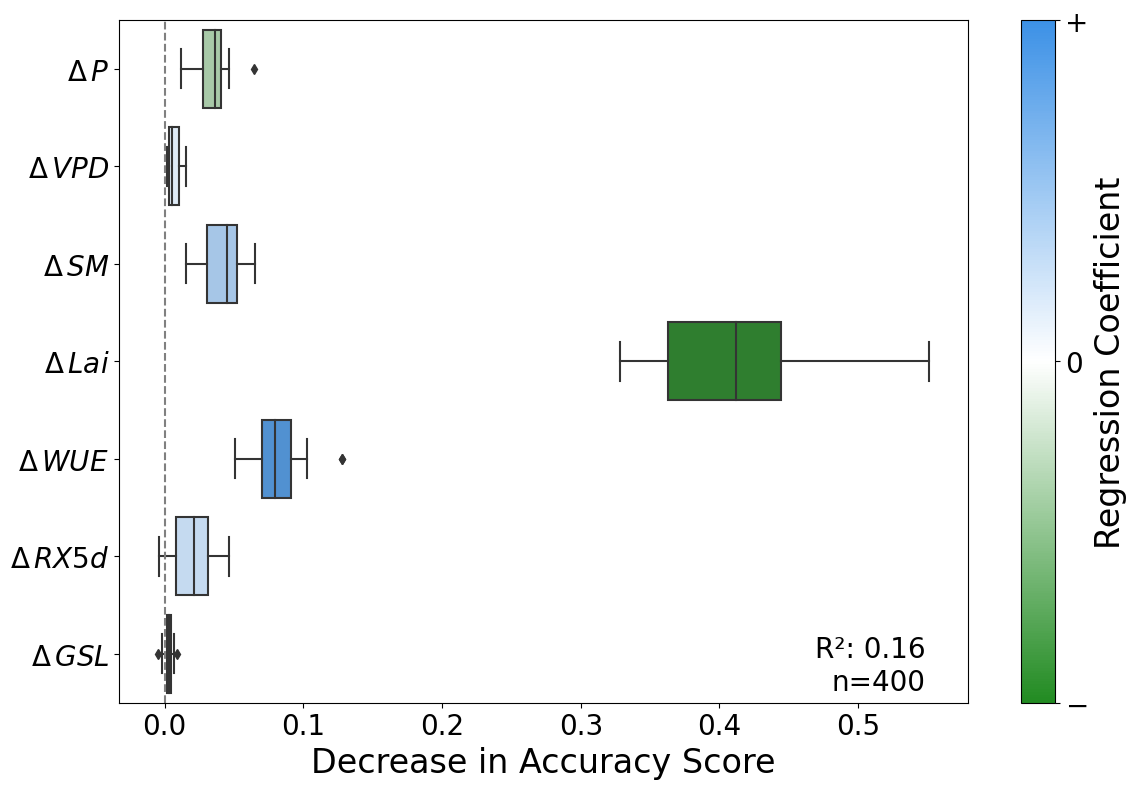

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


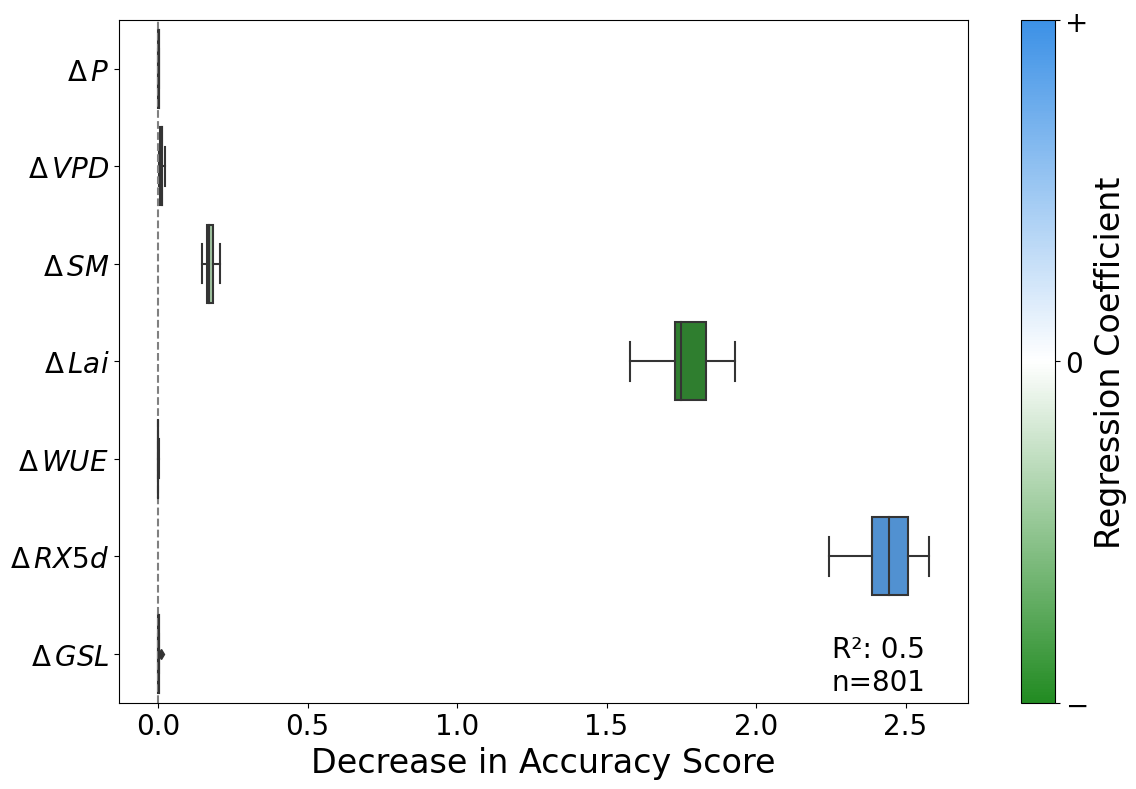

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


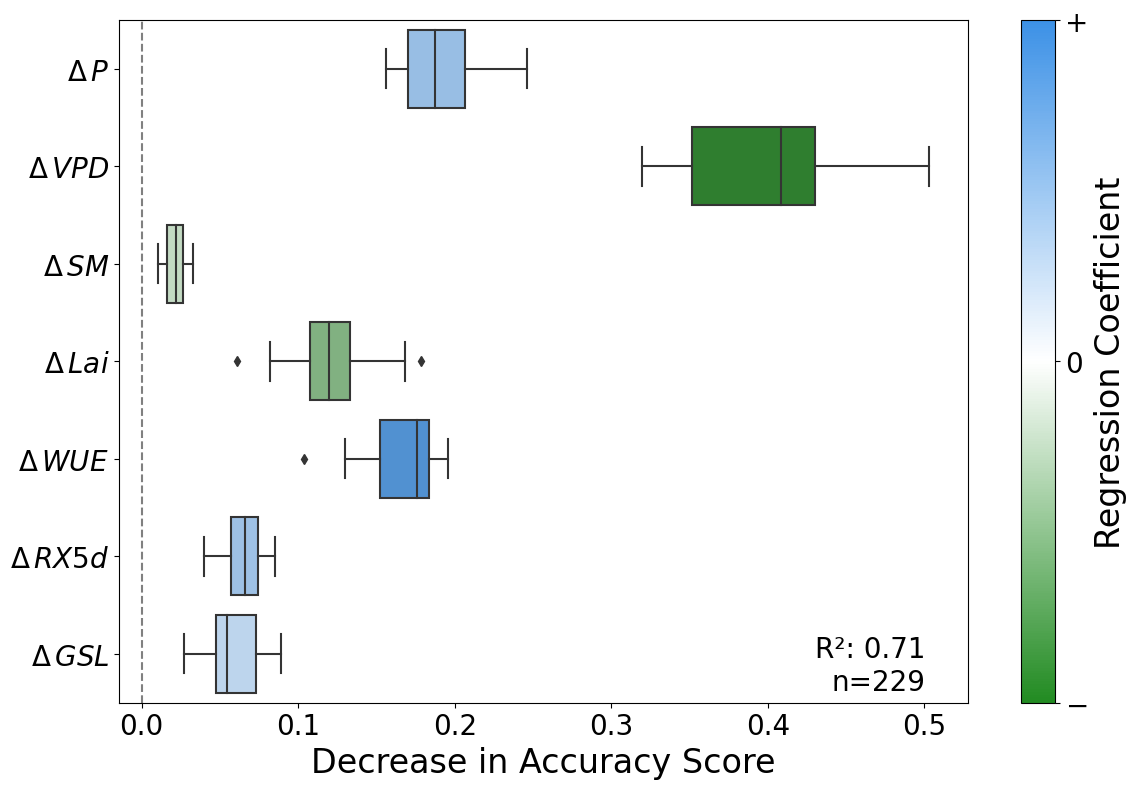

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


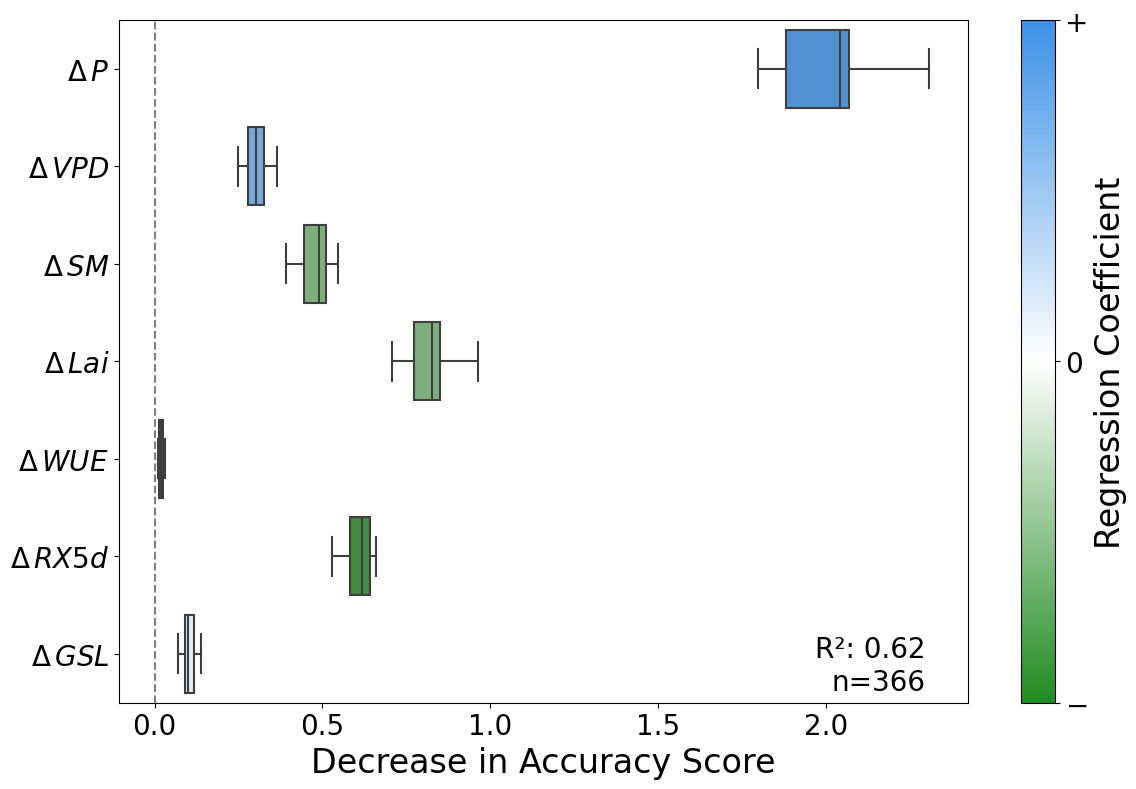

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


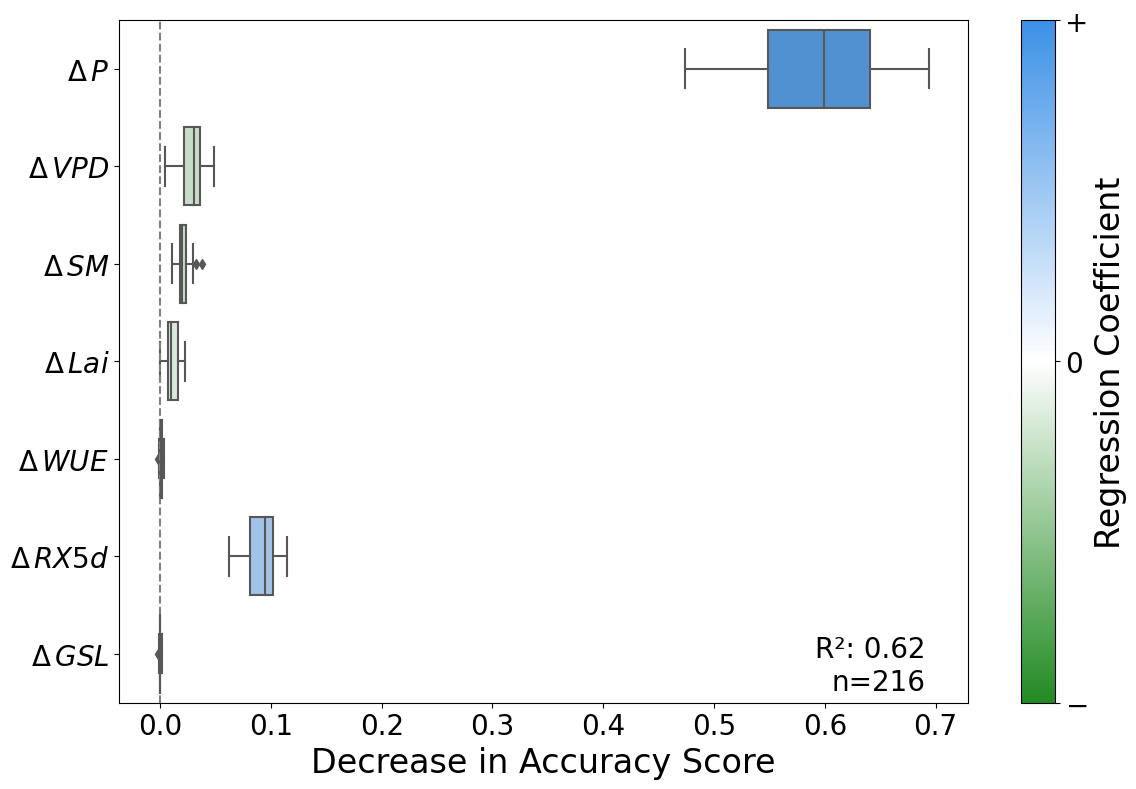

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


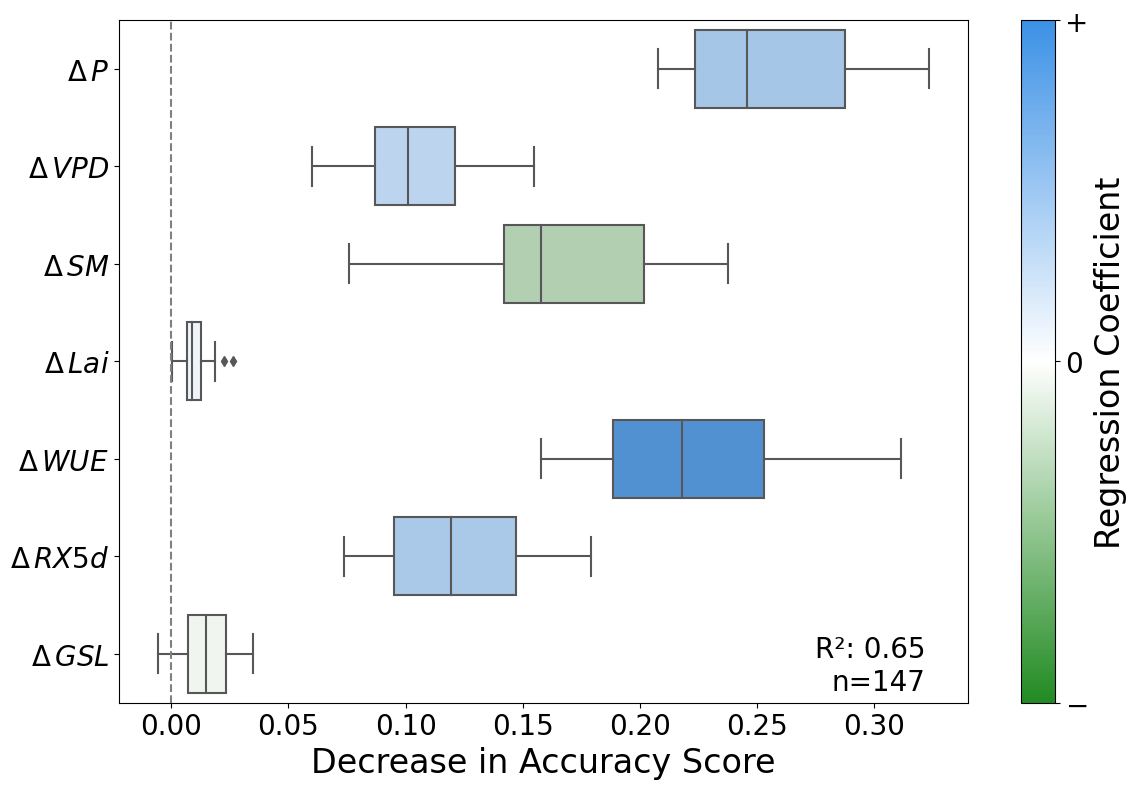

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


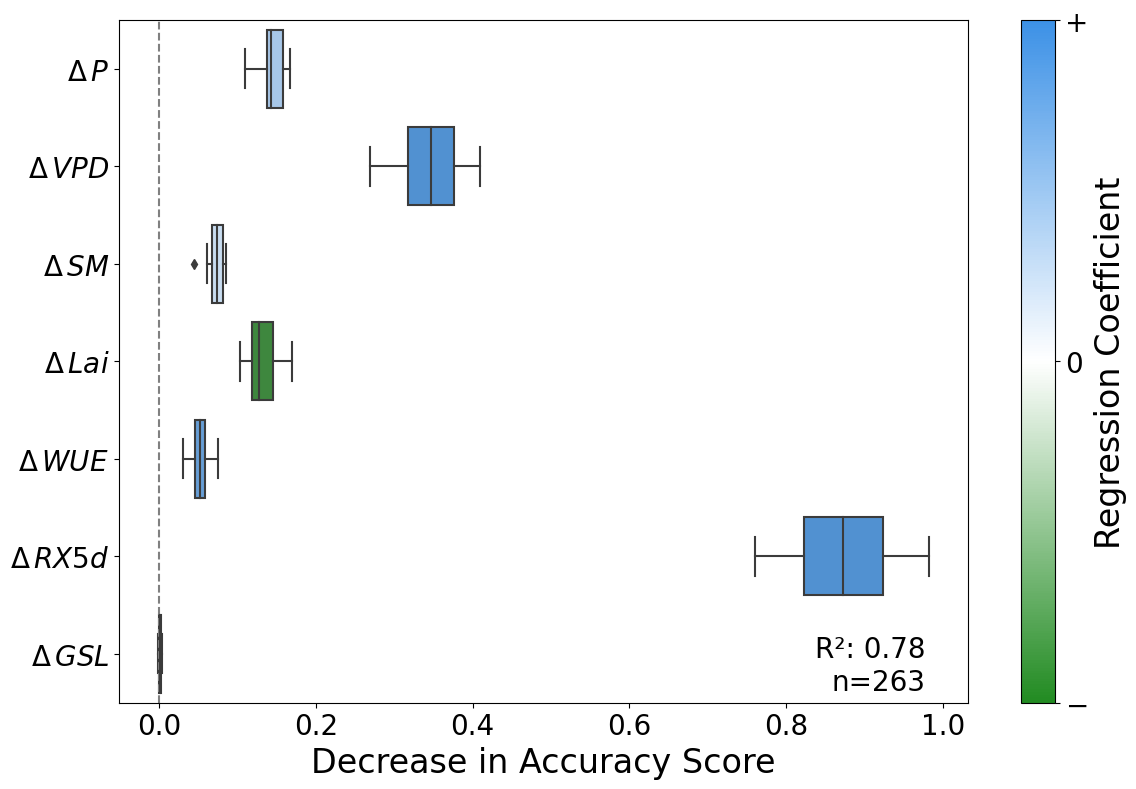

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


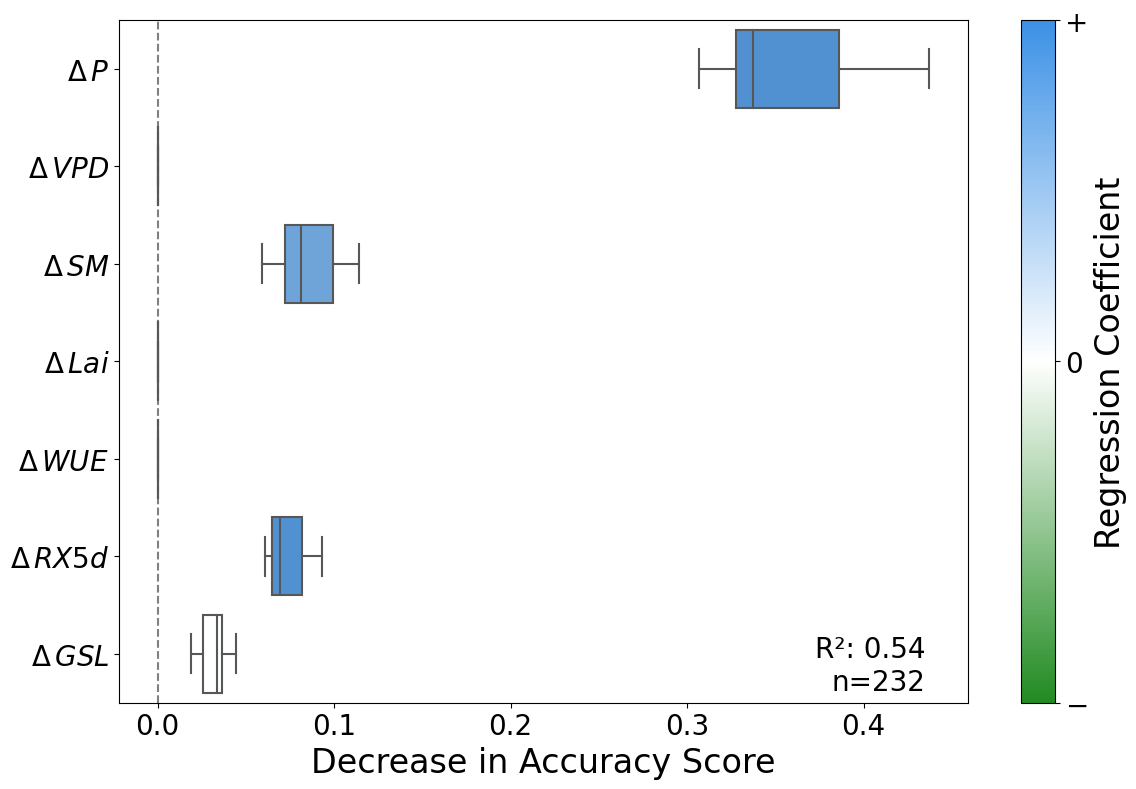

Skipping Madagascar as it does not have variable importance data.
Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


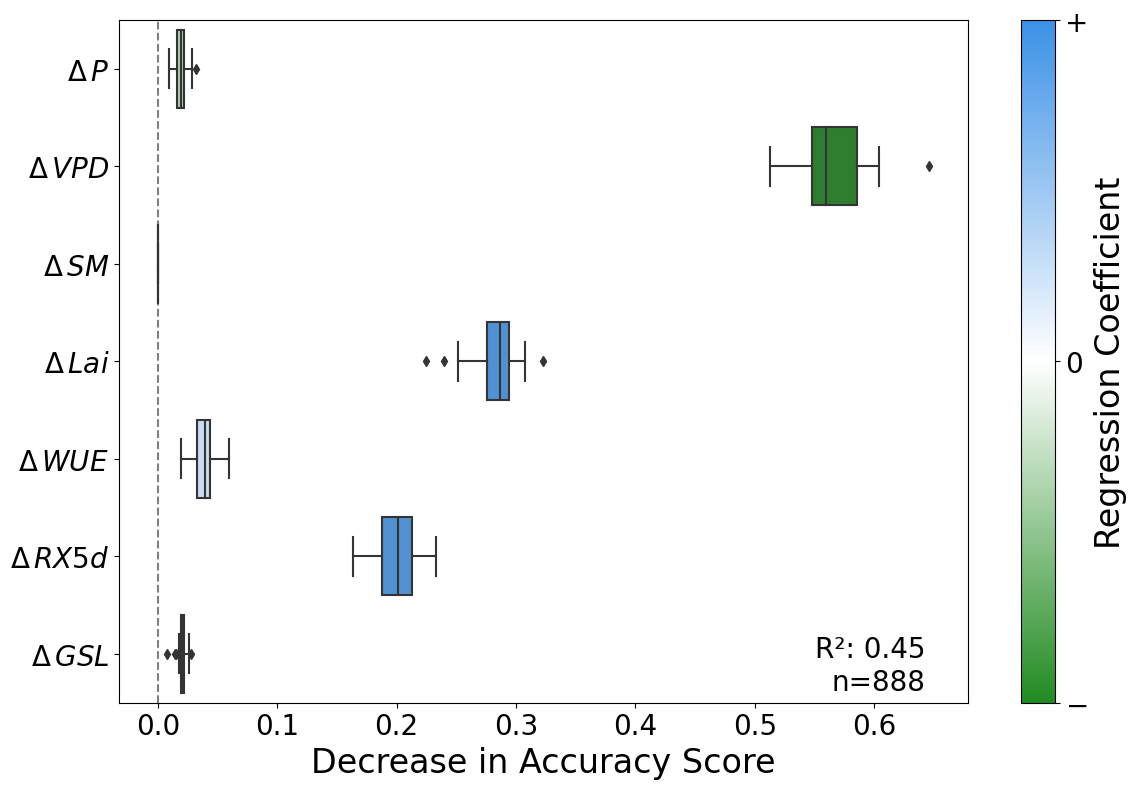

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


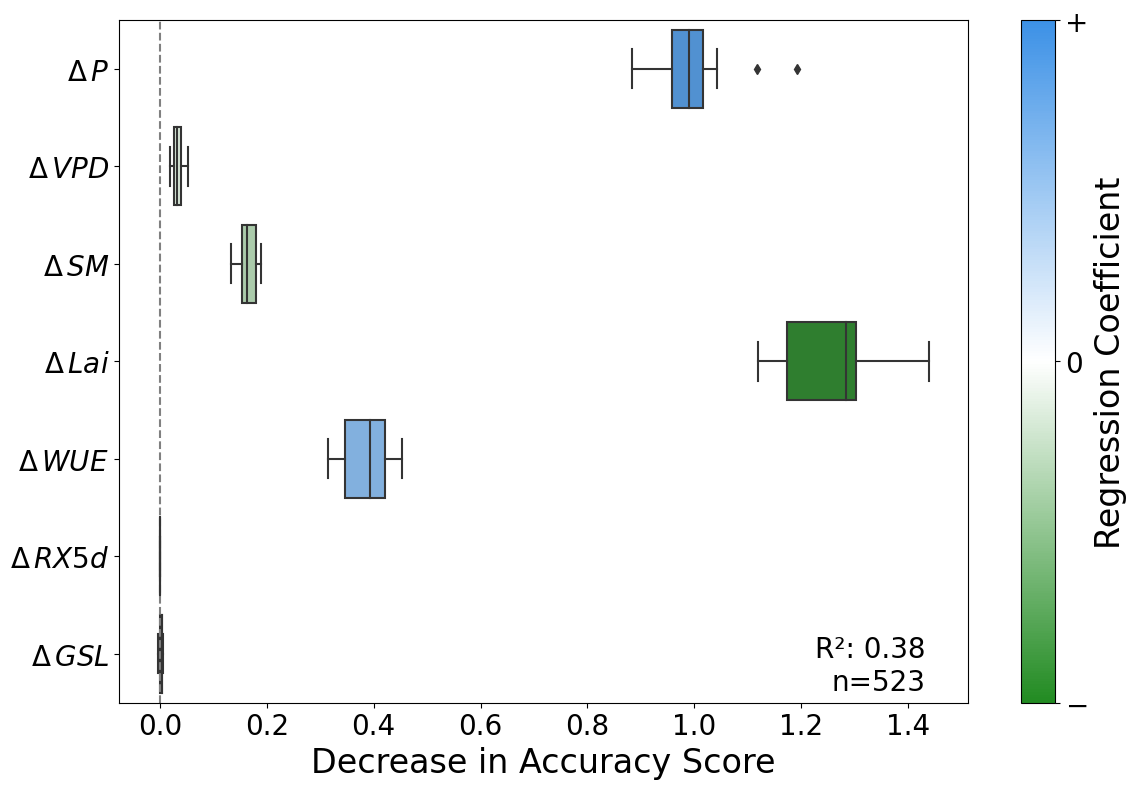

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


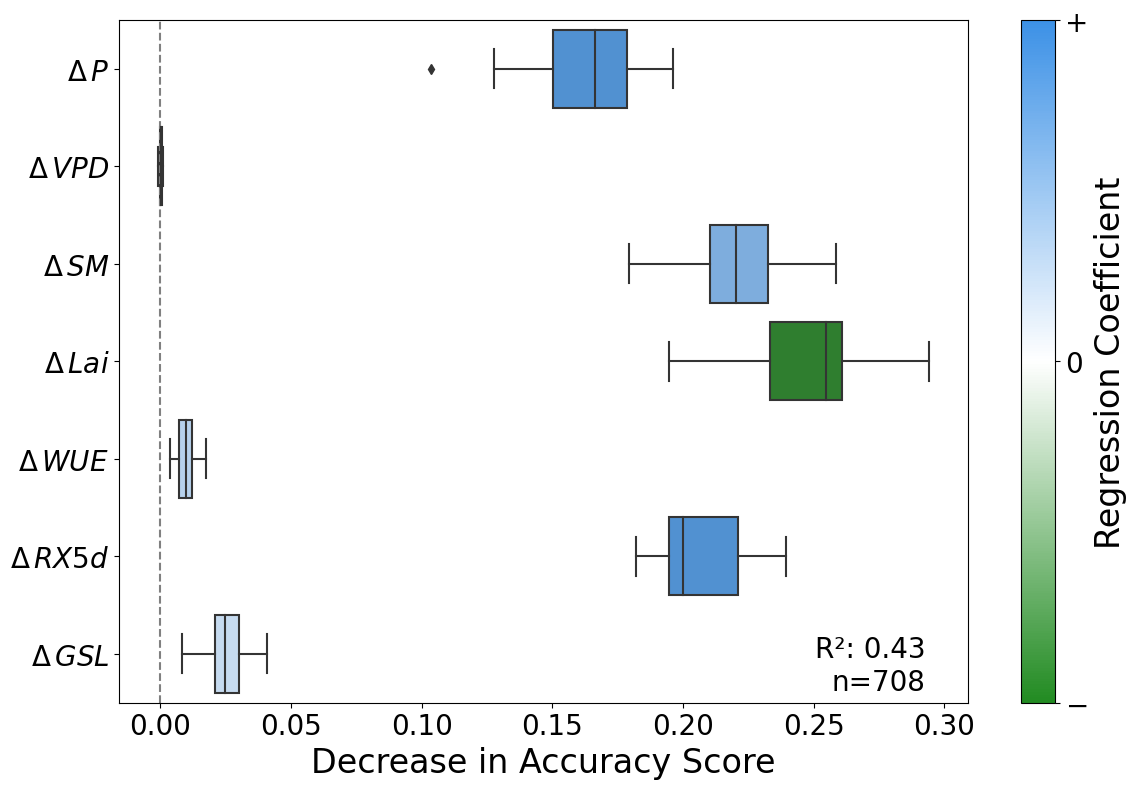

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


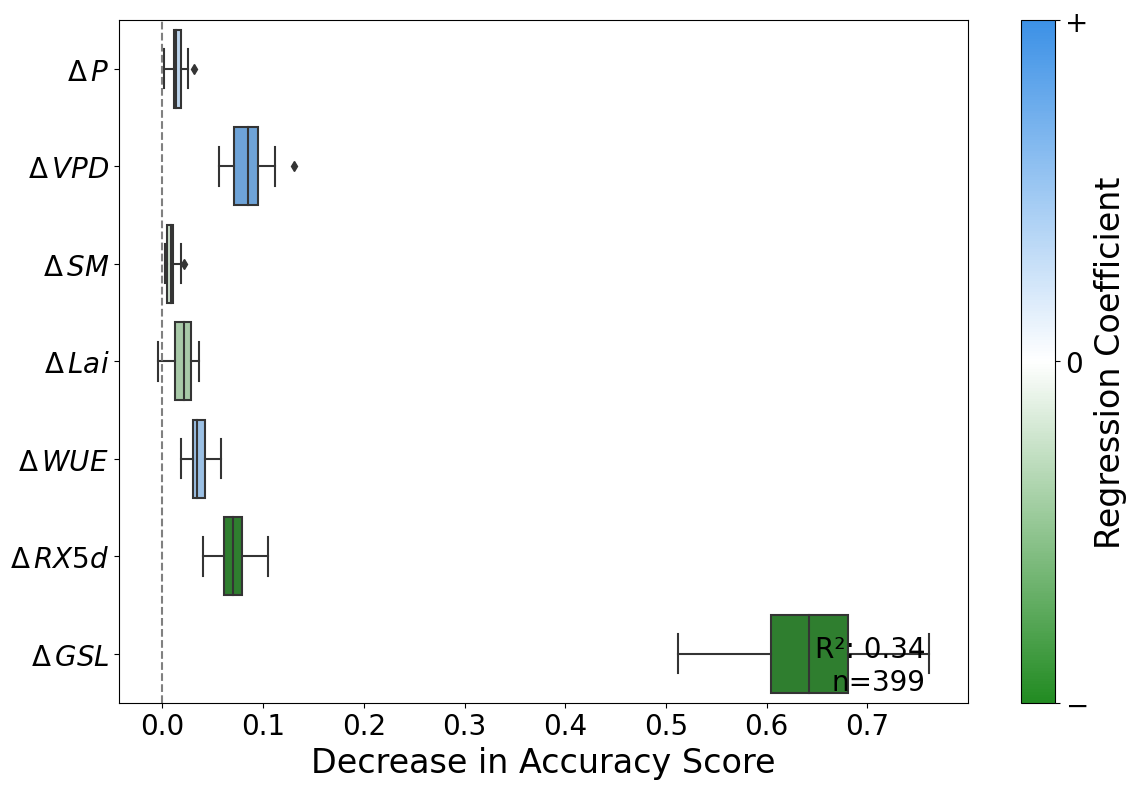

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


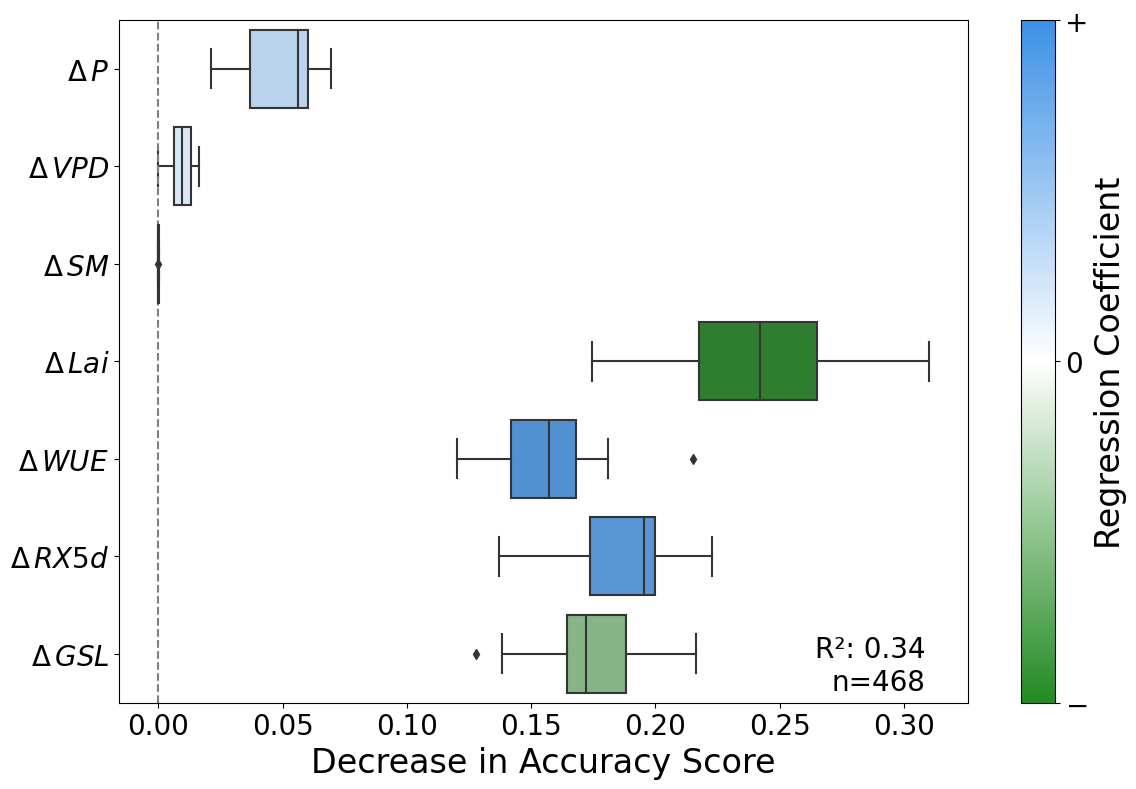

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


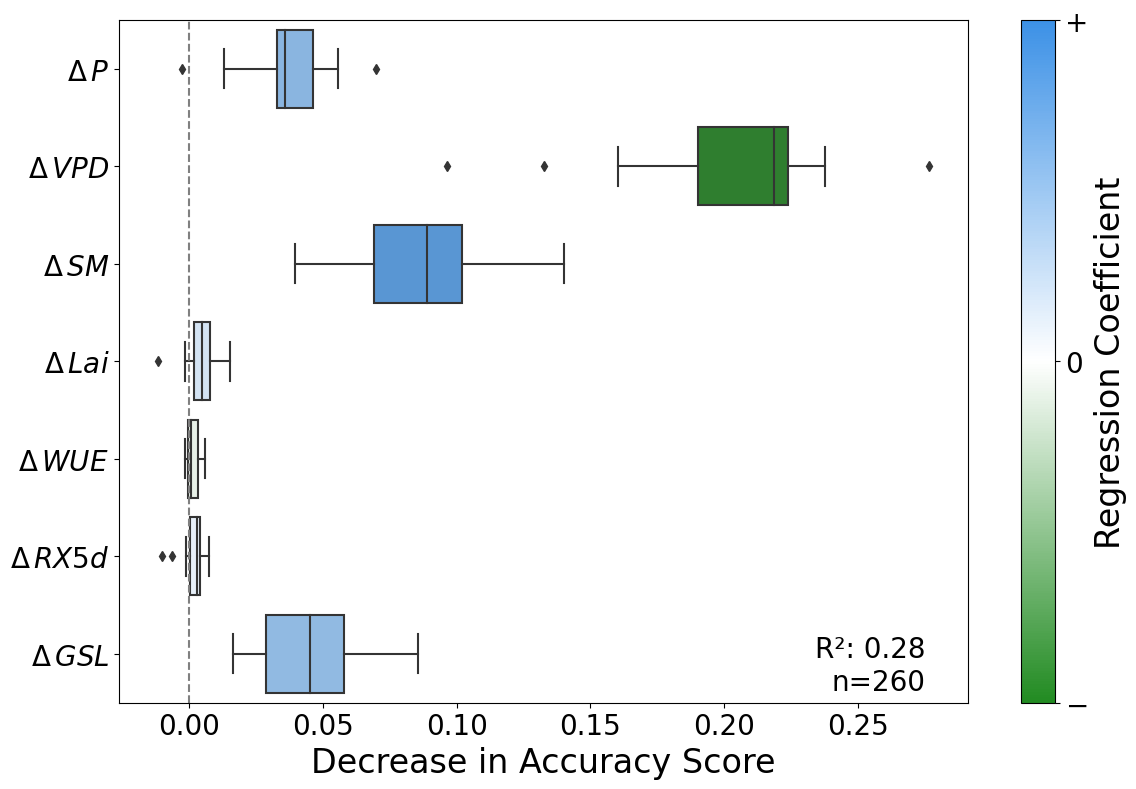

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


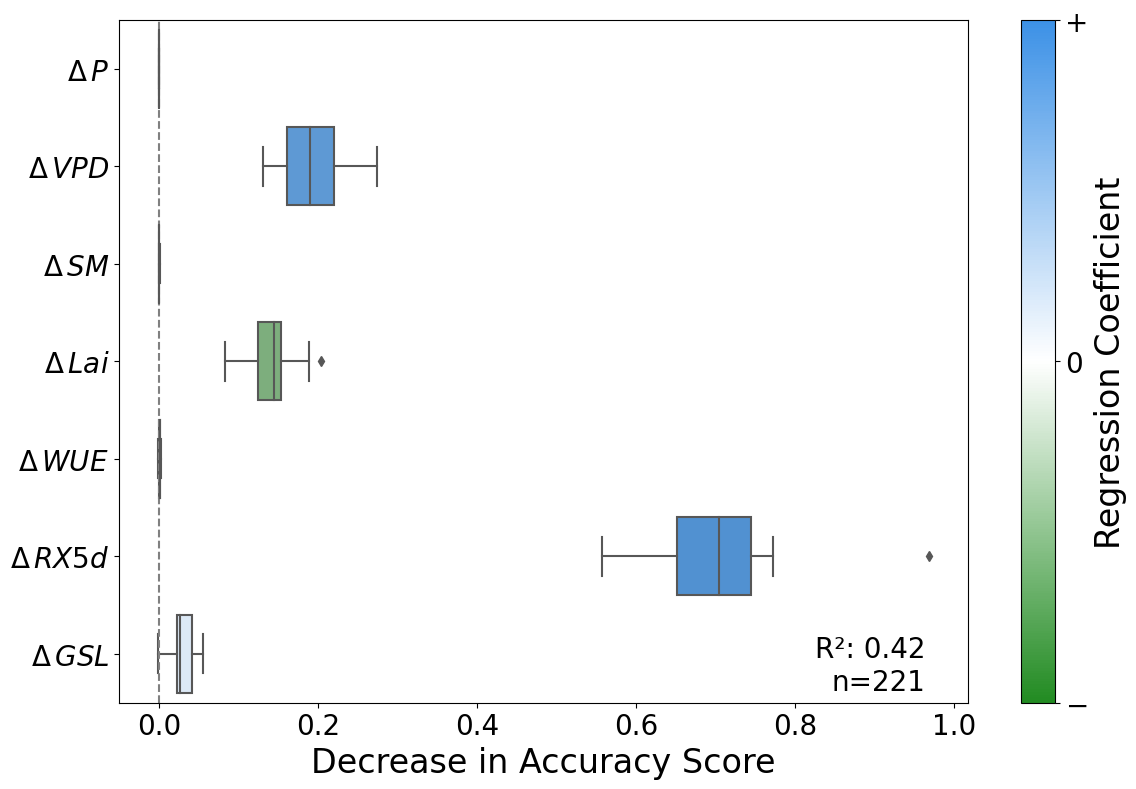

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


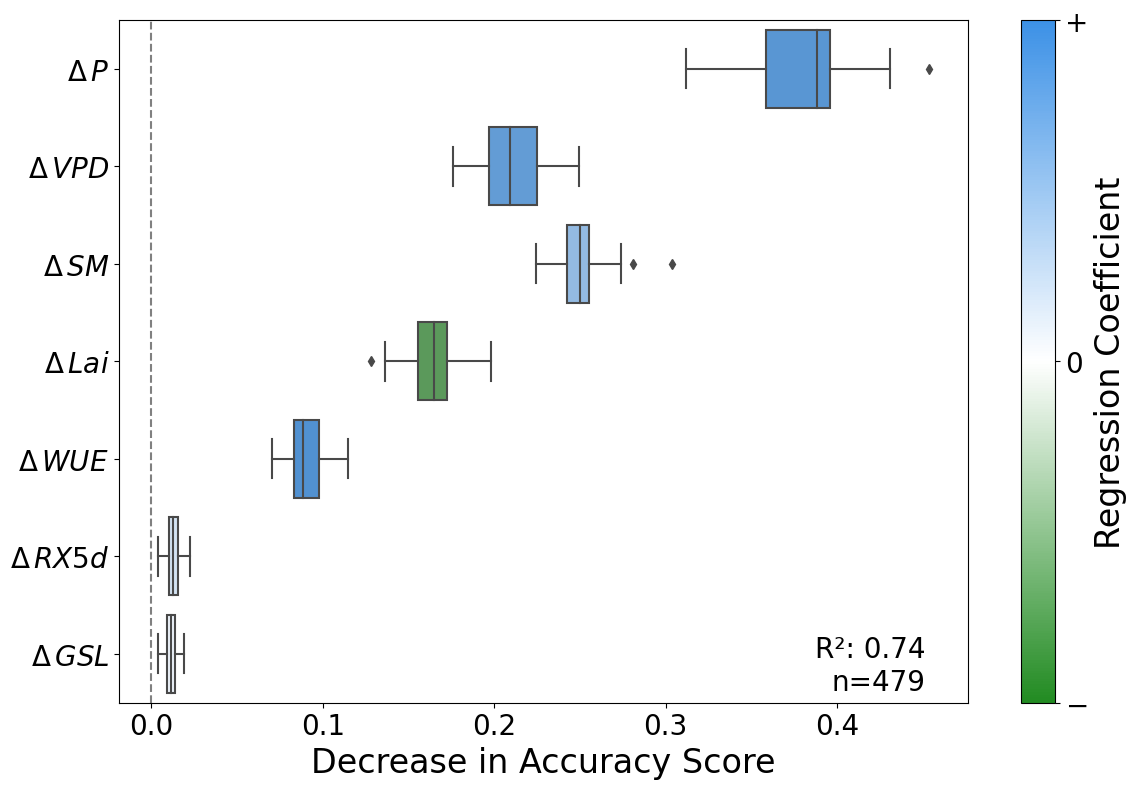

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


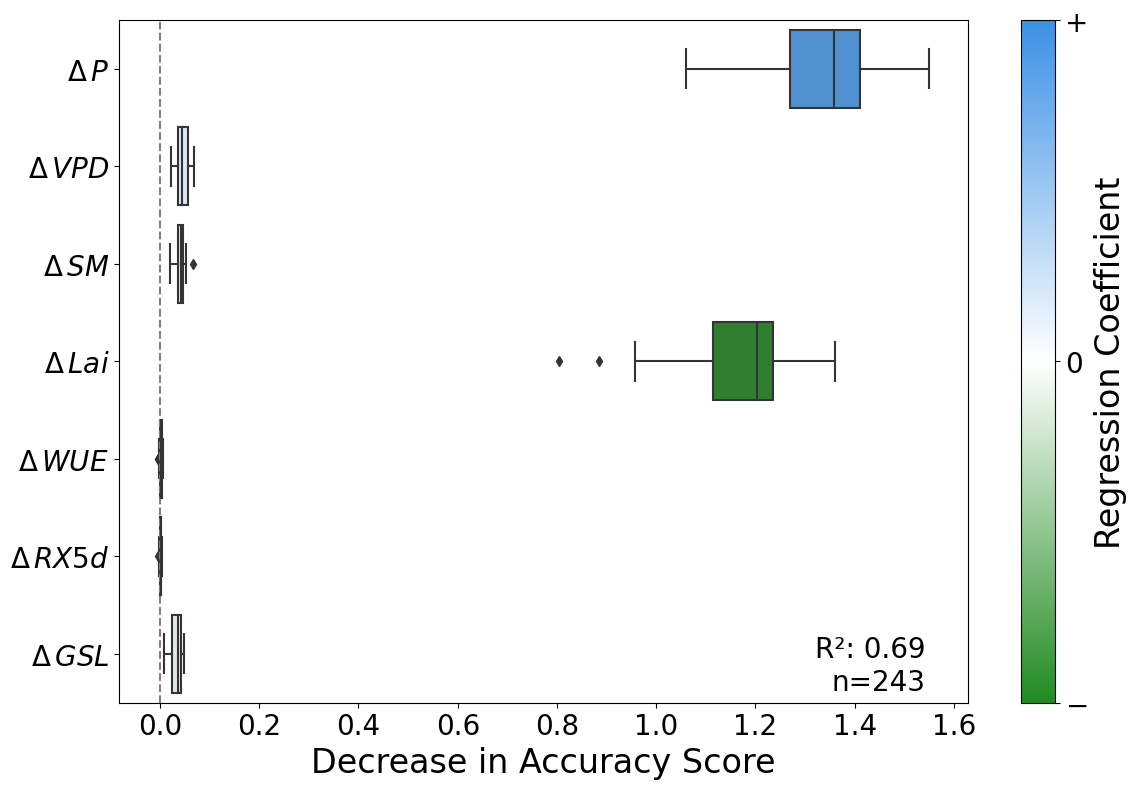

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


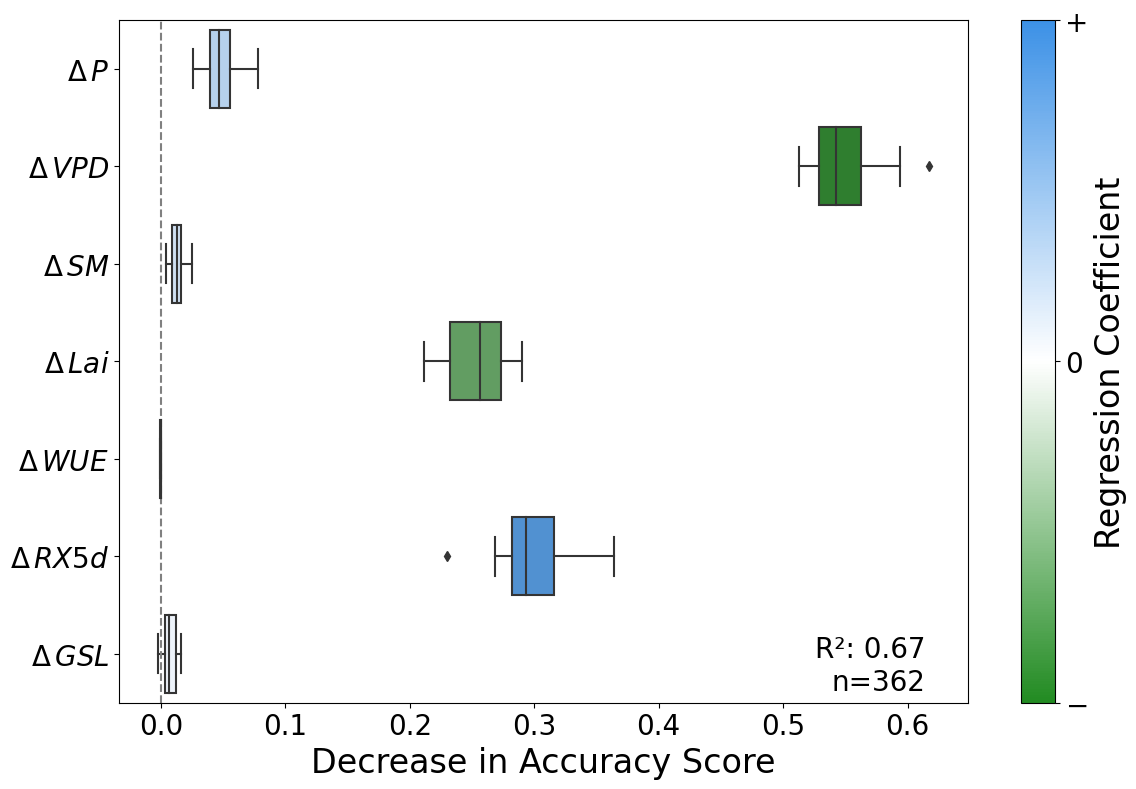

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


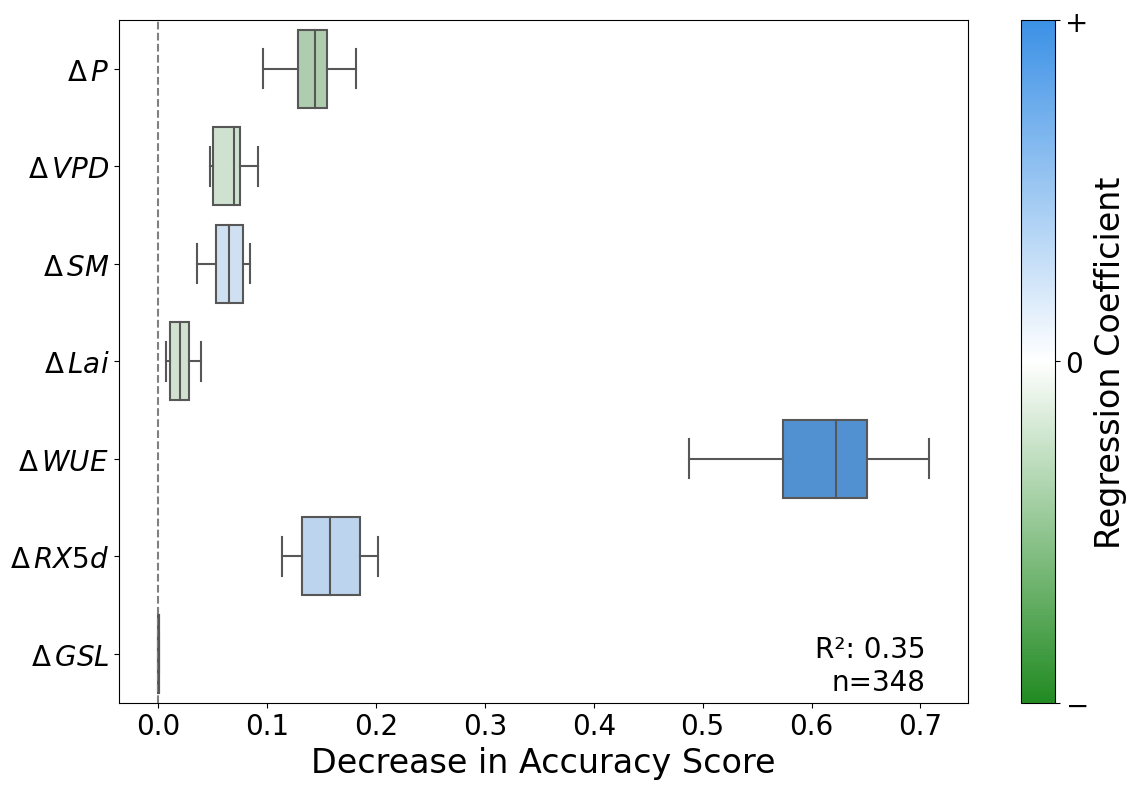

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


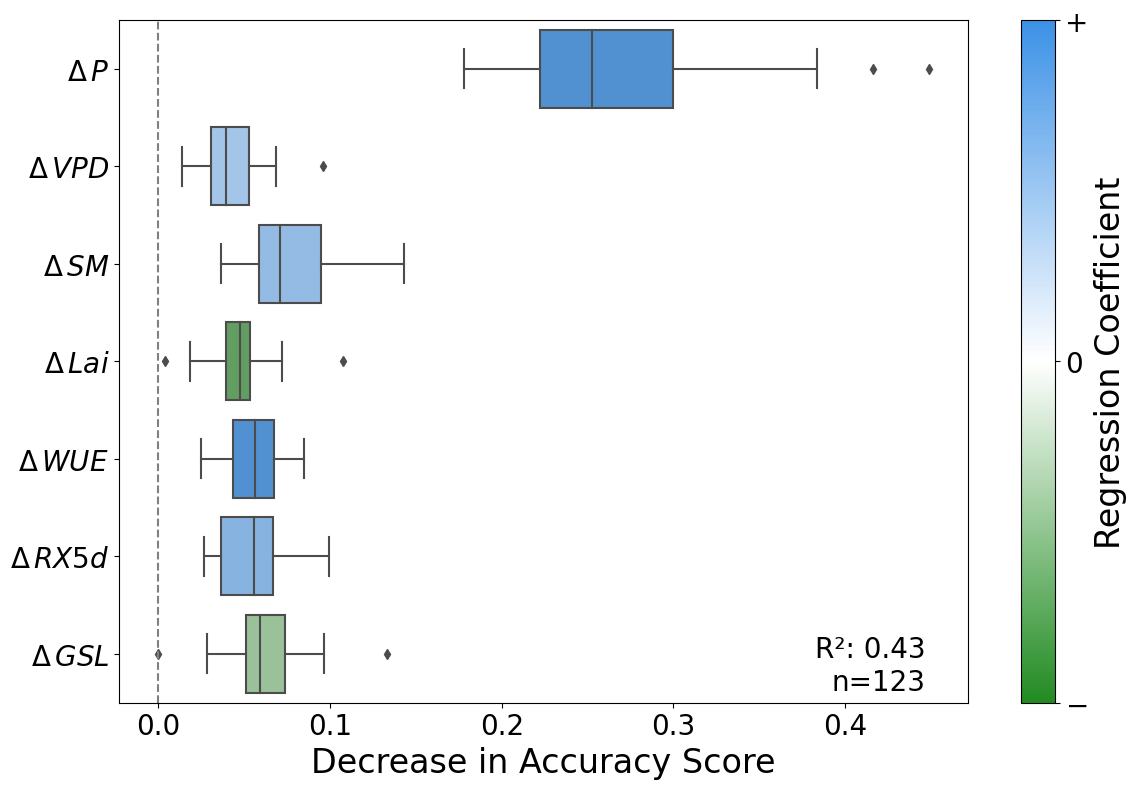

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


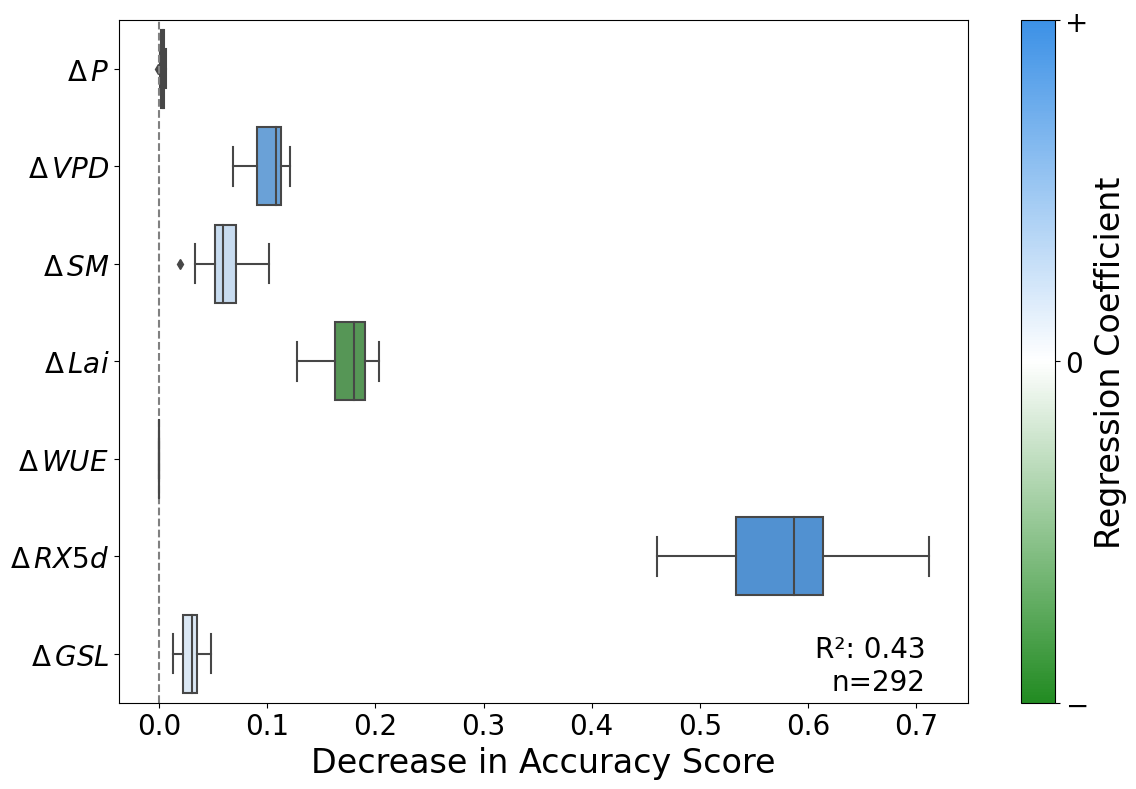

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


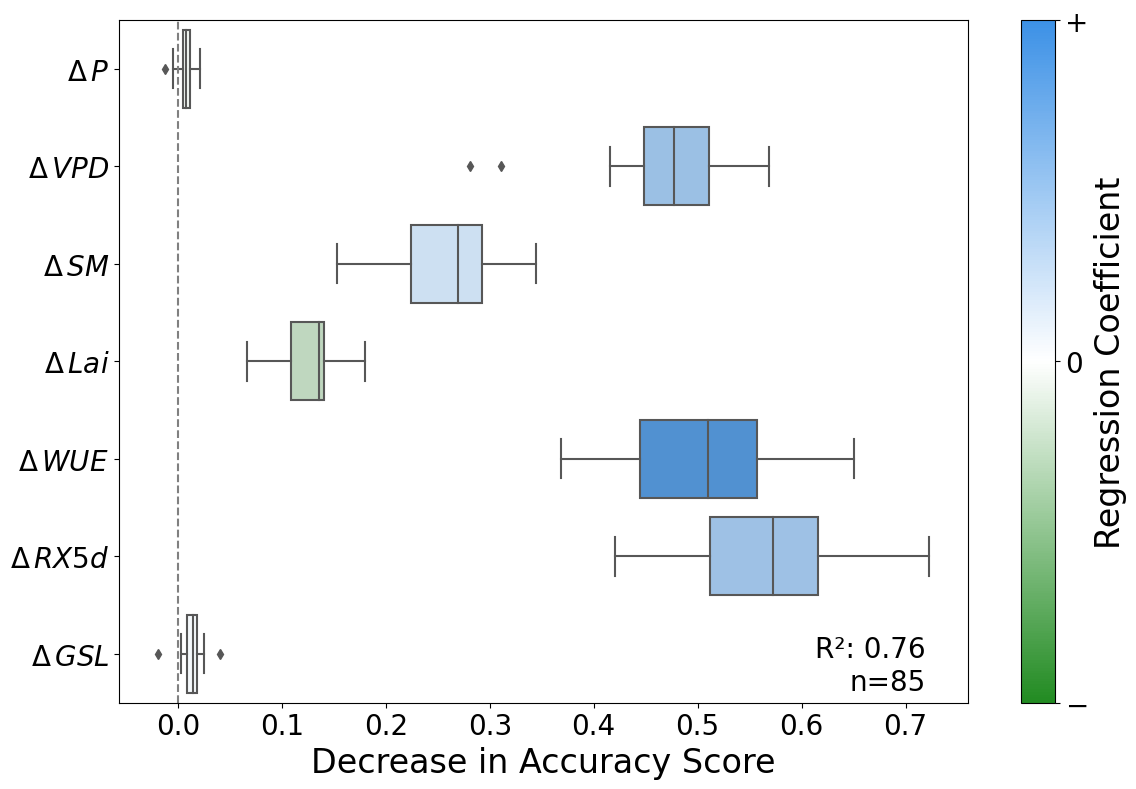

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


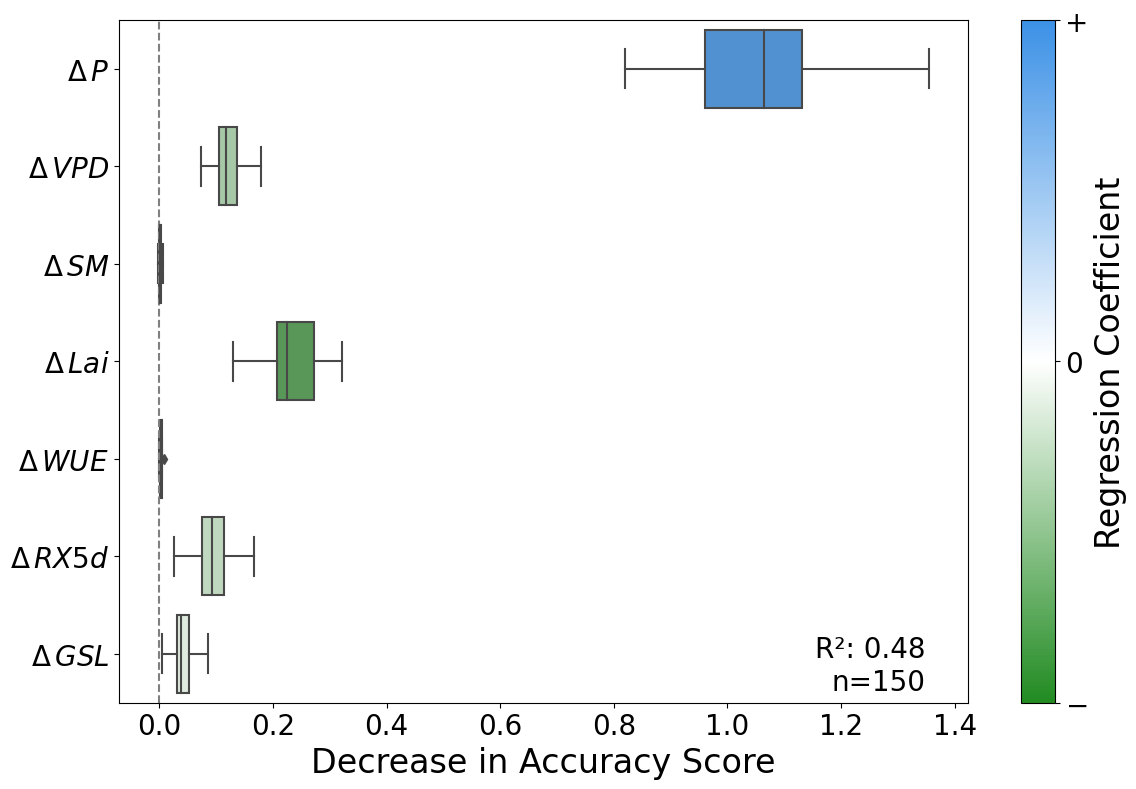

Skipping New-Zealand as it does not have variable importance data.
Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/


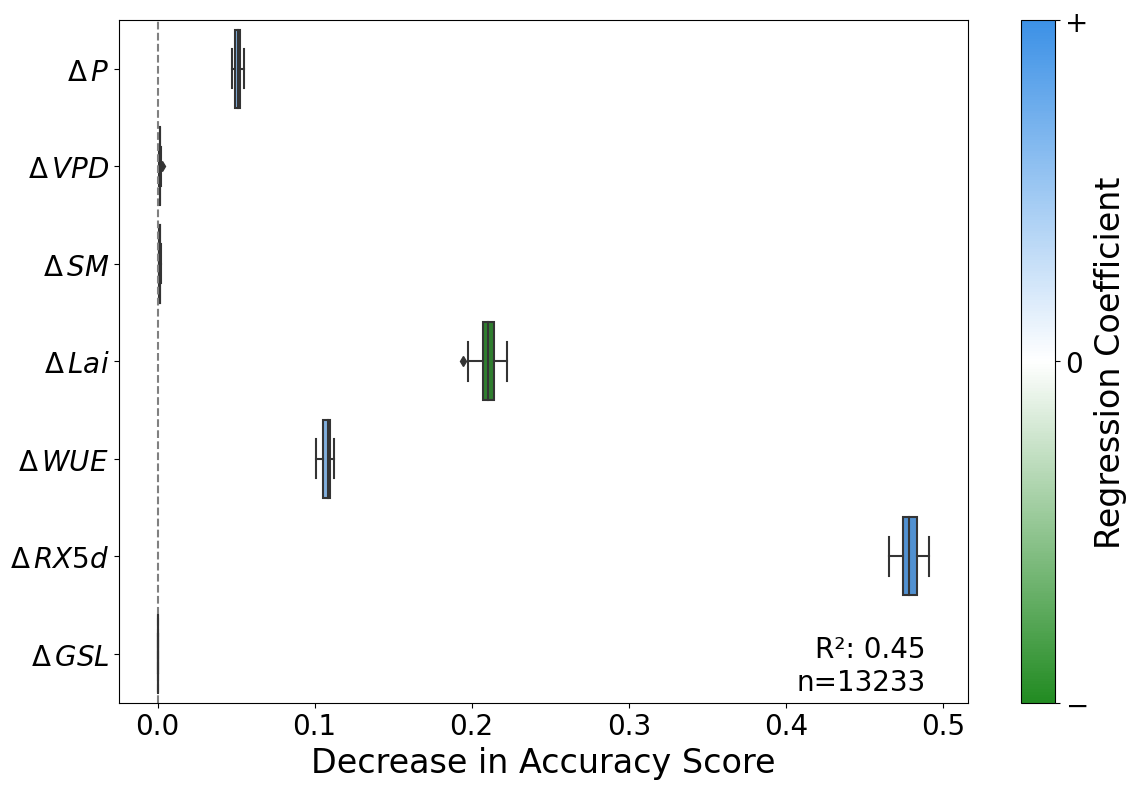

In [282]:
reg_results.plot_region_permutation_importances(
    results_regression_analysis_regions,
    predictor_vars,
    importance_type='train',
    save_path='/work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/regions/'
)

#### Subregional Regression Analysis

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

rx = ds_dict_change_region_sub['ssp370-historical']['Ensemble mean'].isel(region=-23, subdivision=1).RX5day
pr = ds_dict_change_region_sub['ssp370-historical']['Ensemble mean'].isel(region=-23, subdivision=1).pr
bgws = ds_dict_change_region_sub['ssp370-historical']['Ensemble mean'].isel(region=-23, subdivision=1).bgws

# Example arrays for RX5day and Pr change
rx5day_change = rx.values #(rx/rx.max()).values
pr_change = pr.values # (pr/pr.max()).values 
bgws_change = bgws.values 

# Flatten the data and remove NaNs
rx5day_change = rx5day_change.flatten()
rx5day_change = rx5day_change[~np.isnan(rx5day_change)]

pr_change = pr_change.flatten()  # Assuming pr_data_array is your Pr change DataArray
pr_change = pr_change[~np.isnan(pr_change)]

bgws_change = bgws_change.flatten()  # Assuming pr_data_array is your Pr change DataArray
bgws_change = bgws_change[~np.isnan(bgws_change)]

# Calculate skewness and kurtosis after removing NaNs
rx5day_skewness = skew(rx5day_change)
rx5day_kurtosis = kurtosis(rx5day_change)

pr_skewness = skew(pr_change)
pr_kurtosis = kurtosis(pr_change)

bgws_skewness = skew(bgws_change)
bgws_kurtosis = kurtosis(bgws_change)

# Print results
print(f"RX5day - Skewness: {rx5day_skewness}, Kurtosis: {rx5day_kurtosis}")
print(f"Pr Change - Skewness: {pr_skewness}, Kurtosis: {pr_kurtosis}")
print(f"BGWS Change - Skewness: {bgws_skewness}, Kurtosis: {bgws_kurtosis}")

RX5day - Skewness: 0.1486339708208345, Kurtosis: -0.7475513030283536
Pr Change - Skewness: -0.17046228715018455, Kurtosis: -0.8831864591491034
BGWS Change - Skewness: -0.3749117211084013, Kurtosis: 0.7612909232541032


In [102]:
import scipy
sm = ds_dict_change_region_sub['ssp370-historical']['Ensemble mean'].isel(region=-23, subdivision=1).mrso.values
# Flatten the data and remove NaNs
sm = sm.flatten()
sm = sm[~np.isnan(sm)]

tran = ds_dict_change_region_sub['ssp370-historical']['Ensemble mean'].isel(region=-23, subdivision=1).tran.values
# Flatten the data and remove NaNs
tran = tran.flatten()
tran = tran[~np.isnan(tran)]

scipy.stats.spearmanr(sm, tran)

In [ ]:
# Define predictors and predictant
predictor_vars = ['pr', 'vpd', 'mrso', 'lai', 'wue', 'gsl', 'RX5day']  # 'mrso','gsl', 'pr', 
predictant = 'bgws' #bgws
scaling_method = 'max' # None max std
test_size = 0.2 # Share of the dataset used as test dataset (default is 0.3)
regression_type='elasticnet' # Regression technique (tested are ridge, lasso and elasticnet)
param_grid=None # Specify parameter grid here if different one to default should be used
grid_cell_threshold=50 # Define threshold for minimum grid cells per region
cv_folds=5 # define k for cross-validation (default is 5)
scoring='r2' # Scoring metric for Cross-Validation, default is r2.
evaluation_method='test_and_cv' # Method of evaluation ('test', 'cv' or 'test_and_cv'), default is 'test'.
variable_importance_method='PI' # Method to assess variable importance SHAP or PI
n_permutations = 20 #  Number of permutations for permutation importance, default is 20.
selected_region = None  # Specific region to analyze, default is None (analyze all). Define like this [0, 1, 2] [10]
selected_subdivision = None # Specific subdivision to analyze, default is None (analyze all). 'Positive Historical BGWS' or 'Negative Historical BGWS'



# Analyze a specific region and subdivision
results_regression_analysis_regions_subdivisions = reg_analysis.regression_analysis_regions_subdivisions(
                                                             ds_dict_change_region_sub['ssp370-historical']['Ensemble mean'], 
                                                             predictor_vars, predictant, scaling_method, 
                                                             test_size, regression_type, 
                                                             param_grid, grid_cell_threshold, 
                                                             cv_folds, scoring, evaluation_method, 
                                                             variable_importance_method, n_permutations,
                                                             selected_region, selected_subdivision)

Performing regression analysis for N.W.North-America - Positive Historical BGWS
Regression analysis based on 699 grid cells
Performing regression analysis for N.W.North-America - Negative Historical BGWS
Regression analysis based on 153 grid cells
Performing regression analysis for N.E.North-America - Positive Historical BGWS
Regression analysis based on 604 grid cells
Performing regression analysis for N.E.North-America - Negative Historical BGWS
Regression analysis based on 86 grid cells
Performing regression analysis for W.North-America - Positive Historical BGWS
Regression analysis based on 172 grid cells
Performing regression analysis for W.North-America - Negative Historical BGWS
Regression analysis based on 129 grid cells
Performing regression analysis for C.North-America - Positive Historical BGWS
No regression analysis as grid cells < threshold 
Performing regression analysis for C.North-America - Negative Historical BGWS
Regression analysis based on 264 grid cells
Performing 

In [31]:
# Get mean r2
reg_results.compute_mean_r2_regions_subdivisions(results_regression_analysis_regions_subdivisions, include_global=False)

Mean R2 for Training Data: 0.60
Mean R2 for Testing Data: 0.52
Mean CV Score: 0.52


(0.597007283037423, 0.5198836553839958, 0.5154167637036405)

In [19]:
# Get mean r2
reg_results.compute_mean_r2_regions_subdivisions(results_regression_analysis_regions_subdivisions, include_global=False)

Mean R2 for Training Data: 0.59
Mean R2 for Testing Data: 0.52
Mean CV Score: 0.51


(0.5946915173051952, 0.5246869479711725, 0.5143305646234275)

In [32]:
results_regression_analysis_regions_subdivisions

{'N.W.North-America': {'Positive Historical BGWS': {'regression_model': ElasticNet(alpha=0.01, l1_ratio=0.8),
   'performance': {'R2 Train': 0.15204698854378185,
    'R2 Test': 0.12151201944786005,
    'CV Mean Score': 0.12309740087164803,
    'CV Std Dev': 0.06277163923097201},
   'variable_importance': {'SHAP Values Training Data': .values =
    array([[ 0.        , -1.17704968,  0.08365727, ..., -0.04762302,
             0.        , -0.        ],
           [ 0.        , -1.20698964,  0.03149198, ..., -0.00781496,
             0.        , -0.        ],
           [ 0.        , -0.82464468,  0.33205105, ..., -0.10061025,
             0.        , -0.        ],
           ...,
           [-0.        ,  0.04986599, -0.056421  , ..., -0.22928866,
            -0.        , -0.        ],
           [ 0.        , -0.44384403,  0.34567333, ..., -0.00548248,
             0.        ,  0.        ],
           [-0.        ,  0.02414314,  0.02502157, ..., -0.09181612,
            -0.        ,  0. 

In [20]:
reg_results.create_results_dataframe_regions_subdivisions(results_regression_analysis_regions_subdivisions,
                                                          save_dir='/work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/model_performance/',
                                                          filename='regression_model_results_regions_subregions.csv'
                                                         )

Table saved under /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/model_performance/regression_model_results_regions_subregions.csv


Region  alpha  l1_ratio     n  \
0   Negative Historical BGWS - South-American-Monsoon   0.01       0.8   162   
1        Positive Historical BGWS - S.E.South-America   0.10       0.2    56   
2   Positive Historical BGWS - South-American-Monsoon   0.10       0.8    73   
3          Positive Historical BGWS - E.North-America   0.01       0.2   272   
4          Positive Historical BGWS - S.South-America   0.10       0.8    52   
5          Negative Historical BGWS - N.South-America   0.01       0.8   269   
6        Negative Historical BGWS - N.E.South-America   0.10       0.8    66   
7        Positive Historical BGWS - N.W.South-America   0.01       0.2   126   
8        Positive Historical BGWS - N.E.South-America   0.10       0.8   135   
9        Negative Historical BGWS - W.Southern-Africa   0.01       0.5   238   
10          Negative Historical BGWS - Central-Africa   0.01       0.5   314   
11       Negative Historical BGWS - N.Central-America   0.10       0.8   145   
12             Negative Historical BGWS - E.Australia   0.01       0.2    85   
13         Negative Historical BGWS - E.North-America   0.10       0.2    67   
14         Negative Historical BGWS - C.North-America   0.01       0.2   264   
15       Negative Historical BGWS - Arabian-Peninsula   0.10       0.2   137   
16                  Positive Historical BGWS - E.Asia   0.01       0.8   306   
17               Negative Historical BGWS - E.Siberia   0.01       0.8   330   
18          Negative Historical BGWS - Western-Africa   0.01       0.2   112   
19                  Negative Historical BGWS - E.Asia   0.01       0.2   173   
20       Positive Historical BGWS - S.W.South-America   0.01       0.2    66   
21                  Positive Historical BGWS - S.Asia   0.10       0.2   208   
22       Negative Historical BGWS - N.E.North-America   0.10       0.8    86   
23                  Negative Historical BGWS - Global   0.01       0.8  6160   
24       Negative Historical BGWS - S.Central-America   0.10       0.2    51   
25                  Negative Historical BGWS - S.Asia   0.10       0.2   154   
26       Negative Historical BGWS - E.Southern-Africa   0.10       0.8   200   
27                  Positive Historical BGWS - Sahara   0.01       0.2   602   
28          Positive Historical BGWS - Western-Africa   0.01       0.8   117   
29         Positive Historical BGWS - W.North-America   0.10       0.8   172   
30        Negative Historical BGWS - N.Eastern-Africa   0.10       0.8   190   
31               Positive Historical BGWS - W.Siberia   0.01       0.2   248   
32         Negative Historical BGWS - W.North-America   0.01       0.2   129   
33               Negative Historical BGWS - W.Siberia   0.00       0.8   275   
34     Positive Historical BGWS - West&Central-Europe   0.10       0.2   138   
35                Positive Historical BGWS - E.Europe   0.00       0.2   204   
36       Positive Historical BGWS - Arabian-Peninsula   1.00       0.8   106   
37                Positive Historical BGWS - W.C.Asia   0.01       0.2   141   
38               Positive Historical BGWS - E.Siberia   0.10       0.5   378   
39                Negative Historical BGWS - E.Europe   0.01       0.8   152   
40          Positive Historical BGWS - Russian-Arctic   0.01       0.8   872   
41        Negative Historical BGWS - S.Eastern-Africa   0.10       0.8   119   
42       Negative Historical BGWS - N.W.North-America   0.01       0.8   153   
43         Positive Historical BGWS - Tibetan-Plateau   0.10       0.8   188   
44             Negative Historical BGWS - C.Australia   0.01       0.8   290   
45       Positive Historical BGWS - N.E.North-America   0.01       0.2   604   
46                  Negative Historical BGWS - Sahara   0.10       0.8   199   
47             Negative Historical BGWS - N.Australia   0.10       0.2    93   
48                Negative Historical BGWS - W.C.Asia   0.10       0.2   327   
49                  Positive Historical BGWS - 

In [ ]:
importlib.reload(reg_results)

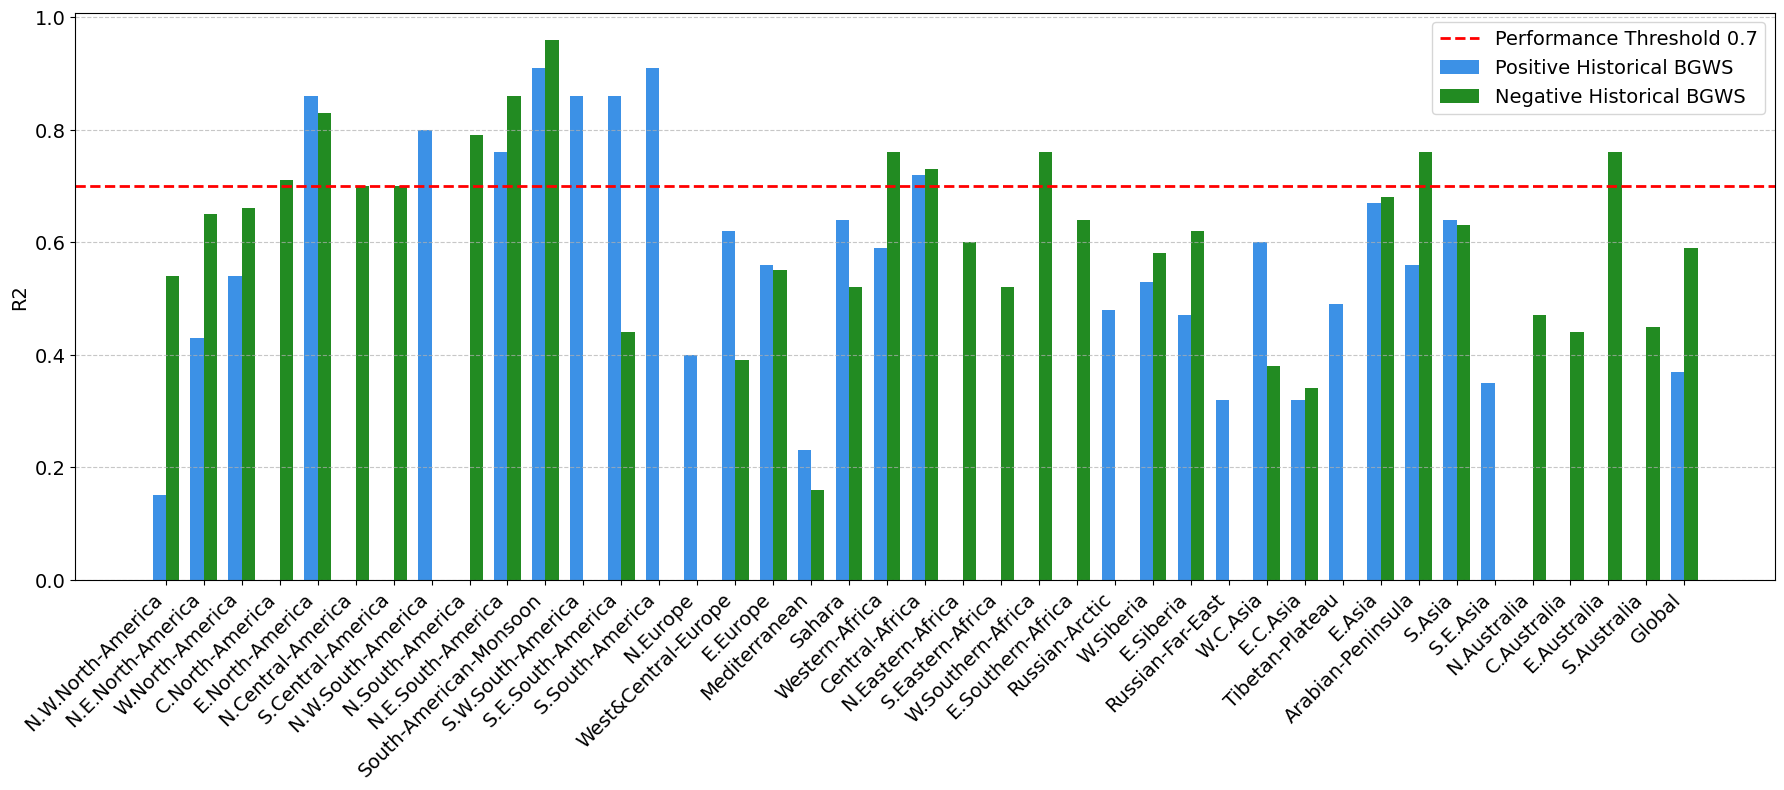

In [93]:
reg_results.plot_performance_scores_regions_subdivisions(results_regression_analysis_regions_subdivisions, score_type=scoring, plot_type='train'
                    ,save_path='/work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/model_performance/')

#### Subregional Driver Analysis

In [30]:
# Reload function if changes have been applied
importlib.reload(reg_results)

<module 'regression_analysis_results' from '/work/ch0636/g300115/phd_project/common/src/visualization/regression_analysis_results.py'>

In [ ]:
reg_results.plot_region_subdivision_permutation_importances(
    results_regression_analysis_regions_subdivisions,
    predictor_vars,
    importance_type='train',
    save_path='/work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/permutation_importance/subregions/'
)

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/N.W.North_America___Positive_Historical_BGWS_train_violin.pdf


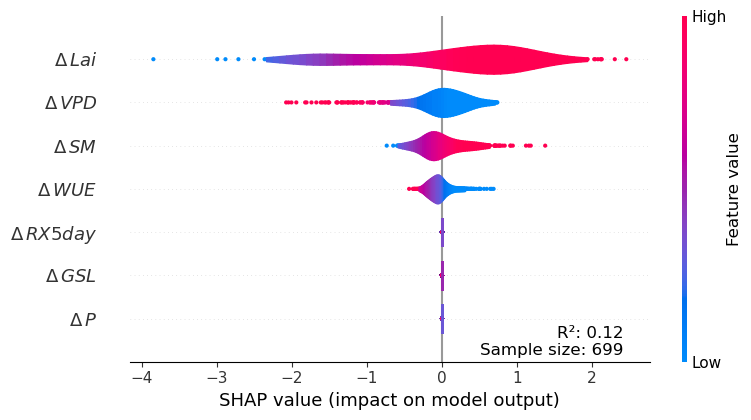

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/N.W.North_America___Negative_Historical_BGWS_train_violin.pdf


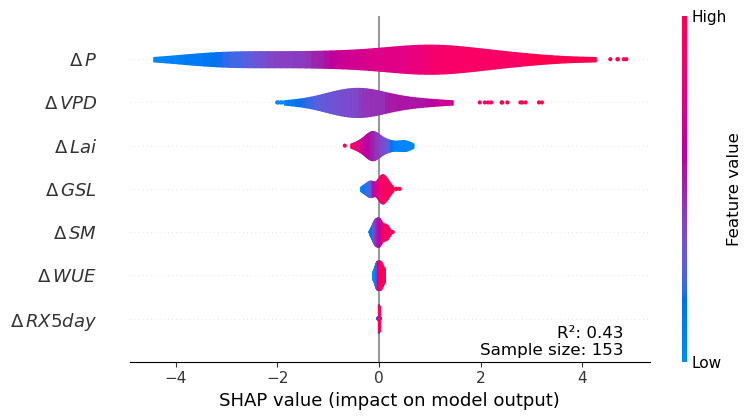

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/N.E.North_America___Positive_Historical_BGWS_train_violin.pdf


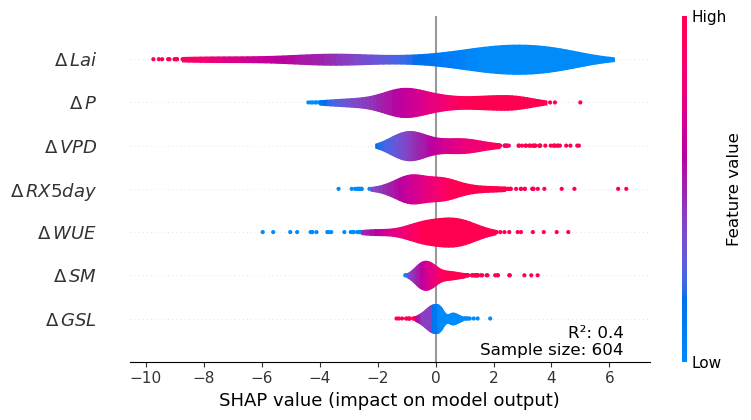

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/N.E.North_America___Negative_Historical_BGWS_train_violin.pdf


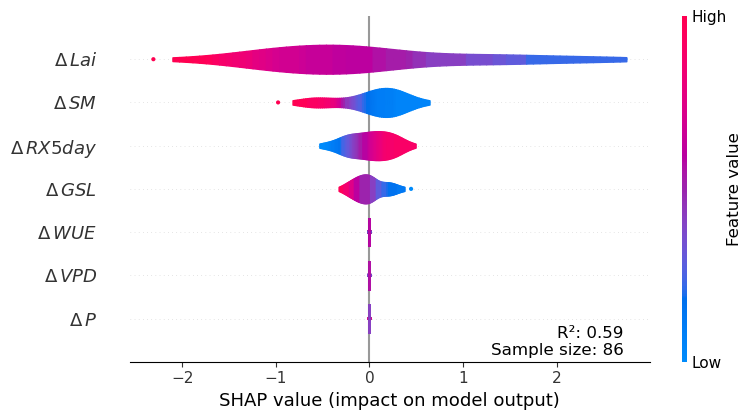

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/W.North_America___Positive_Historical_BGWS_train_violin.pdf


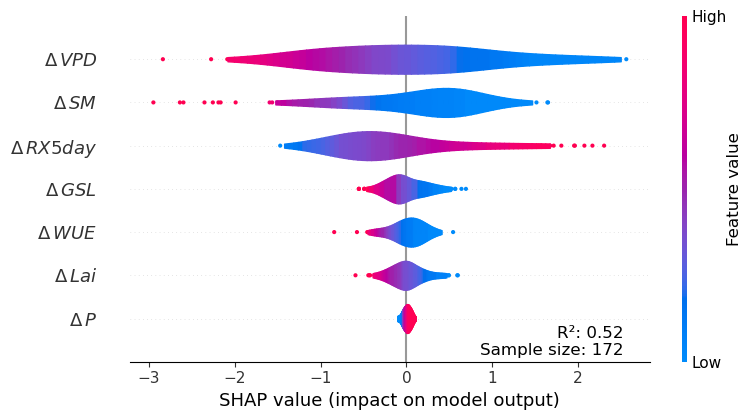

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/W.North_America___Negative_Historical_BGWS_train_violin.pdf


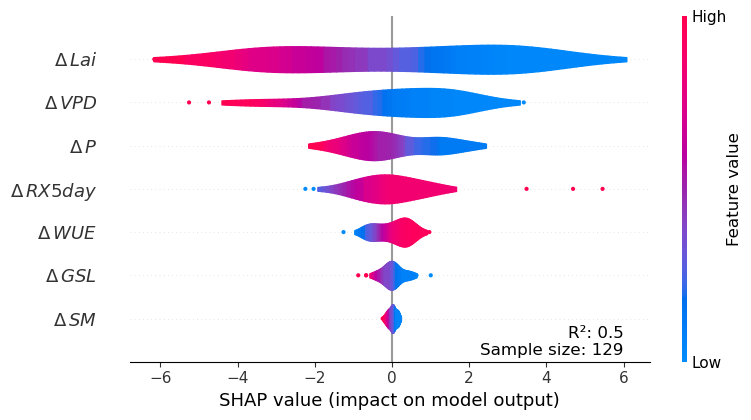

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/C.North_America___Negative_Historical_BGWS_train_violin.pdf


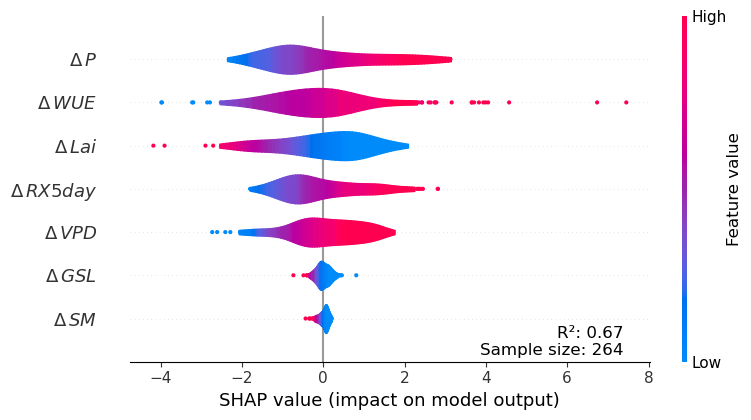

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/E.North_America___Positive_Historical_BGWS_train_violin.pdf


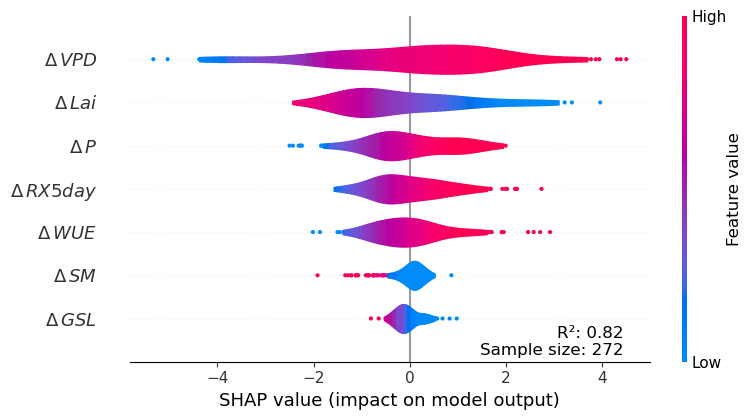

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/E.North_America___Negative_Historical_BGWS_train_violin.pdf


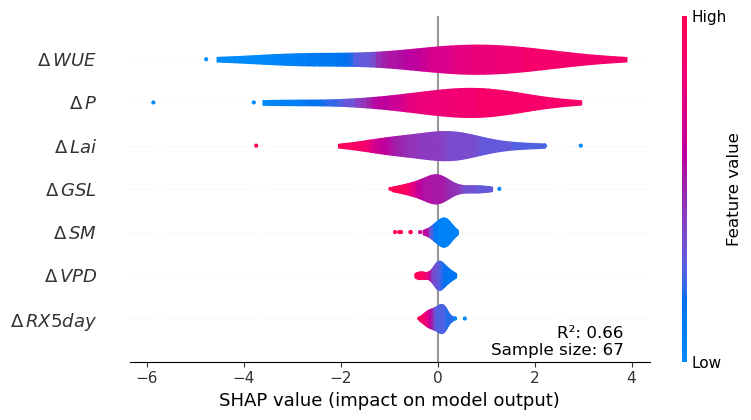

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/N.Central_America___Negative_Historical_BGWS_train_violin.pdf


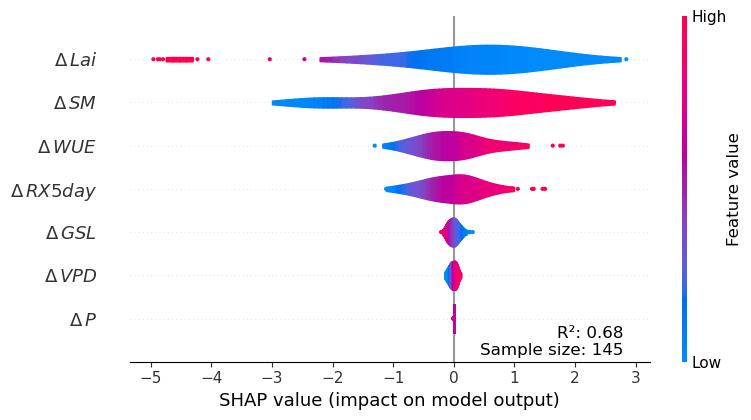

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/S.Central_America___Negative_Historical_BGWS_train_violin.pdf


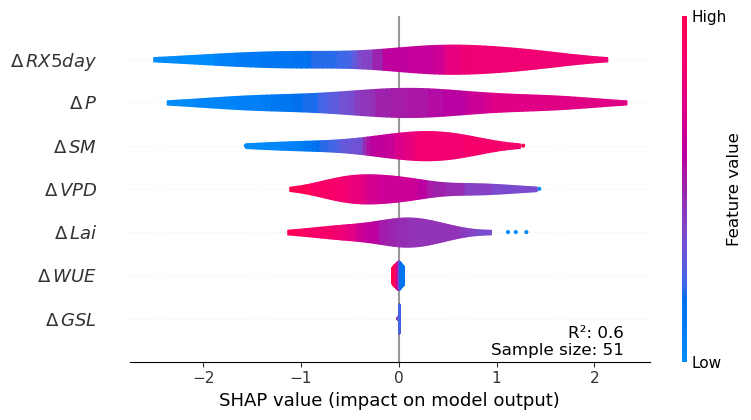

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/N.W.South_America___Positive_Historical_BGWS_train_violin.pdf


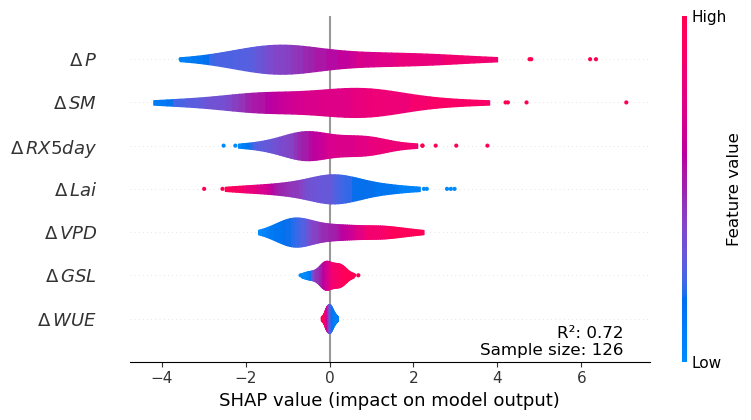

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/N.South_America___Negative_Historical_BGWS_train_violin.pdf


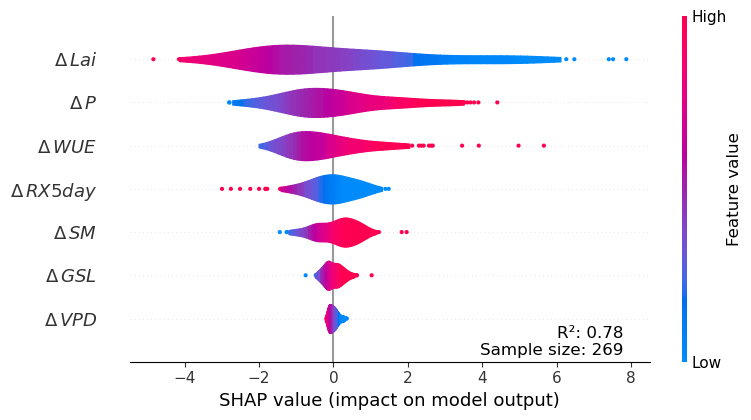

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/N.E.South_America___Positive_Historical_BGWS_train_violin.pdf


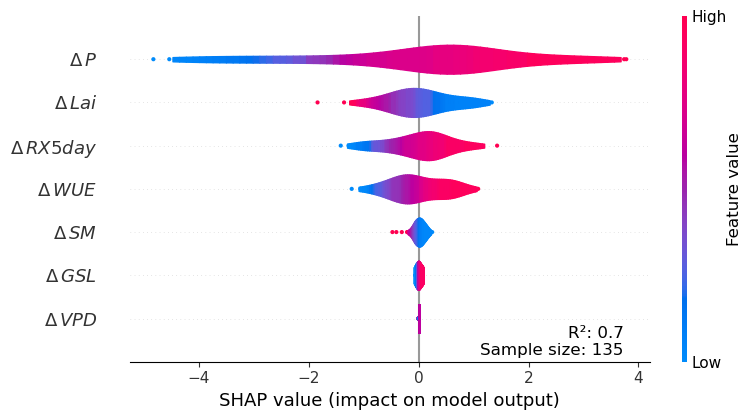

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/N.E.South_America___Negative_Historical_BGWS_train_violin.pdf


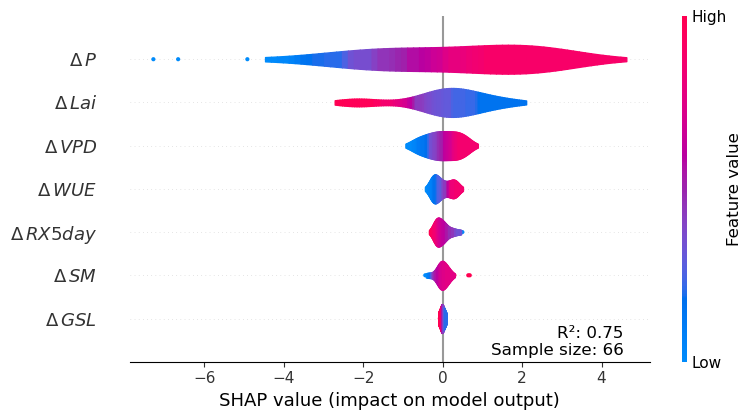

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/South_American_Monsoon___Positive_Historical_BGWS_train_violin.pdf


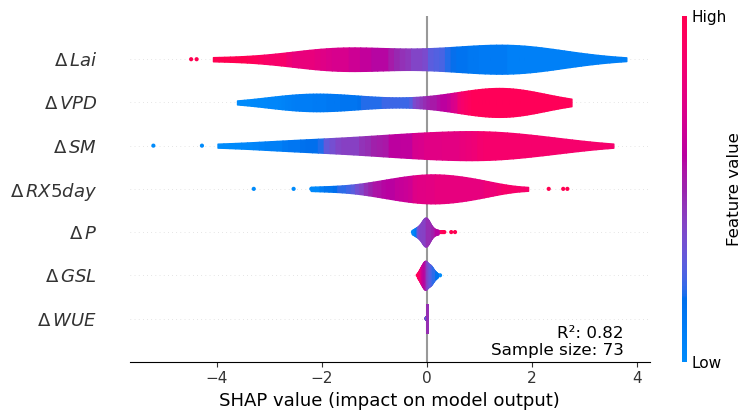

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/South_American_Monsoon___Negative_Historical_BGWS_train_violin.pdf


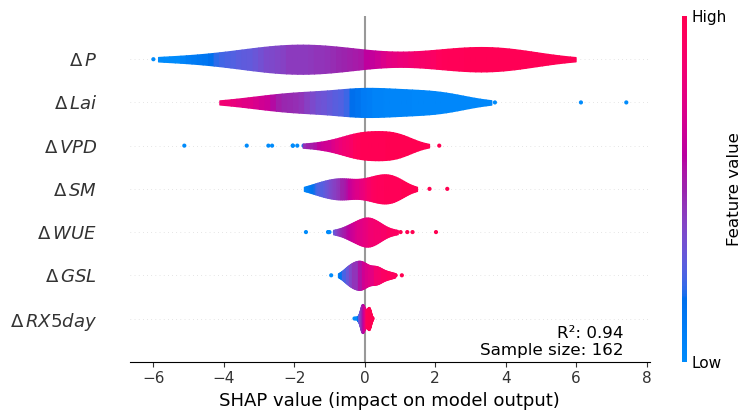

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/S.W.South_America___Positive_Historical_BGWS_train_violin.pdf


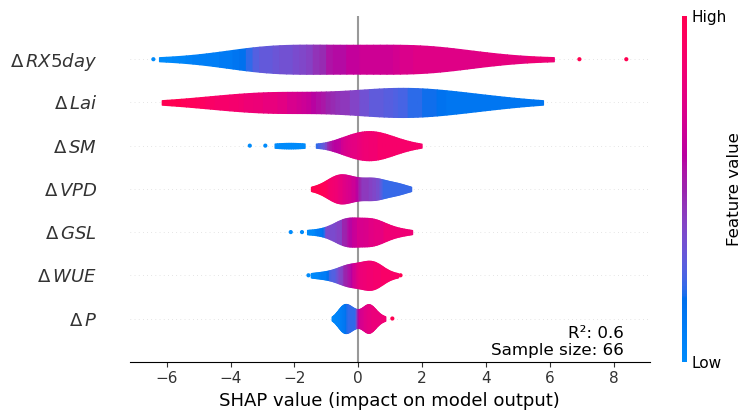

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/S.E.South_America___Positive_Historical_BGWS_train_violin.pdf


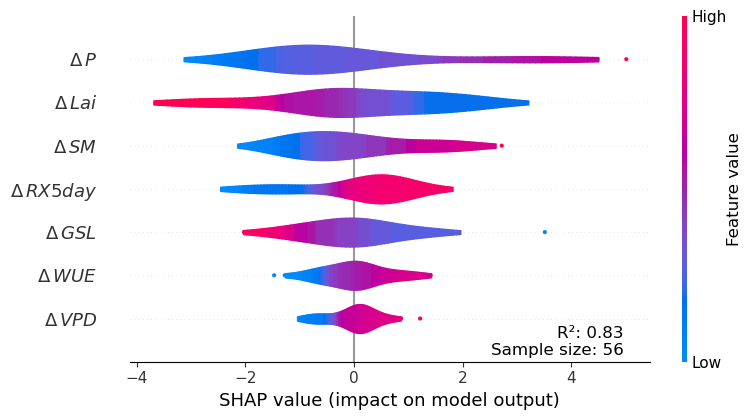

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/S.E.South_America___Negative_Historical_BGWS_train_violin.pdf


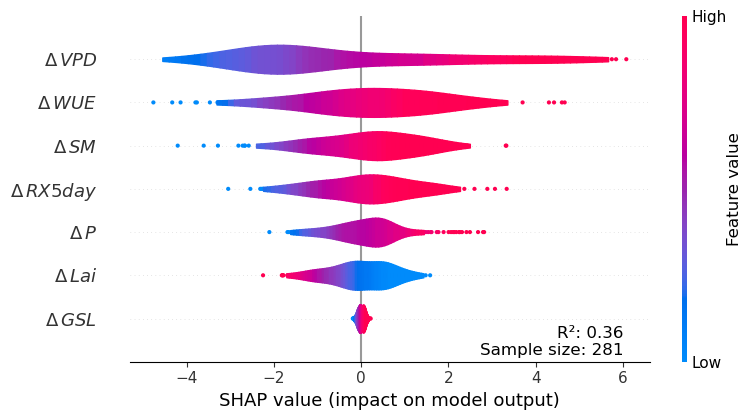

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/S.South_America___Positive_Historical_BGWS_train_violin.pdf


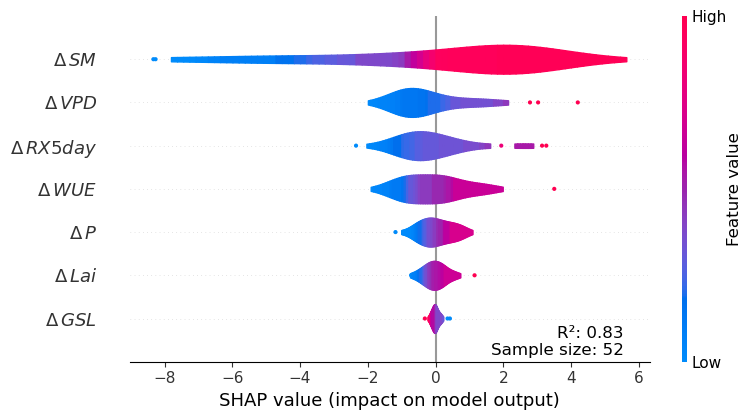

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/N.Europe___Positive_Historical_BGWS_train_violin.pdf


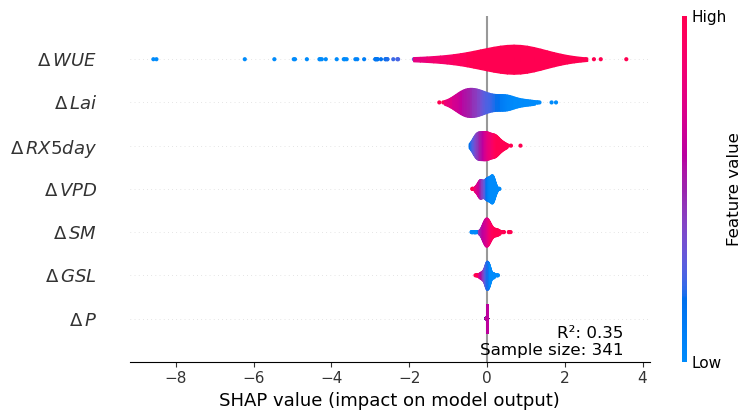

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/West&Central_Europe___Positive_Historical_BGWS_train_violin.pdf


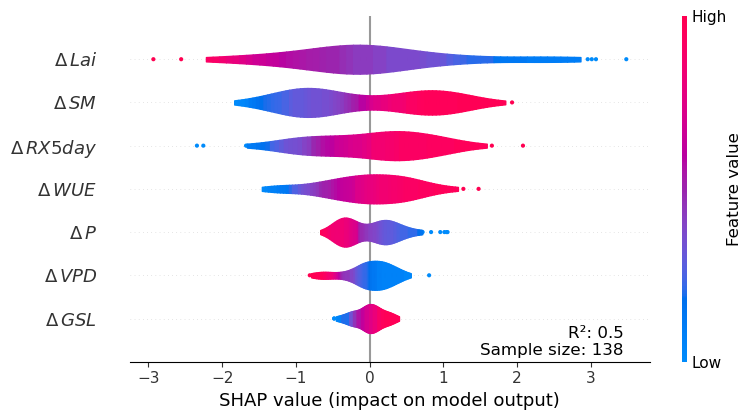

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/West&Central_Europe___Negative_Historical_BGWS_train_violin.pdf


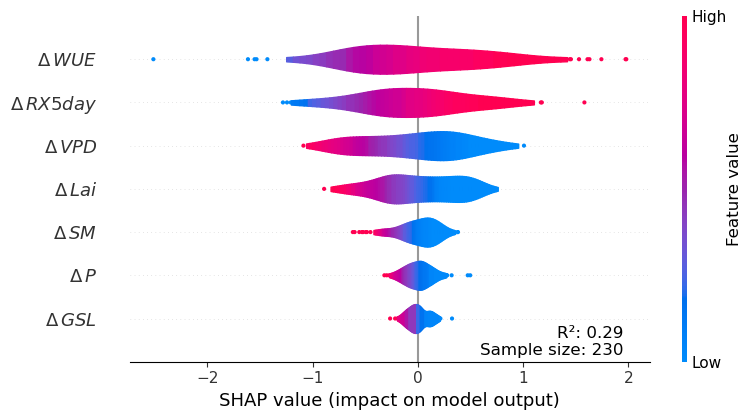

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/E.Europe___Positive_Historical_BGWS_train_violin.pdf


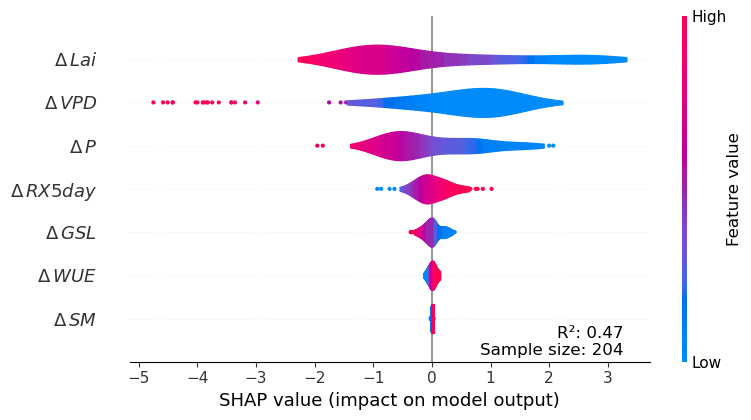

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/E.Europe___Negative_Historical_BGWS_train_violin.pdf


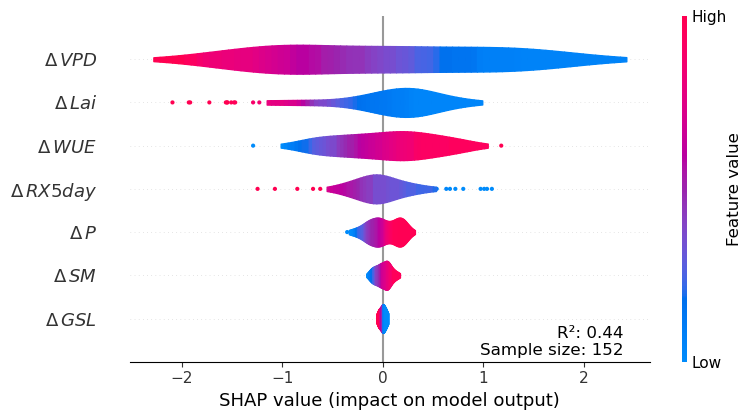

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/Mediterranean___Positive_Historical_BGWS_train_violin.pdf


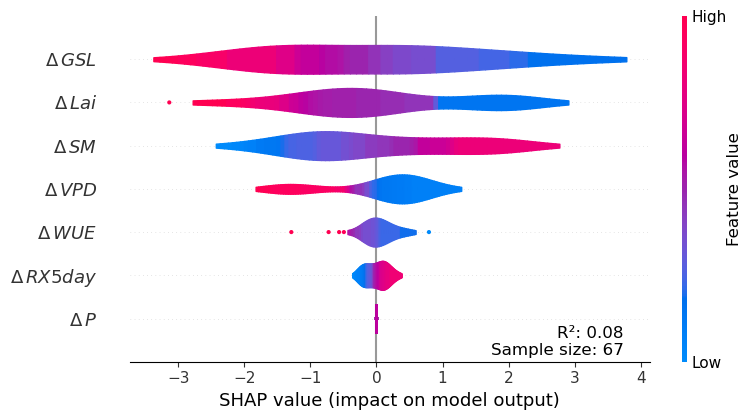

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/Mediterranean___Negative_Historical_BGWS_train_violin.pdf


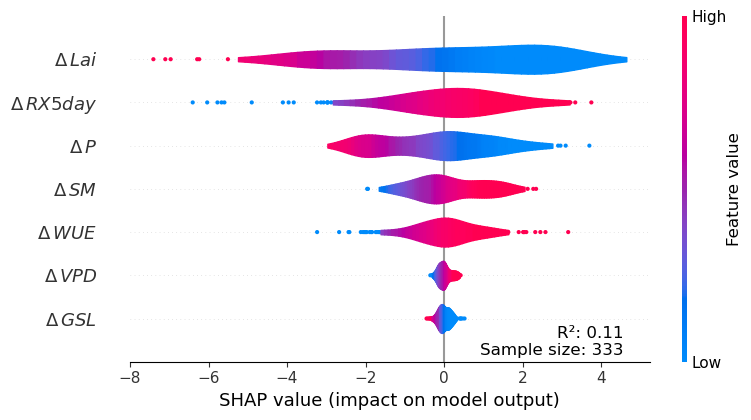

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/Sahara___Positive_Historical_BGWS_train_violin.pdf


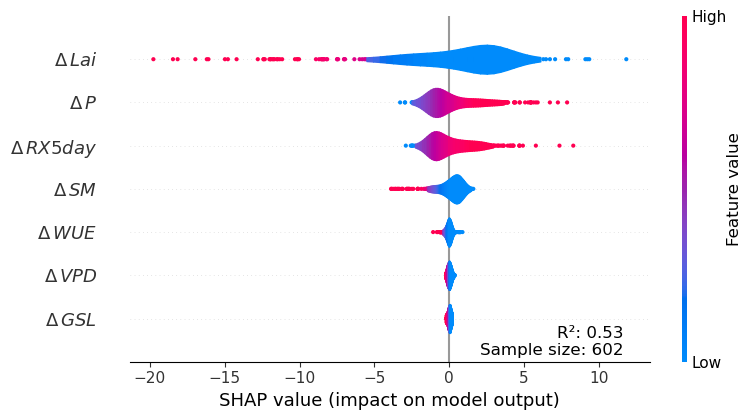

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/Sahara___Negative_Historical_BGWS_train_violin.pdf


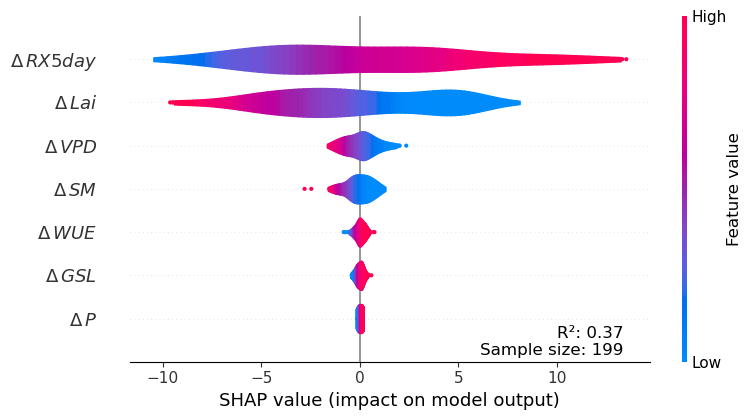

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/Western_Africa___Positive_Historical_BGWS_train_violin.pdf


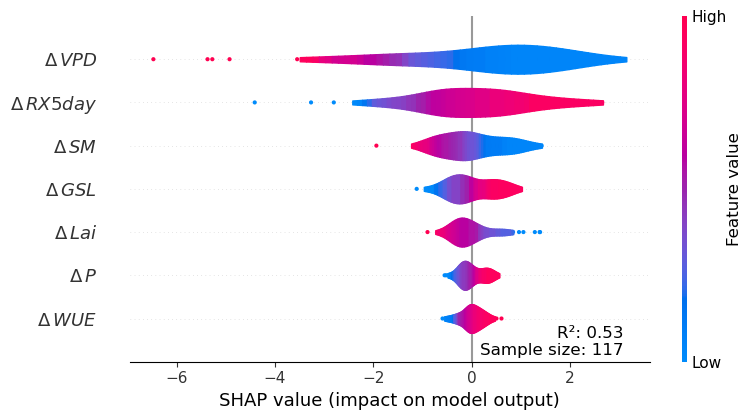

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/Western_Africa___Negative_Historical_BGWS_train_violin.pdf


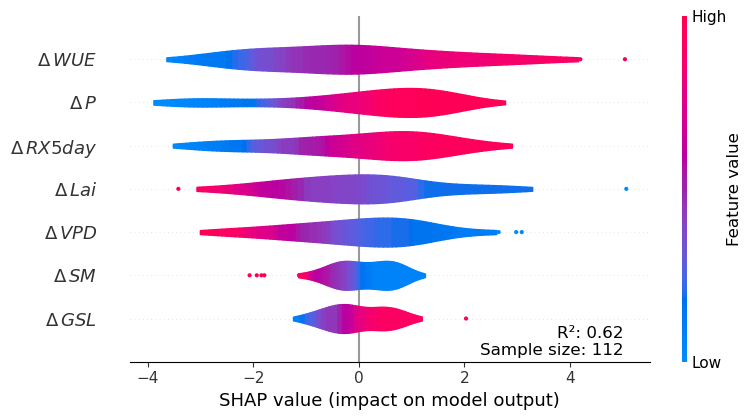

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/Central_Africa___Positive_Historical_BGWS_train_violin.pdf


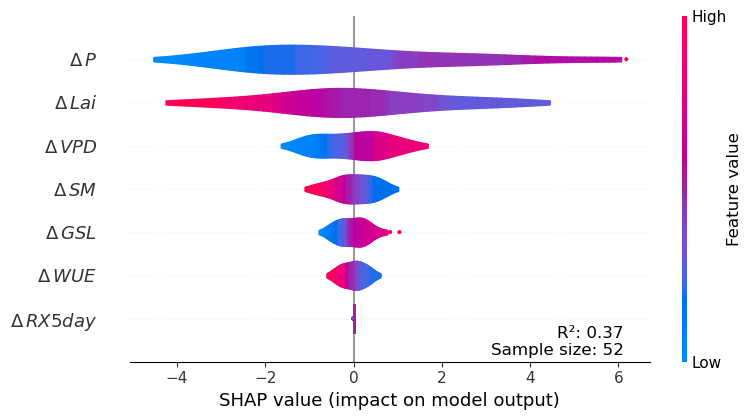

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/Central_Africa___Negative_Historical_BGWS_train_violin.pdf


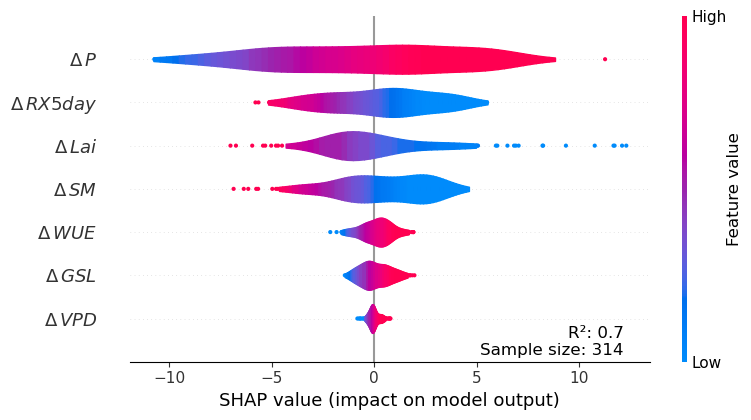

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/N.Eastern_Africa___Negative_Historical_BGWS_train_violin.pdf


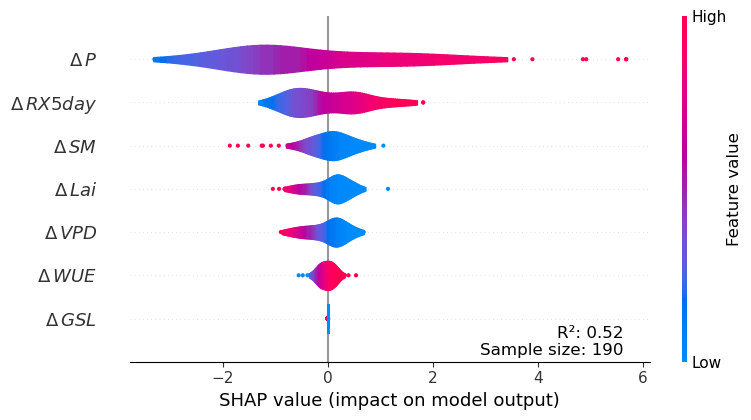

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/S.Eastern_Africa___Negative_Historical_BGWS_train_violin.pdf


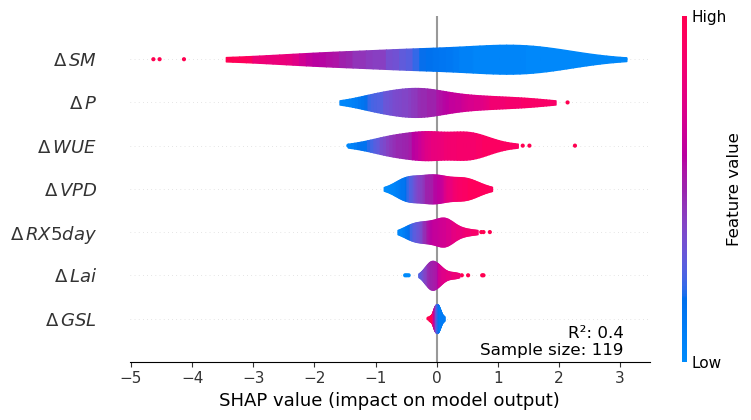

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/W.Southern_Africa___Negative_Historical_BGWS_train_violin.pdf


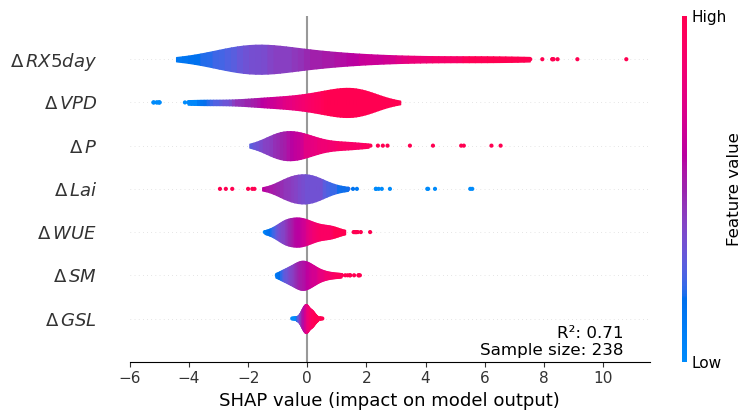

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/E.Southern_Africa___Negative_Historical_BGWS_train_violin.pdf


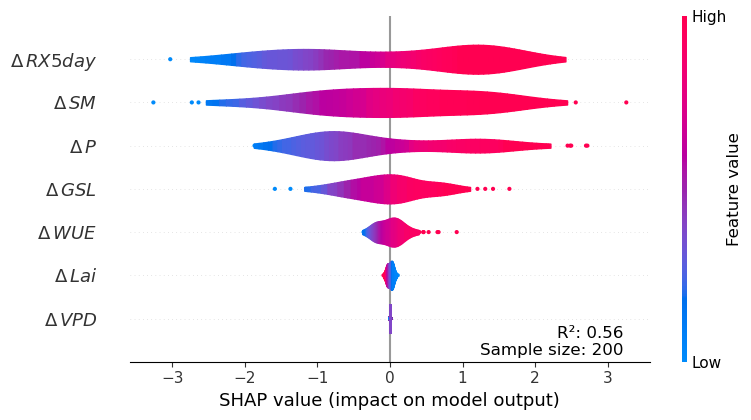

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/Russian_Arctic___Positive_Historical_BGWS_train_violin.pdf


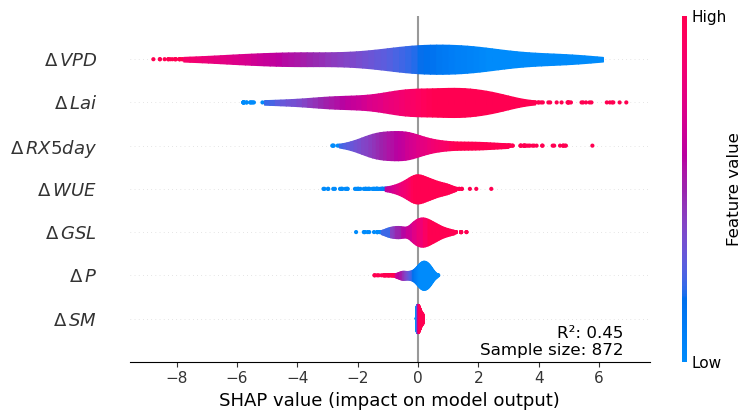

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/W.Siberia___Positive_Historical_BGWS_train_violin.pdf


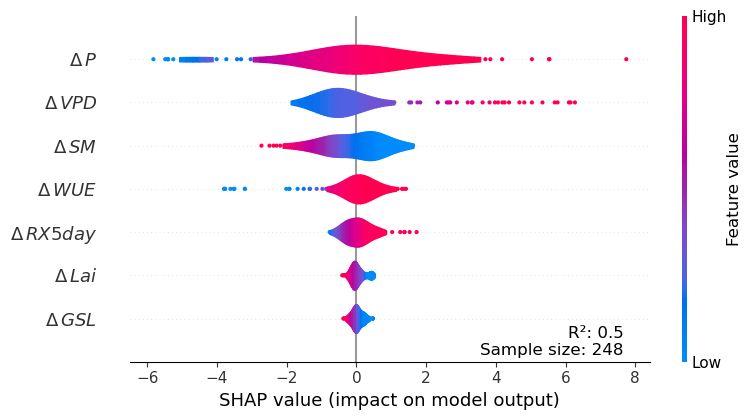

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/W.Siberia___Negative_Historical_BGWS_train_violin.pdf


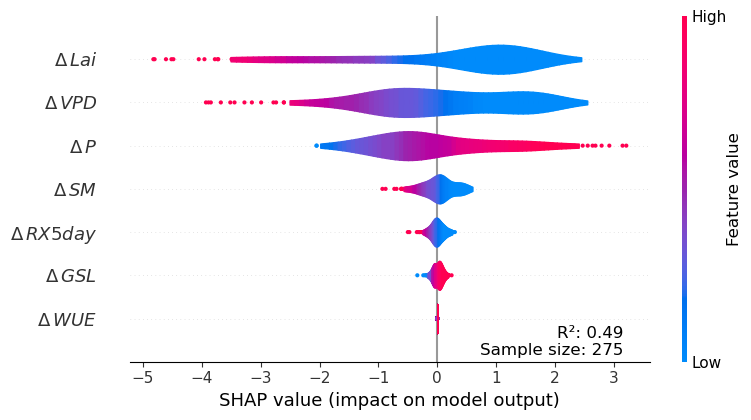

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/E.Siberia___Positive_Historical_BGWS_train_violin.pdf


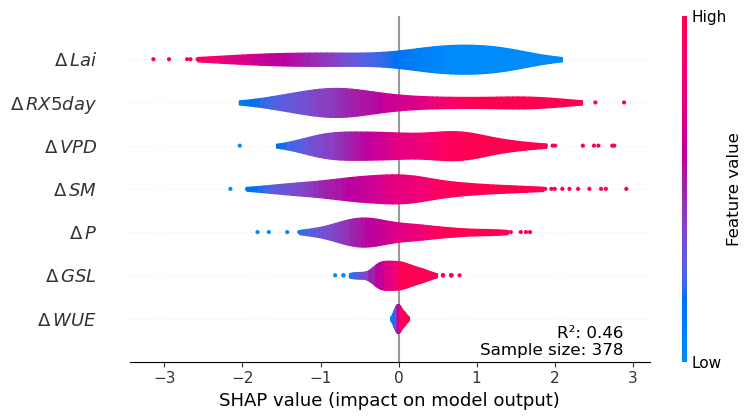

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/E.Siberia___Negative_Historical_BGWS_train_violin.pdf


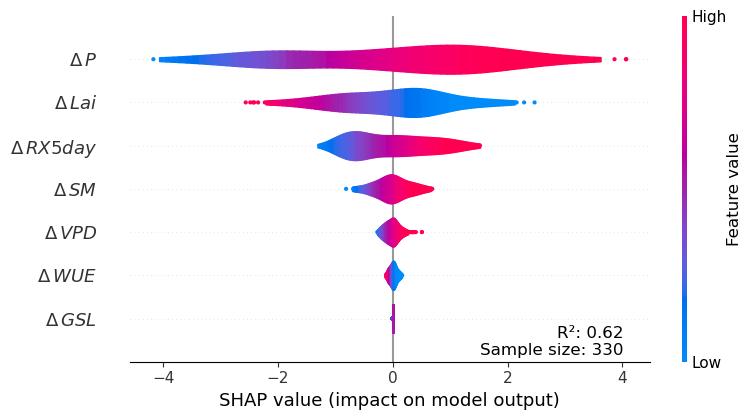

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/Russian_Far_East___Positive_Historical_BGWS_train_violin.pdf


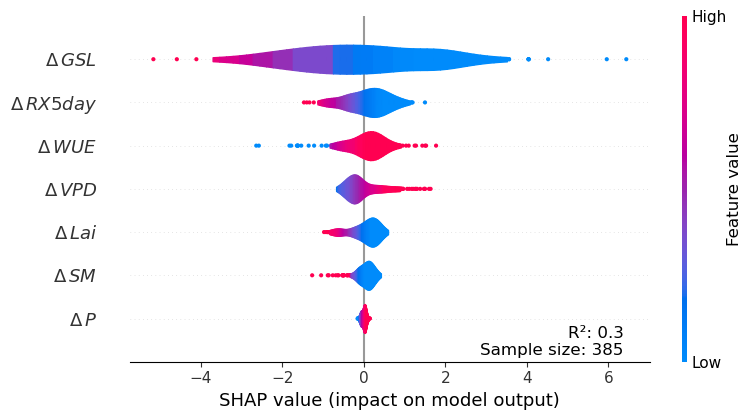

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/W.C.Asia___Positive_Historical_BGWS_train_violin.pdf


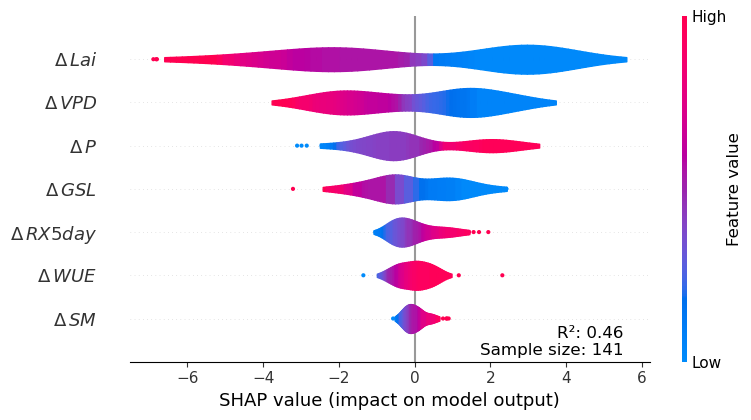

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/W.C.Asia___Negative_Historical_BGWS_train_violin.pdf


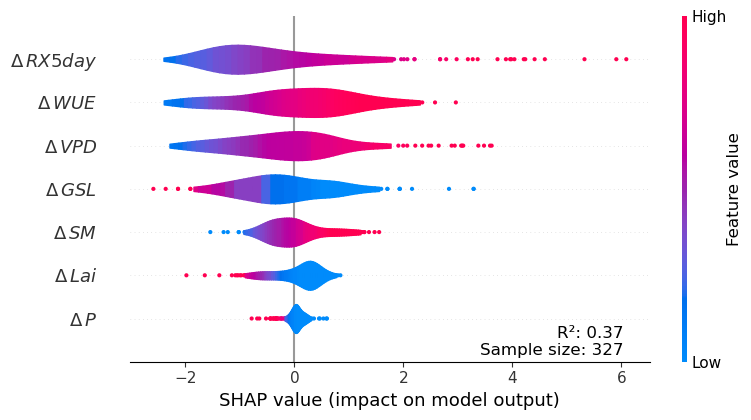

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/E.C.Asia___Positive_Historical_BGWS_train_violin.pdf


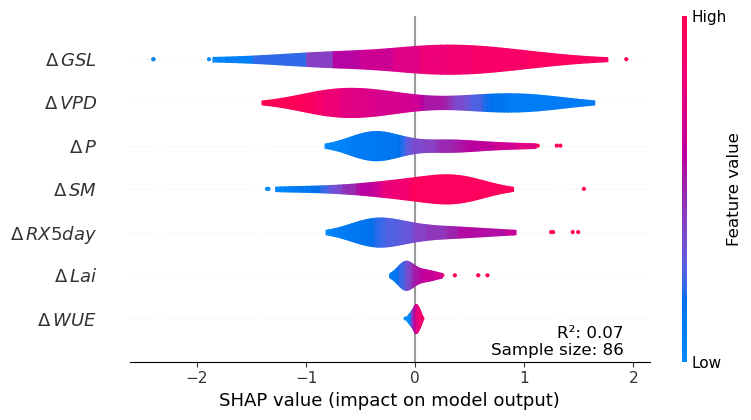

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/E.C.Asia___Negative_Historical_BGWS_train_violin.pdf


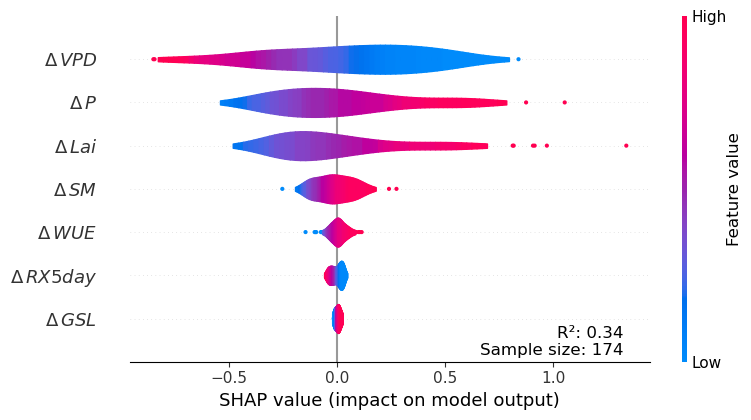

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/Tibetan_Plateau___Positive_Historical_BGWS_train_violin.pdf


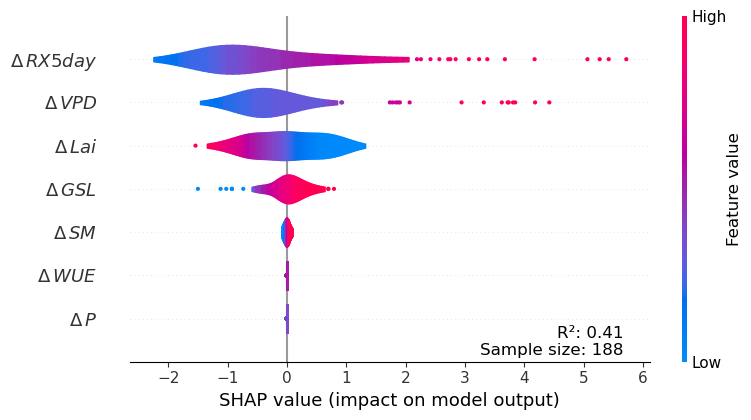

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/E.Asia___Positive_Historical_BGWS_train_violin.pdf


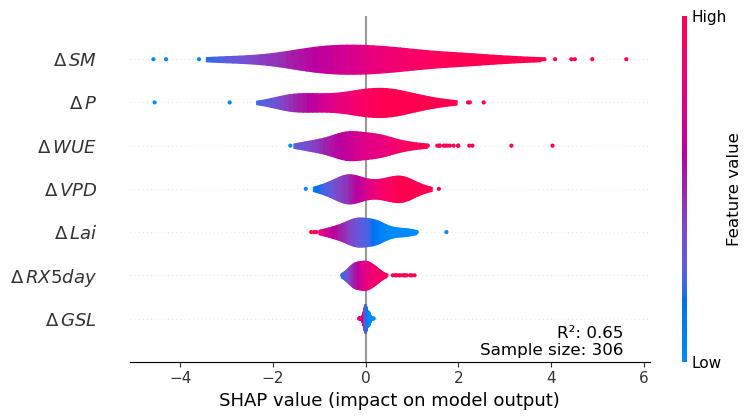

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/E.Asia___Negative_Historical_BGWS_train_violin.pdf


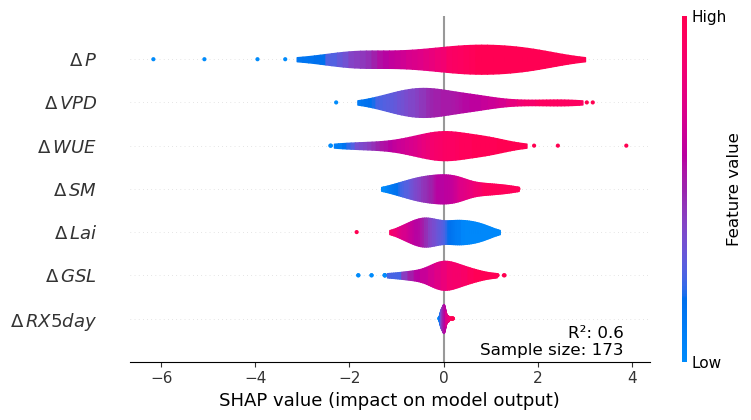

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/Arabian_Peninsula___Positive_Historical_BGWS_train_violin.pdf


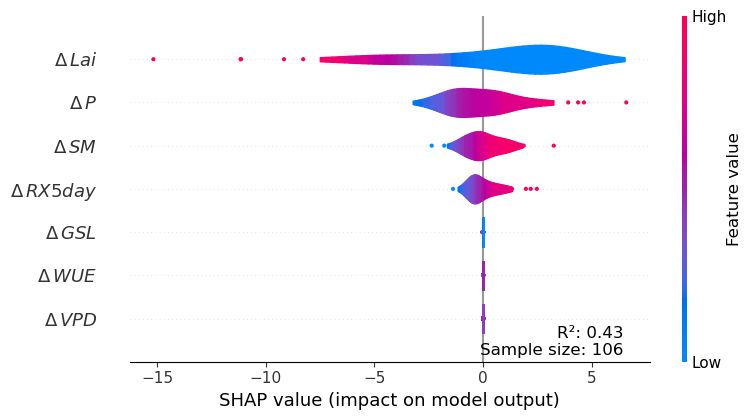

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/Arabian_Peninsula___Negative_Historical_BGWS_train_violin.pdf


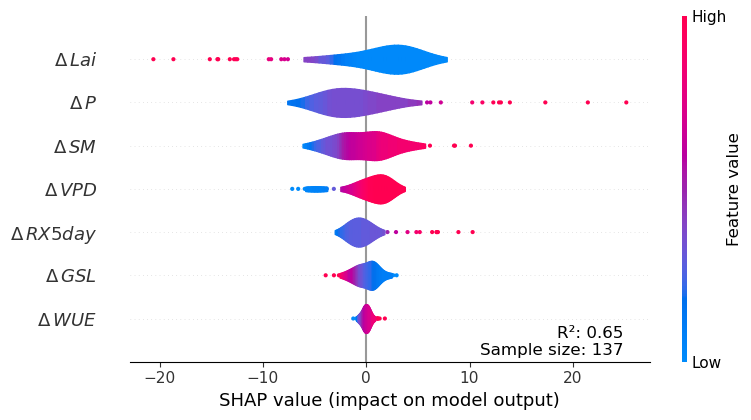

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/S.Asia___Positive_Historical_BGWS_train_violin.pdf


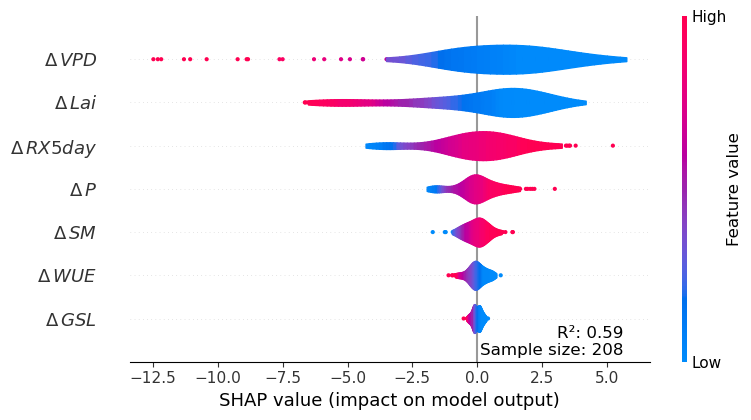

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/S.Asia___Negative_Historical_BGWS_train_violin.pdf


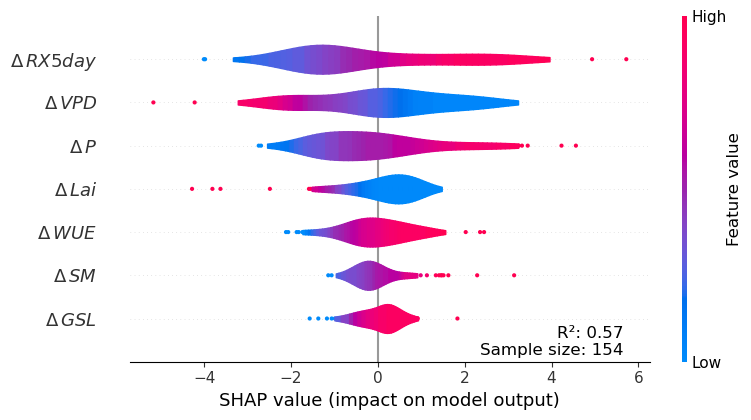

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/S.E.Asia___Positive_Historical_BGWS_train_violin.pdf


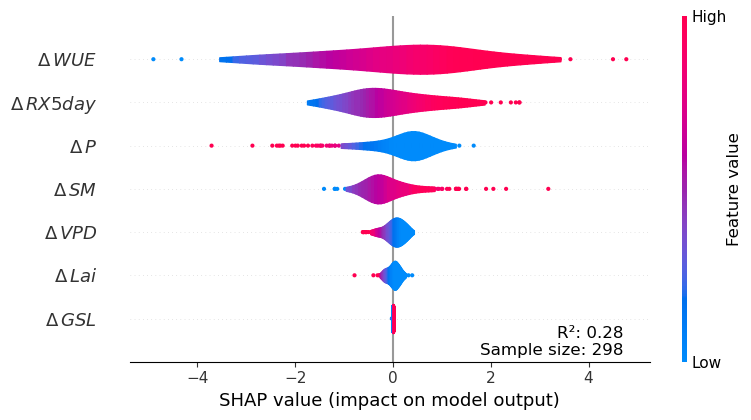

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/N.Australia___Negative_Historical_BGWS_train_violin.pdf


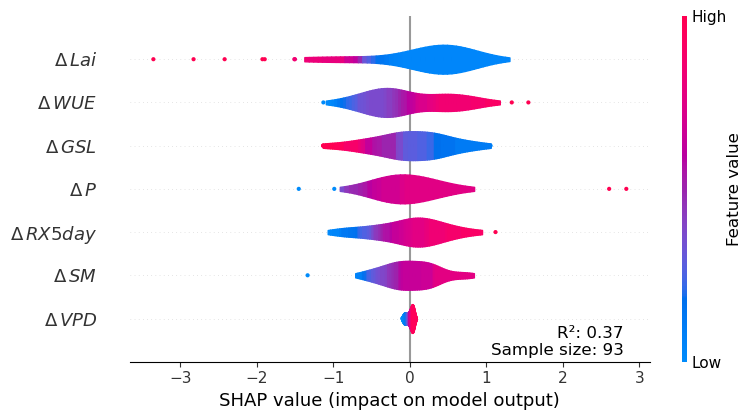

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/C.Australia___Negative_Historical_BGWS_train_violin.pdf


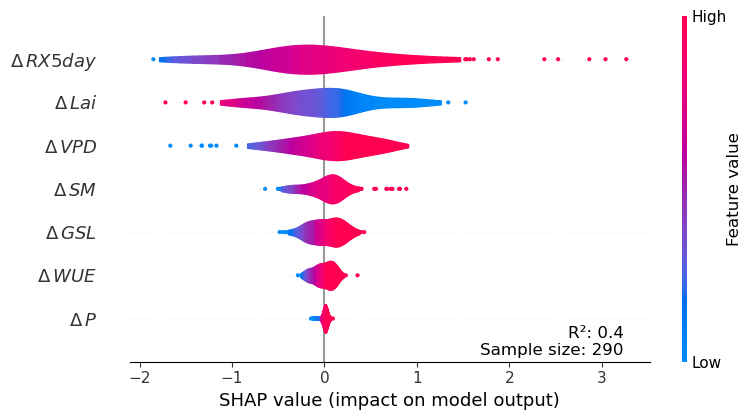

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/E.Australia___Negative_Historical_BGWS_train_violin.pdf


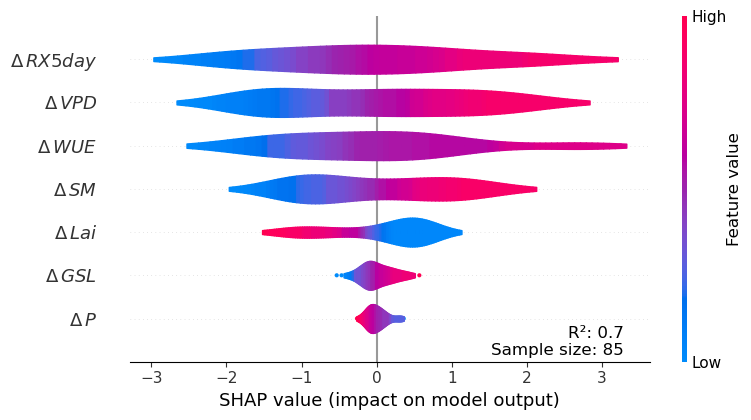

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/S.Australia___Negative_Historical_BGWS_train_violin.pdf


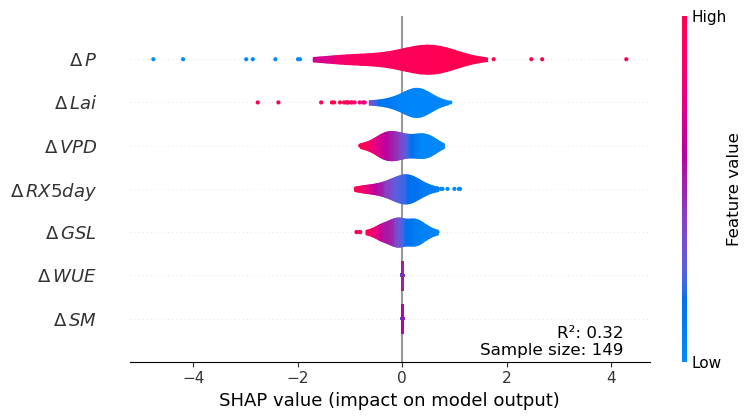

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/Global___Positive_Historical_BGWS_train_violin.pdf


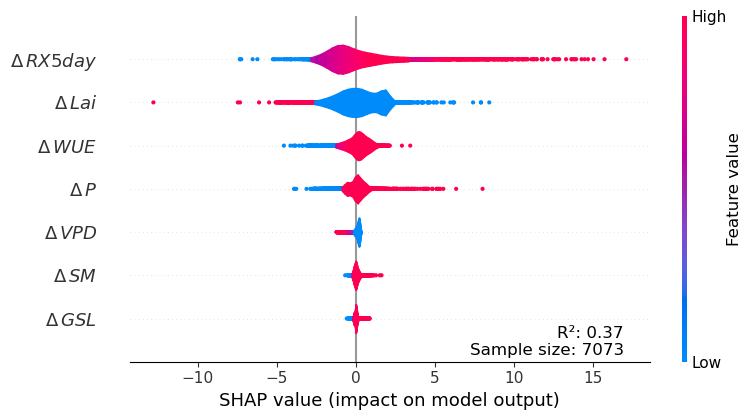

Figure saved at: /work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/Global___Negative_Historical_BGWS_train_violin.pdf


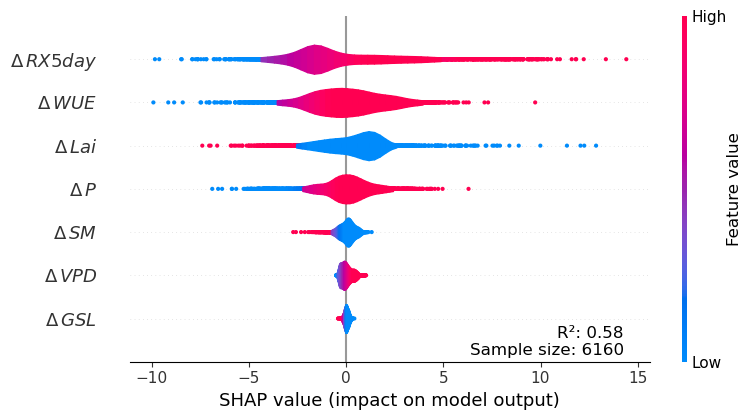

In [35]:
reg_results.plot_region_subdivision_shap(
    results_regression_analysis_regions_subdivisions,
    predictor_vars,
    importance_type='train',
    plot_type = 'violin',
    save_path='/work/ch0636/g300115/phd_project/paper_1/results/CMIP6/ssp370-historical/regression_anaylsis/shap_importance/subregions/'
)